# Import Dataset

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd gdrive/MyDrive/'EEG Dataset'/Latest

/content/gdrive/MyDrive/EEG Dataset/Latest


In [3]:
%ls

autoencoder_compress.png   Fold_1_Train_Dataset.csv  Fold_6_Test_Dataset.csv
boltzmann-machines/        Fold_2_Test_Dataset.csv   Fold_6_Train_Dataset.csv
dir/                       Fold_2_Train_Dataset.csv  Fold_7_Test_Dataset.csv
dir1/                      Fold_3_Test_Dataset.csv   Fold_7_Train_Dataset.csv
encoder_compress.png       Fold_3_Train_Dataset.csv  Fold_8_Test_Dataset.csv
encoder.h5                 Fold_4_Test_Dataset.csv   Fold_8_Train_Dataset.csv
Fold_10_Test_Dataset.csv   Fold_4_Train_Dataset.csv  Fold_9_Test_Dataset.csv
Fold_10_Train_Dataset.csv  Fold_5_Test_Dataset.csv   Fold_9_Train_Dataset.csv
Fold_1_Test_Dataset.csv    Fold_5_Train_Dataset.csv  my_dir/


# Import Libraries

In [4]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

In [6]:
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix

In [8]:
def confusionMatrix(cf_matrix):
  import numpy as np
  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ['{0:0.0f}'.format(value) for value in 
                  cf_matrix.flatten()]
  group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
  labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.set(rc={'figure.figsize':(6,3)})
  sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

# User Model

In [9]:
def userModel(clf):
  clf.fit(df_trainX, df_trainY)
  pred_test = clf.predict(df_testX)
  
  confMatrix = confusion_matrix(df_testY, pred_test)
  acc_test = accuracy_score(df_testY, pred_test)
  f_measure_test = f1_score(df_testY, pred_test)
  cf = confusion_matrix(df_testY, pred_test)
  tn, fp, fn, tp = cf[0][0], cf[0][1], cf[1][0], cf[1][1]
  sensitivity_test = tp / float(tp+fn)
  specificity_test = tn / float(tn+fp)

  print('Accuracy:', acc_test)
  print('f-measure:', f_measure_test)
  print('Sensitivity:', sensitivity_test)
  print('Specificity:', specificity_test)

  print(classification_report(df_testY, pred_test))
  confusionMatrix(cf)

  return acc_test, f_measure_test, sensitivity_test, specificity_test

In [10]:
def getVotingClassifierMetrics(df_testY, pred_test):
  confMatrix = confusion_matrix(df_testY, pred_test)
  acc_test = accuracy_score(df_testY, pred_test)
  f_measure_test = f1_score(df_testY, pred_test)
  cf = confusion_matrix(df_testY, pred_test)
  tn, fp, fn, tp = cf[0][0], cf[0][1], cf[1][0], cf[1][1]
  sensitivity_test = tp / float(tp+fn)
  specificity_test = tn / float(tn+fp)

  print('Accuracy:', acc_test)
  print('f-measure:', f_measure_test)
  print('Sensitivity:', sensitivity_test)
  print('Specificity:', specificity_test)

  print(classification_report(df_testY, pred_test))
  confusionMatrix(cf)

  return acc_test, f_measure_test, sensitivity_test, specificity_test


# Plots

## Plot for each Subject 

In [11]:
def barPlot(accuracies, title, xname):
  sns.set_style(style='white')
  models = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees']
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_title(title, size=17)
  ax.set(ylim=(0, 1.1))
  plots = sns.barplot(models, accuracies)
  plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='x-large')
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')
  plt.ylabel(xname, size=15)
  plt.xlabel('Models', size=15)
  plt.show()

## Plot for best accuracy for each Subject

In [12]:
def barPlotBestAccuracy(xVals, accuracies, title, xLabel):
  fig = plt.figure()
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  ax = fig.add_axes([0,0,1,1])
  ax.set_title(title, size=17)
  ax.set(ylim=(0, 1))
  plots = sns.barplot(xVals, accuracies)
  plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize='x-large')
  for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                    (bar.get_x() + bar.get_width() / 2,
                      bar.get_height()), ha='center', va='center',
                    size=15, xytext=(0, 8),
                    textcoords='offset points')
  plt.ylabel('Accuracy', size=15)
  plt.xlabel(xLabel, size=15)
  plt.show()

## Master Bar Plot

In [13]:
def masterBarPlot(df, title, x_str, y_str, hue_str, xlabel_str):
  sns.set_style(style='white')
  fig = plt.figure()
  ax = fig.add_axes([0,0,1,1])
  ax.set_title(title, size=17)
  ax.set(ylim=(0, 1))
  plots = sns.barplot(x=x_str, y=y_str, hue=hue_str, data=df)
  plt.xticks(rotation=45, horizontalalignment='right', fontweight='light')
  sns.set(rc={'figure.figsize':(11.7,8.27)})
  plots.legend(bbox_to_anchor= (1,0.5))
  plt.setp(plots.get_legend().get_texts(), fontsize='10') 
  plt.ylabel('Accuracy', size=15)
  plt.xlabel(xlabel_str, size=15)
  plt.show()

# Get Dataset

In [14]:
def getDataset(i):
  train_str = 'Fold_' + str(i) + '_Train_Dataset.csv'
  test_str = 'Fold_' + str(i) + '_Test_Dataset.csv'

  df_train = pd.read_csv(train_str, header=None) 
  df_test = pd.read_csv(test_str, header=None)

  return df_train, df_test

# Master Train Validation Dataset

In [15]:
def createMasterTrainVal(ind, n):
  import random
  random.seed(42)

  df_train, df_val= dict(), dict()
  i1 = 1
  while i1 < n+3:
    i = 0
    if i1>10:
      i = random.randint(1, 10)
      if i == ind:
        continue
    else:
      i = i1
    if i == ind:
      i1 += 1
      continue
    df_train_master = getDataset(1)[1][0:0]
    for j in range(1, 11):
      if j == i or j == ind:
        continue
      else:
        _, df_test_te = getDataset(j)
        df_train_master = pd.concat([df_train_master, df_test_te], ignore_index=True)
    df_train[i1] = df_train_master
    _, df_val[i1] = getDataset(i)
    i1 += 1
  return df_train, df_val

In [16]:
def getTrainValXY(i, df_train_master, df_val_master):
  df_train = df_train_master[i]
  df_val = df_val_master[i]

  df_trainX = df_train.iloc[:,:-1]
  df_trainY = df_train.iloc[:,-1]
  df_valX = df_val.iloc[:,:-1]
  df_valY = df_val.iloc[:,-1]

  df_trainY[df_trainY==1] = 0
  df_trainY[df_trainY==2] = 1
  df_valY[df_valY==1] = 0
  df_valY[df_valY==2] = 1

  return df_trainX, df_trainY, df_valX, df_valY

In [17]:
def getMasterTrainValXY(ind, n, df_train_master, df_val_master):
  df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = dict(), dict(), dict(), dict()
  n = len(df_train_master)
  for i in range(1, n+1):
    if i == ind:
      continue
    else:
      df_trainX_master[i], df_trainY_master[i], df_valX_master[i], df_valY_master[i] = getTrainValXY(i, df_train_master, df_val_master)
  return df_trainX_master, df_trainY_master, df_valX_master, df_valY_master

# Metrics and Optimisations

In [18]:
def userModelTuning(ind, clf, df_trainX_te, df_trainY_te, df_valX_te, df_valY_te):
  acc = 0
  f_measure = 0
  n = len(df_trainX_te)
  for i in range(1, n+1):
    if i == ind:
      continue
    df_trainX, df_trainY, df_valX, df_valY = df_trainX_te[i], df_trainY_te[i], df_valX_te[i], df_valY_te[i] 
    clf.fit(df_trainX, df_trainY)
    pred = clf.predict(df_valX)
    acc += accuracy_score(df_valY, pred)
    f_measure += f1_score(df_valY, pred)
  return acc/float(n), f_measure/float(n)

def getMaxFStr(check):
  f = 0
  s = ''
  f_measure, acc = 0, 0
  for i in check:
    if f == 0 or check[i][0] > f_measure:
      f = 1
      s = i
      f_measure, acc = check[i]
  return s      

## SVM

In [19]:
def optimisationSVM(ind):

  C = [0.1, 1, 10, 100, 1000]  
  gamma = [1, 0.1, 0.01, 0.001, 0.0001] 
  check = dict()
  for i in range(len(C)):
    for j in range(len(gamma)):
      svmClf = svm.SVC(C = C[i], gamma = gamma[j], kernel='rbf', random_state=31)
      svmClfAcc, svmClfF = userModelTuning(ind, svmClf, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
      s = str(C[i]) + str(gamma[j])
      check[s] = (svmClfF, svmClfAcc)
  ind = getMaxFStr(check)
  print(ind, check[ind])
  return check

## Logistic Regression

In [20]:
def optimisationLr(ind):

  penalty = ['l2', 'l1']
  C = np.logspace(-4, 4, 20)
  solver = ['liblinear']
  fit_intercept = [True, False]

  import random
  random.seed(42)
  check = dict()
  i = 0
  while i<80:
    penalty_val = penalty[random.randint(0, len(penalty)-1)]
    C_val = C[random.randint(0, len(C)-1)]
    solver_val = solver[random.randint(0, len(solver)-1)]
    fit_intercept_val = fit_intercept[random.randint(0, len(fit_intercept)-1)]
    indexVal = str(penalty_val) + str(C_val) + str(solver_val) + str(fit_intercept_val)
    if check.get(indexVal):
      continue
    else:
      lr = LogisticRegression(penalty = penalty_val, C = C_val, solver = solver_val, fit_intercept = fit_intercept_val, random_state=31)
      lra, lrf =  userModelTuning(ind, lr, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
      i+=1
      check[indexVal] = (lrf, lra)
  ind = getMaxFStr(check)
  print(ind, check[ind])
  return check

## KNN

In [21]:
def getVal(x, random):
  val = x[random.randint(0, len(x)-1)]
  return val

def optimisationKnn(ind):

  n_neighbors = [5, 10, 20, 40, 80, 160]
  weights = ['uniform', 'distance']
  algorithm = ['auto', 'ball_tree', 'kd_tree', 'brute']
  leaf_size = [15, 30, 45, 60, 75, 100]
  p = [1, 2]

  import random
  random.seed(42)
  check = dict()
  i = 0
  while i<150:
    n_neighbors_val = getVal(n_neighbors, random)
    weights_val = getVal(weights, random)
    algorithm_val = getVal(algorithm, random)
    leaf_size_val = getVal(leaf_size, random)
    p_val = getVal(p, random)

    indexVal = str(n_neighbors_val) + str(weights_val) + str(algorithm_val) + str(leaf_size_val) + str(p_val)
    if check.get(indexVal):
      continue
    else:
      knnClf = KNeighborsClassifier(n_neighbors = n_neighbors_val, weights = weights_val, algorithm = algorithm_val, 
                                    leaf_size = leaf_size_val, p = p_val)
      knnClfa, knnClfF = userModelTuning(ind, knnClf, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
      i+=1
      check[indexVal] = (knnClfF, knnClfa)
      
  ind = getMaxFStr(check)
  print(ind, check[ind])
  return check

## Decision Tree

In [22]:
def metricsDecisionTree(ind):
  dtc = DecisionTreeClassifier(random_state=31)
  dtca, dtcF = userModelTuning(ind, dtc, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
  return dtcF, dtca

## Random Forest

In [23]:
def metricsRandomForest(ind):
  rfc = RandomForestClassifier(random_state=31)
  rfca, rfcF = userModelTuning(ind, rfc, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
  return rfcF, rfca

## Boosting Trees

In [24]:
def metricsXgb(ind):
  xgbClf = xgb.XGBClassifier(random_state=31)
  xgbClfa, xgbClfF = userModelTuning(ind, xgbClf, df_trainX_master, df_trainY_master, df_valX_master, df_valY_master)
  return xgbClfF, xgbClfa

# Voting

## Weighted Voting

In [25]:
def WeightedVotingClassification(clf_list, weight_list):
 
  w = np.array(weight_list)
  total = float(np.sum(w))
  w = w/total
  
  n = len(clf_list)
  pred = np.array([0.0 for i in range(len(df_testY))])
  
  for i in range(n):
    clf = clf_list[i]
    clf.fit(df_trainX, df_trainY)

    df_pred_prob = clf.predict_proba(df_testX)[:, 1]
    pred = pred + w[i] * df_pred_prob
  
  pred[pred>=0.5] = 1
  pred[pred<0.5] = 0
  return pred

## Majority Voting

In [26]:
def MajorityVotingClassification(clf_list):
 
  n = len(clf_list)
  master_pred = []

  for i in range(n):
    clf = clf_list[i]
    clf.fit(df_trainX, df_trainY)
    pred = np.array(clf.predict(df_testX))
    master_pred.append(pred)
    
  master_pred = np.array(master_pred)
  pred = np.sum(master_pred, axis=0)
  threshold = n//2
  pred[pred<=threshold] = 0
  pred[pred>threshold] = 1
  return pred

## Unanimous Voting

In [27]:
def UnanimousVotingClassification(clf_list):
 
  n = len(clf_list)
  master_pred = []

  for i in range(n):
    clf = clf_list[i]
    clf.fit(df_trainX, df_trainY)
    pred = np.array(clf.predict(df_testX))
    master_pred.append(pred)
    
  master_pred = np.array(master_pred)
  pred = np.min(master_pred, axis=0)
  return pred

# Fold 1

In [28]:
df_train = pd.read_csv('Fold_1_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_1_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [29]:
df_train_master, df_val_master = createMasterTrainVal(1, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(1, 9, df_train_master, df_val_master)

## Metrics and Optimisations

### SVM

In [30]:
optimisationSVM(1)

10000.1 (0.8267606549975114, 0.8222222222222224)


{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5463847088420222, 0.4592592592592592),
 '0.10.1': (0.3961768682804429, 0.48888888888888893),
 '0.11': (0.29970976681503, 0.5333333333333333),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5409576848166542, 0.4462962962962963),
 '10.01': (0.5805439297195796, 0.5370370370370371),
 '10.1': (0.5884548401205619, 0.6444444444444444),
 '100.0001': (0.0, 0.3907407407407407),
 '100.001': (0.5108909166812325, 0.4833333333333334),
 '100.01': (0.40549622321886636, 0.5296296296296297),
 '100.1': (0.5338236592487294, 0.6444444444444444),
 '1000.0001': (0.46071910152643547, 0.47777777777777775),
 '1000.001': (0.4809425440603233, 0.5296296296296297),
 '1000.01': (0.5109891916022818, 0.6018518518518517),
 '1000.1': (0.631771961008133, 0.711111111111111),
 '10000.0001': (0.4976702130158059, 0.5537037037037037),
 '10000.001': (0.5739580266627248, 0.6018518518518517),
 '10000.01': (0.5293633072035042, 0.

### Logistic Regression

In [31]:
optimisationLr(1)

l20.615848211066026liblinearFalse (0.48905185460194406, 0.5333333333333333)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearTrue': (0.0, 0.4444444444444444),
 'l10.08858667904100823liblinearFalse': (0.21978292432689295,
  0.34629629629

### KNN

In [32]:
optimisationKnn(1)

10distancekd_tree302 (0.8205756137823741, 0.8148148148148149)


{'10distanceauto1001': (0.7334709089421816, 0.7648148148148148),
 '10distanceauto152': (0.8144481628019818, 0.8074074074074075),
 '10distanceauto602': (0.8144481628019818, 0.8074074074074075),
 '10distanceball_tree152': (0.8174654362318982, 0.8111111111111113),
 '10distanceball_tree452': (0.8205756137823741, 0.8148148148148149),
 '10distancebrute1001': (0.7334709089421816, 0.7648148148148148),
 '10distancebrute451': (0.7334709089421816, 0.7648148148148148),
 '10distancebrute751': (0.7334709089421816, 0.7648148148148148),
 '10distancebrute752': (0.8144481628019818, 0.8074074074074075),
 '10distancekd_tree302': (0.8205756137823741, 0.8148148148148149),
 '10uniformauto1001': (0.13320194883662376, 0.42962962962962964),
 '10uniformauto1002': (0.3824973157790495, 0.5703703703703704),
 '10uniformauto152': (0.3824973157790495, 0.5703703703703704),
 '10uniformauto451': (0.13320194883662376, 0.42962962962962964),
 '10uniformball_tree1001': (0.21937919751387244, 0.47962962962962963),
 '10uniformb

### Decision Tree

In [33]:
dtVF1, dtVAcc1 = metricsDecisionTree(1)
dtVF1, dtVAcc1

(0.7313285864997534, 0.7629629629629631)

### Random Forest

In [34]:
rfVF1, rfVAcc1 = metricsRandomForest(1)
rfVF1, rfVAcc1

(0.7638005552981666, 0.8037037037037038)

### Xgboost

In [35]:
xgbClfVF1, xgbClfVAcc1 = metricsXgb(1)
xgbClfVF1, xgbClfVAcc1

(0.7655167063565679, 0.8055555555555557)

## Model Training

### SVM

Accuracy: 0.4166666666666667
f-measure: 0.14634146341463417
Sensitivity: 0.1
Specificity: 0.7333333333333333
              precision    recall  f1-score   support

           0       0.45      0.73      0.56        30
           1       0.27      0.10      0.15        30

    accuracy                           0.42        60
   macro avg       0.36      0.42      0.35        60
weighted avg       0.36      0.42      0.35        60



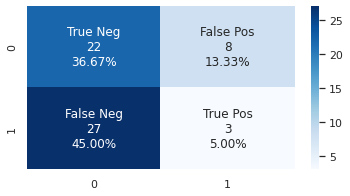

In [36]:
svmClfVF1 = 0.8267606549975114
svmClfVAcc1 = 0.8222222222222224
svmClf = svm.SVC(C = 1000, gamma = 0.1, kernel='rbf', probability=True, random_state=31)
svmClfAcc1, svmClfF1, svmClfSens1, svmClfSpec1 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.75
f-measure: 0.8
Sensitivity: 1.0
Specificity: 0.5
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        30
           1       0.67      1.00      0.80        30

    accuracy                           0.75        60
   macro avg       0.83      0.75      0.73        60
weighted avg       0.83      0.75      0.73        60



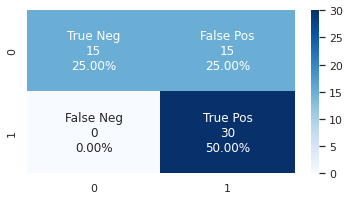

In [37]:
lrVF1, lrVAcc1 = (0.48905185460194406, 0.5333333333333333)
lr = LogisticRegression(penalty='l2', C=0.615848211066026, solver='liblinear', fit_intercept=False, random_state=31)
lrAcc1, lrF1, lrSens1, lrSpec1 = userModel(lr)

### KNN

Accuracy: 0.43333333333333335
f-measure: 0.15
Sensitivity: 0.1
Specificity: 0.7666666666666667
              precision    recall  f1-score   support

           0       0.46      0.77      0.57        30
           1       0.30      0.10      0.15        30

    accuracy                           0.43        60
   macro avg       0.38      0.43      0.36        60
weighted avg       0.38      0.43      0.36        60



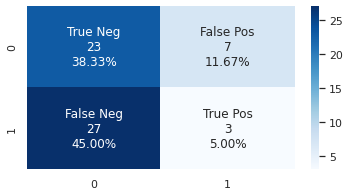

In [38]:
knnVF1, knnVAcc1 = (0.8205756137823741, 0.8148148148148149)
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='kd_tree', leaf_size=30, p=2)
knnAcc1, knnF1, knnSens1, knnSpec1 = userModel(knn)

### Decision Tree

Accuracy: 0.43333333333333335
f-measure: 0.15
Sensitivity: 0.1
Specificity: 0.7666666666666667
              precision    recall  f1-score   support

           0       0.46      0.77      0.57        30
           1       0.30      0.10      0.15        30

    accuracy                           0.43        60
   macro avg       0.38      0.43      0.36        60
weighted avg       0.38      0.43      0.36        60



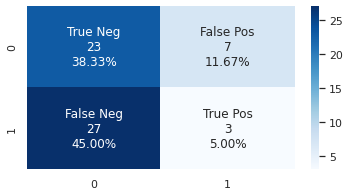

In [39]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc1, dtF1, dtSens1, dtSpec1 = userModel(dt)

### Random Forest

Accuracy: 0.55
f-measure: 0.18181818181818182
Sensitivity: 0.1
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



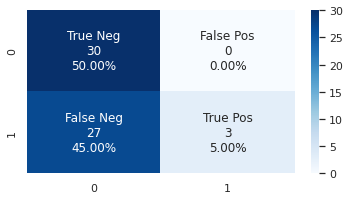

In [40]:
rf = RandomForestClassifier(random_state=31)
rfAcc1, rfF1, rfSens1, rfSpec1 = userModel(rf)

### Boosting

Accuracy: 0.55
f-measure: 0.18181818181818182
Sensitivity: 0.1
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



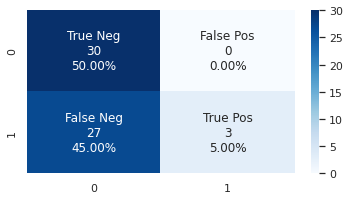

In [41]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc1, xgbClfF1, xgbClfSens1, xgbClfSpec1 = userModel(xgbClf)

## Plots

### Accuracy

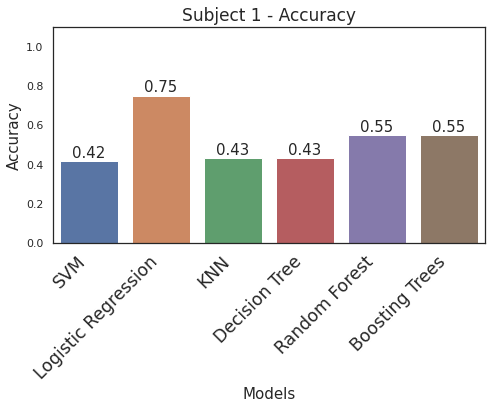

In [42]:
accuracies = [svmClfAcc1, lrAcc1, knnAcc1, dtAcc1, rfAcc1, xgbClfAcc1]
barPlot(accuracies, 'Subject 1 - Accuracy', 'Accuracy')

### F-Measure

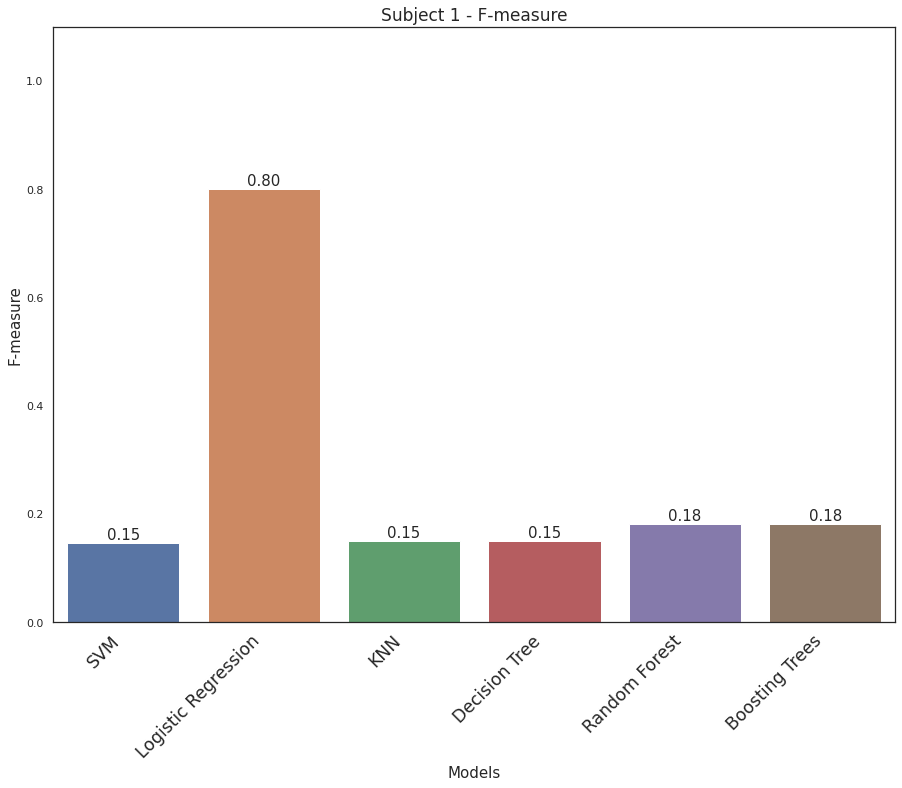

In [43]:
f_measure = [svmClfF1, lrF1, knnF1, dtF1, rfF1, xgbClfF1]
barPlot(f_measure, 'Subject 1 - F-measure', 'F-measure')

### Sensitivity

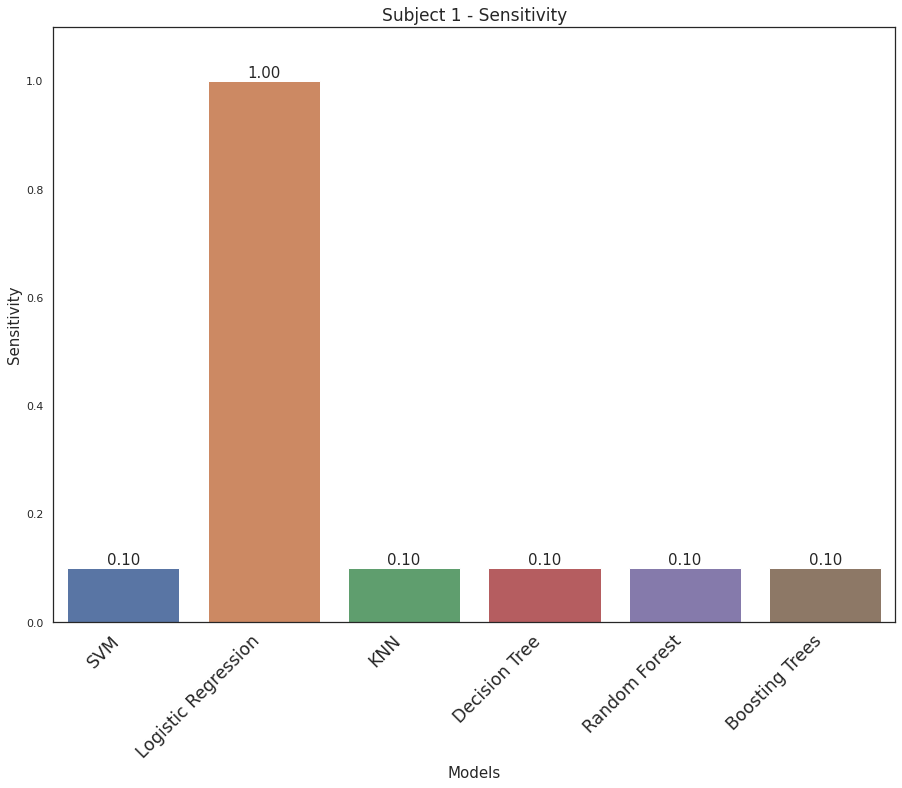

In [44]:
sens = [svmClfSens1, lrSens1, knnSens1, dtSens1, rfSens1, xgbClfSens1]
barPlot(sens, 'Subject 1 - Sensitivity', 'Sensitivity')

### Specificity

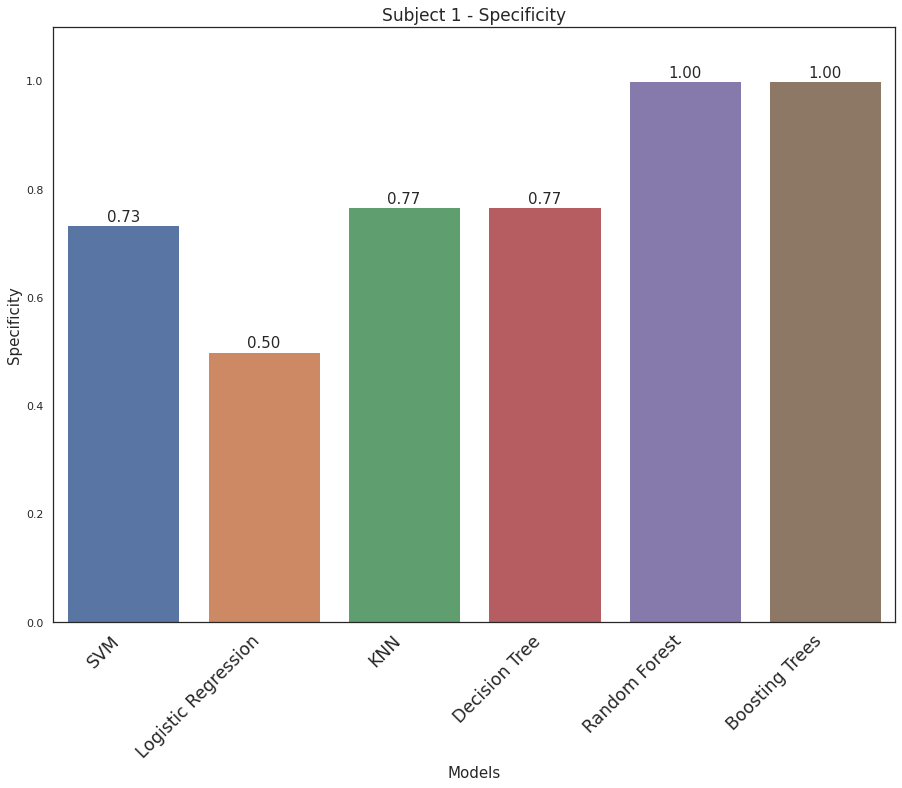

In [45]:
spec = [svmClfSpec1, lrSpec1, knnSpec1, dtSpec1, rfSpec1, xgbClfSpec1]
barPlot(spec, 'Subject 1 - Specificity', 'Specificity')

### Validation F-Measure

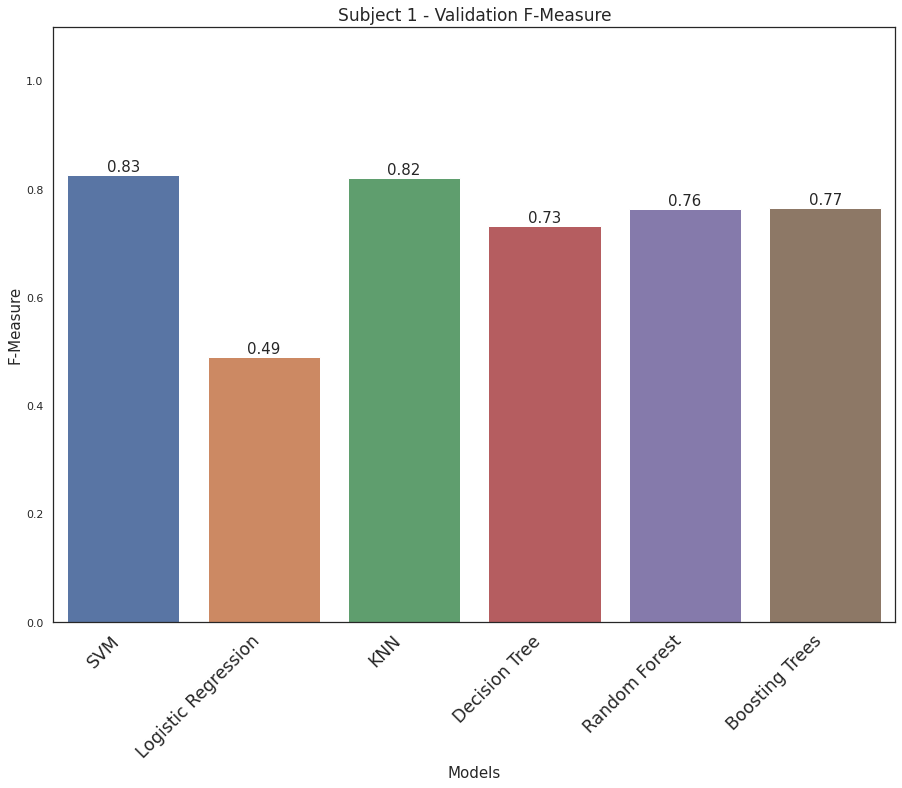

In [46]:
f_measure = [svmClfVF1, lrVF1, knnVF1, dtVF1, rfVF1, xgbClfVF1]
barPlot(f_measure, 'Subject 1 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.48333333333333334
f-measure: 0.16216216216216217
Sensitivity: 0.1
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       0.49      0.87      0.63        30
           1       0.43      0.10      0.16        30

    accuracy                           0.48        60
   macro avg       0.46      0.48      0.39        60
weighted avg       0.46      0.48      0.39        60



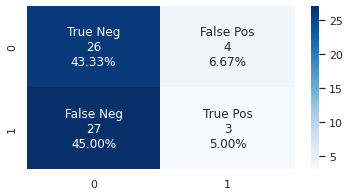

In [47]:
clf = [svmClf, knn, xgbClf]
weights = np.array([svmClfVAcc1, knnVAcc1, xgbClfVAcc1])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s1_3wv_acc, s1_3wv_f, s1_3wv_sens, s1_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.5333333333333333
f-measure: 0.17647058823529416
Sensitivity: 0.1
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       0.52      0.97      0.67        30
           1       0.75      0.10      0.18        30

    accuracy                           0.53        60
   macro avg       0.63      0.53      0.43        60
weighted avg       0.63      0.53      0.43        60



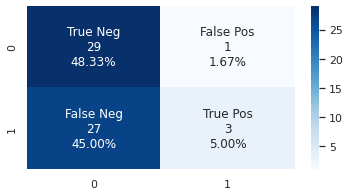

In [48]:
clf = [svmClf, knn, xgbClf, rf, dt]
weights = np.array([svmClfVAcc1, knnVAcc1, xgbClfVAcc1, rfVAcc1, dtVAcc1])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s1_5wv_acc, s1_5wv_f, s1_5wv_sens, s1_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.5
f-measure: 0.16666666666666669
Sensitivity: 0.1
Specificity: 0.9
              precision    recall  f1-score   support

           0       0.50      0.90      0.64        30
           1       0.50      0.10      0.17        30

    accuracy                           0.50        60
   macro avg       0.50      0.50      0.40        60
weighted avg       0.50      0.50      0.40        60



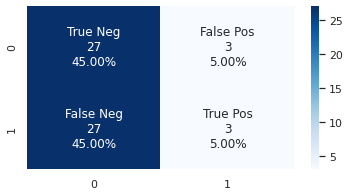

In [49]:
clf = [svmClf, knn, xgbClf]
pred = MajorityVotingClassification(clf)
s1_3mv_acc, s1_3mv_f, s1_3mv_sens, s1_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.55
f-measure: 0.18181818181818182
Sensitivity: 0.1
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



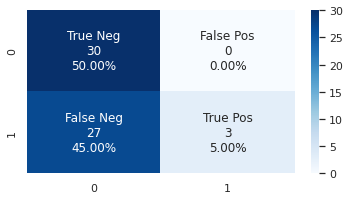

In [50]:
clf = [svmClf, knn, xgbClf, rf, dt]
pred = MajorityVotingClassification(clf)
s1_5mv_acc, s1_5mv_f, s1_5mv_sens, s1_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.55
f-measure: 0.18181818181818182
Sensitivity: 0.1
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



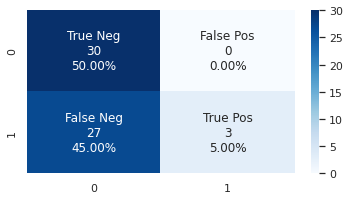

In [51]:
clf = [svmClf, knn, xgbClf]
pred = UnanimousVotingClassification(clf)
s1_3uv_acc, s1_3uv_f, s1_3uv_sens, s1_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.55
f-measure: 0.18181818181818182
Sensitivity: 0.1
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



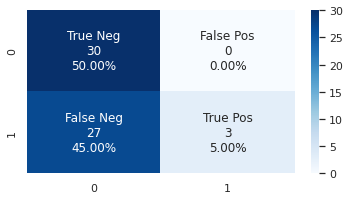

In [52]:
clf = [svmClf, knn, xgbClf, rf, dt]
pred = UnanimousVotingClassification(clf)
s1_5uv_acc, s1_5uv_f, s1_5uv_sens, s1_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

## Metrics

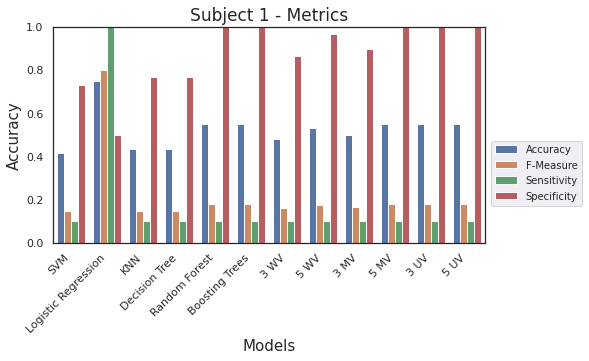

In [53]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc1, lrAcc1, knnAcc1, dtAcc1, rfAcc1, xgbClfAcc1, s1_3wv_acc, s1_5wv_acc, s1_3mv_acc, s1_5mv_acc, s1_3uv_acc, s1_5uv_acc, svmClfF1, lrF1, knnF1, dtF1, rfF1, xgbClfF1, s1_3wv_f, s1_5wv_f, s1_3mv_f, s1_5mv_f, s1_3uv_f, s1_5uv_f, svmClfSens1, lrSens1, knnSens1, dtSens1, rfSens1, xgbClfSens1, s1_3wv_sens, s1_5wv_sens, s1_3mv_sens, s1_5mv_sens, s1_3uv_sens, s1_5uv_sens, svmClfSpec1, lrSpec1, knnSpec1, dtSpec1, rfSpec1, xgbClfSpec1, s1_3wv_spec, s1_5wv_spec, s1_3mv_spec, s1_5mv_spec, s1_3uv_spec, s1_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 1 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Fold 2

In [54]:
df_train = pd.read_csv('Fold_2_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_2_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [55]:
df_train_master, df_val_master = createMasterTrainVal(2, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(2, 9, df_train_master, df_val_master)

## Metrics and Optimisations

### SVM

In [56]:
optimisationSVM(2)

10000.1 (0.6588284600237547, 0.7203703703703704)


{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5482873921463616, 0.46851851851851856),
 '0.10.1': (0.5415528808094168, 0.5425925925925925),
 '0.11': (0.1933654775760039, 0.4833333333333333),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5270136467346851, 0.4629629629629629),
 '10.01': (0.5347419903550826, 0.5314814814814814),
 '10.1': (0.5898099220921015, 0.6518518518518518),
 '100.0001': (0.011904761904761904, 0.3907407407407407),
 '100.001': (0.4709763175498815, 0.5092592592592592),
 '100.01': (0.4928477931539781, 0.5944444444444444),
 '100.1': (0.5306227520201663, 0.6407407407407407),
 '1000.0001': (0.4720857321642025, 0.5425925925925926),
 '1000.001': (0.42891918620643704, 0.5574074074074074),
 '1000.01': (0.5852286727466067, 0.6425925925925926),
 '1000.1': (0.46733826938430517, 0.6222222222222222),
 '10000.0001': (0.4377715618833807, 0.5648148148148149),
 '10000.001': (0.569669959846876, 0.6203703703703703),
 '10000.01': (0.4

### Logistic Regression

In [57]:
optimisationLr(2)

l20.23357214690901212liblinearFalse (0.6313635751857931, 0.6129629629629629)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.38518518518518513),
 'l10.03359818286283781liblinearTrue': (0.0, 0.38518518518518513),
 'l10.08858667904100823liblinearFalse': (0.46800288067550433,
  0.498148148

### KNN

In [58]:
optimisationKnn(2)

20distanceball_tree302 (0.7872875046545571, 0.7722222222222223)


{'10distanceauto1001': (0.6324995783834937, 0.701851851851852),
 '10distanceauto152': (0.6486846550270084, 0.7111111111111111),
 '10distanceauto602': (0.6486846550270084, 0.7111111111111111),
 '10distanceball_tree152': (0.6501922684749206, 0.712962962962963),
 '10distanceball_tree452': (0.6486846550270084, 0.7111111111111111),
 '10distancebrute1001': (0.6324995783834937, 0.701851851851852),
 '10distancebrute451': (0.6324995783834937, 0.701851851851852),
 '10distancebrute751': (0.6324995783834937, 0.701851851851852),
 '10distancebrute752': (0.6486846550270084, 0.7111111111111111),
 '10distancekd_tree302': (0.6486846550270084, 0.7111111111111111),
 '10uniformauto1001': (0.19560613678260738, 0.461111111111111),
 '10uniformauto1002': (0.21369251899979863, 0.4722222222222222),
 '10uniformauto152': (0.21369251899979863, 0.4722222222222222),
 '10uniformauto451': (0.19560613678260738, 0.461111111111111),
 '10uniformball_tree1001': (0.21227280344927404, 0.46851851851851856),
 '10uniformball_tre

### Decision Tree

In [59]:
dtVF2, dtVAcc2 = metricsDecisionTree(2)
dtVF2, dtVAcc2

(0.6236287330814695, 0.7055555555555555)

### Random Forest

In [60]:
rfVF2, rfVAcc2 = metricsRandomForest(2)
rfVF2, rfVAcc2

(0.6591490081792041, 0.7537037037037037)

### Xgboost

In [61]:
xgbClfVF2, xgbClfVAcc2 = metricsXgb(2)
xgbClfVF2, xgbClfVAcc2

(0.6542509425608938, 0.7481481481481481)

## Model Training

### SVM

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



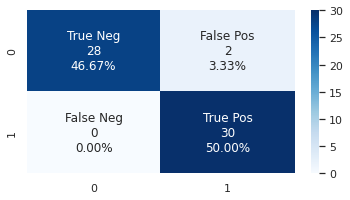

In [62]:
svmClfVF2 = 0.6588284600237547
svmClfVAcc2 = 0.7203703703703704
svmClf = svm.SVC(C = 1000, gamma = 0.1, kernel='rbf', probability=True, random_state=31)
svmClfAcc2, svmClfF2, svmClfSens2, svmClfSpec2 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.38333333333333336
f-measure: 0.13953488372093023
Sensitivity: 0.1
Specificity: 0.6666666666666666
              precision    recall  f1-score   support

           0       0.43      0.67      0.52        30
           1       0.23      0.10      0.14        30

    accuracy                           0.38        60
   macro avg       0.33      0.38      0.33        60
weighted avg       0.33      0.38      0.33        60



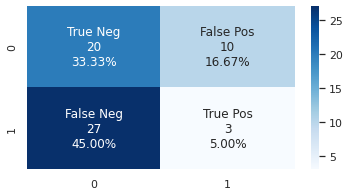

In [63]:
lrVF2, lrVAcc2 = (0.6313635751857931, 0.6129629629629629)
lr = LogisticRegression(penalty='l2', C=0.23357214690901212, solver='liblinear', fit_intercept=False, random_state=31)
lrAcc2, lrF2, lrSens2, lrSpec2 = userModel(lr)

### KNN

Accuracy: 0.9333333333333333
f-measure: 0.9375
Sensitivity: 1.0
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



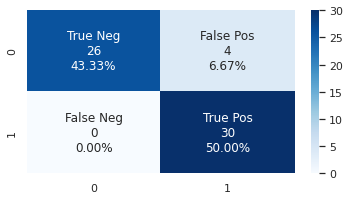

In [64]:
knnVF2, knnVAcc2 = (0.7872875046545571, 0.7722222222222223)
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='ball_tree', leaf_size=30, p=2)
knnAcc2, knnF2, knnSens2, knnSpec2 = userModel(knn)

### Decision Tree

Accuracy: 0.8833333333333333
f-measure: 0.8955223880597014
Sensitivity: 1.0
Specificity: 0.7666666666666667
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.81      1.00      0.90        30

    accuracy                           0.88        60
   macro avg       0.91      0.88      0.88        60
weighted avg       0.91      0.88      0.88        60



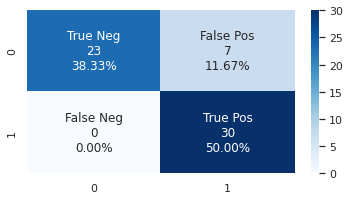

In [65]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc2, dtF2, dtSens2, dtSpec2 = userModel(dt)

### Random Forest

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



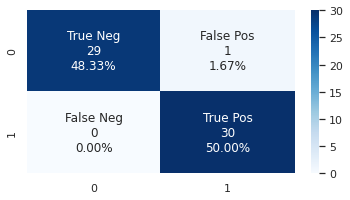

In [66]:
rf = RandomForestClassifier(random_state=31)
rfAcc2, rfF2, rfSens2, rfSpec2 = userModel(rf)

### Boosting

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



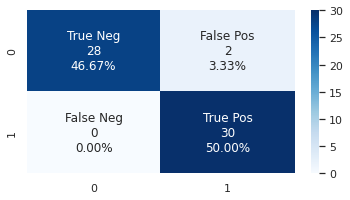

In [67]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc2, xgbClfF2, xgbClfSens2, xgbClfSpec2 = userModel(xgbClf)

## Plots

### Accuracy

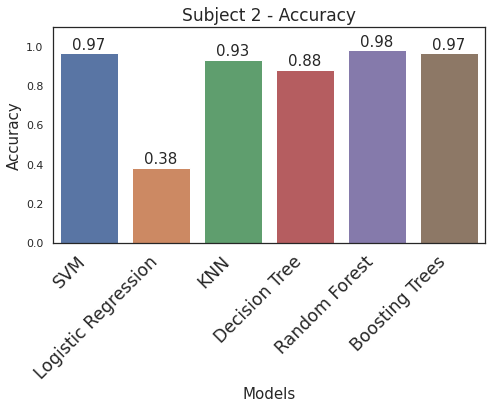

In [68]:
accuracies = [svmClfAcc2, lrAcc2, knnAcc2, dtAcc2, rfAcc2, xgbClfAcc2]
barPlot(accuracies, 'Subject 2 - Accuracy', 'Accuracy')

### F-Measure

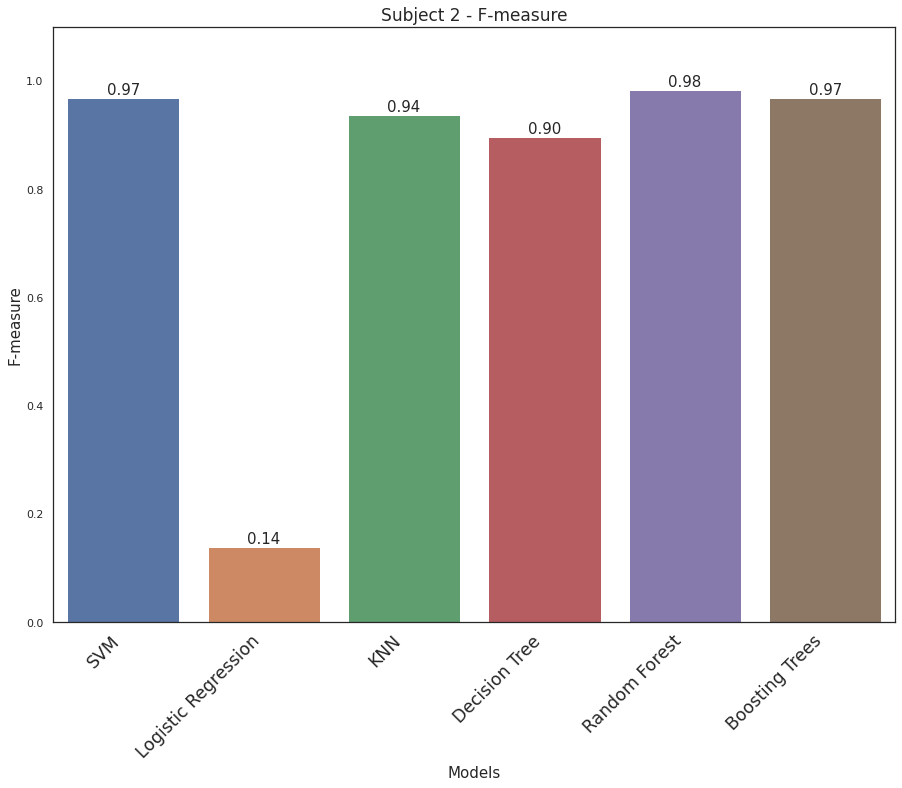

In [69]:
f_measure = [svmClfF2, lrF2, knnF2, dtF2, rfF2, xgbClfF2]
barPlot(f_measure, 'Subject 2 - F-measure', 'F-measure')

### Sensitivity

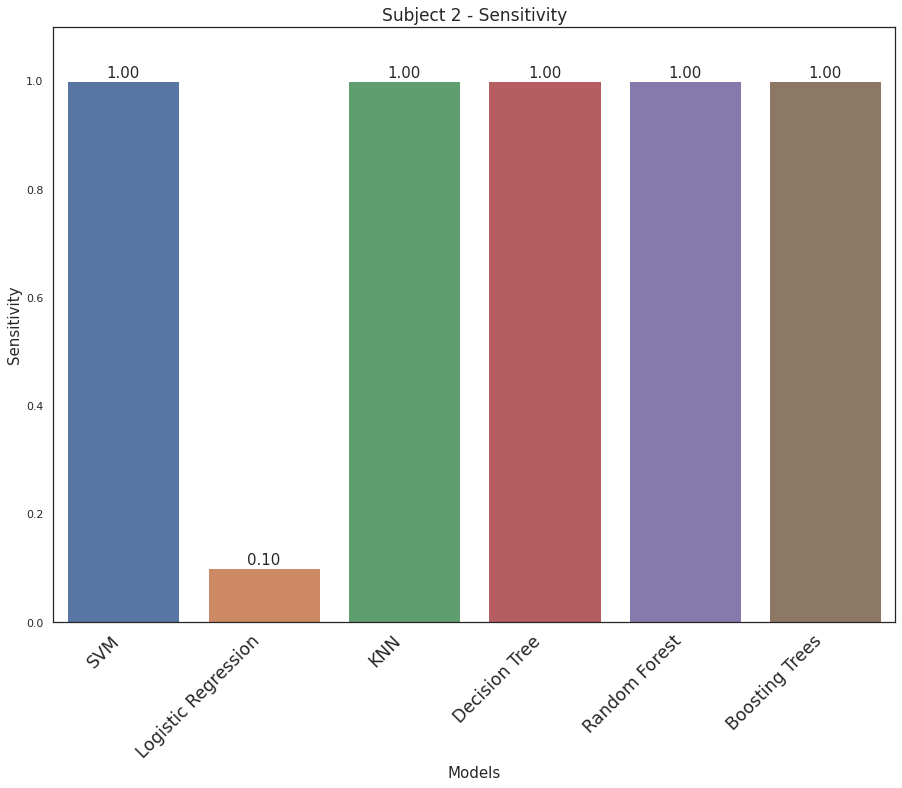

In [70]:
sens = [svmClfSens2, lrSens2, knnSens2, dtSens2, rfSens2, xgbClfSens2]
barPlot(sens, 'Subject 2 - Sensitivity', 'Sensitivity')

### Specificity

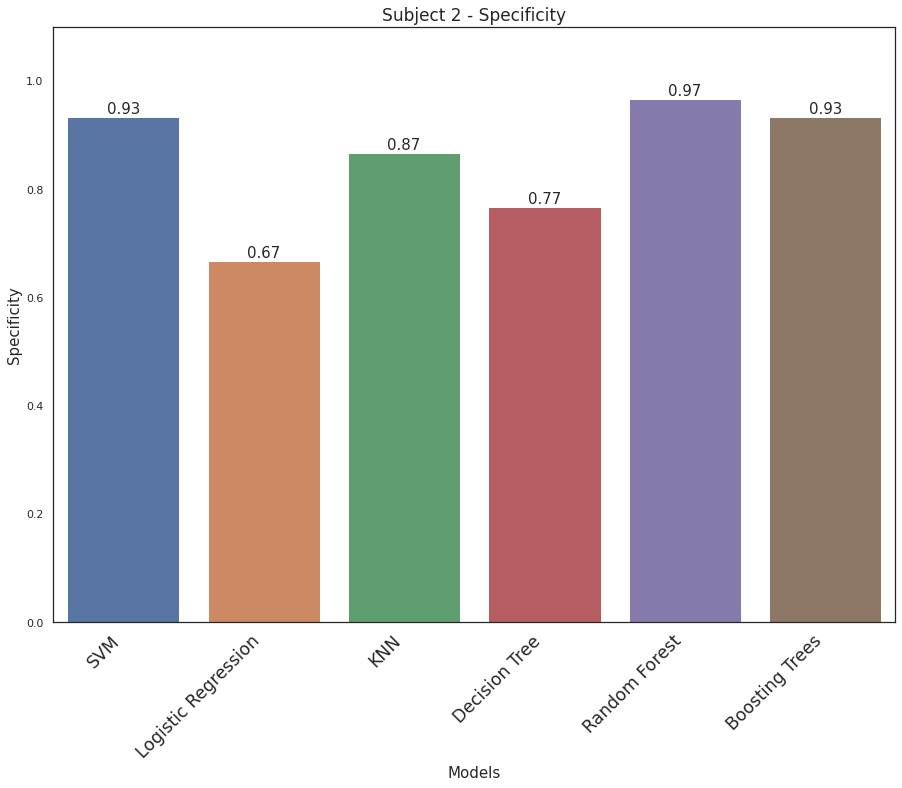

In [71]:
spec = [svmClfSpec2, lrSpec2, knnSpec2, dtSpec2, rfSpec2, xgbClfSpec2]
barPlot(spec, 'Subject 2 - Specificity', 'Specificity')

### Validation F-Measure

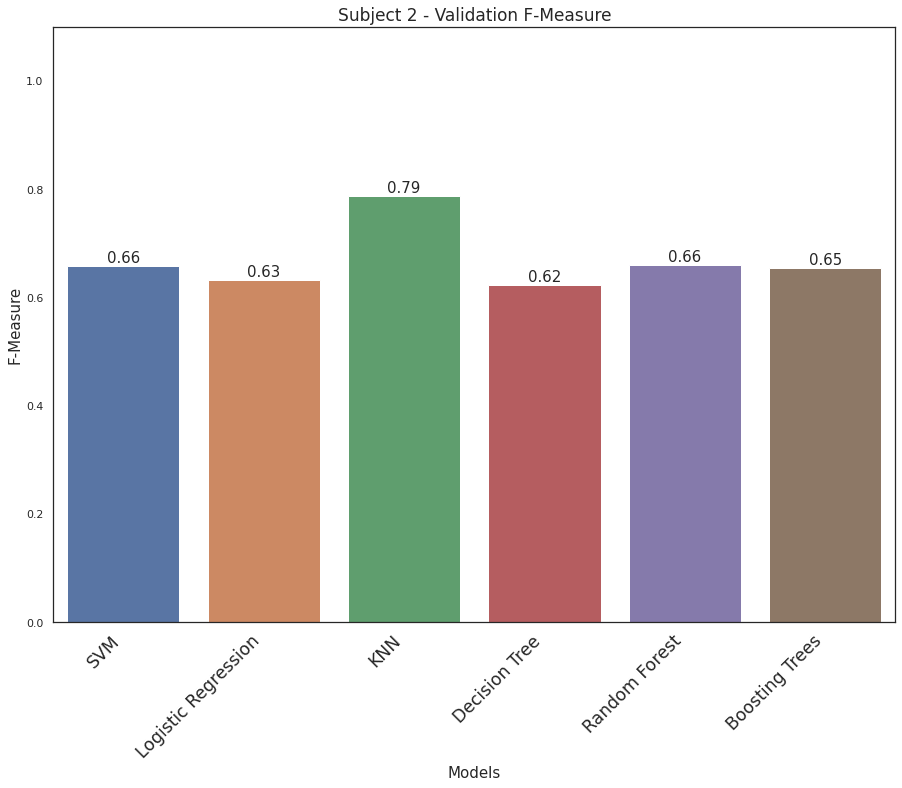

In [72]:
f_measure = [svmClfVF2, lrVF2, knnVF2, dtVF2, rfVF2, xgbClfVF2]
barPlot(f_measure, 'Subject 2 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



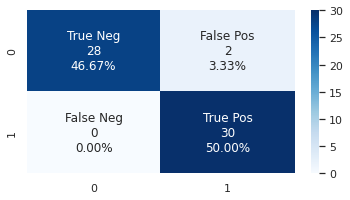

In [73]:
clf = [svmClf, rf, knn]
weights = np.array([svmClfVAcc2, rfVAcc2, knnVAcc2])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s2_3wv_acc, s2_3wv_f, s2_3wv_sens, s2_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



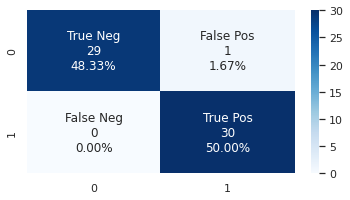

In [74]:
clf = [svmClf, rf, xgbClf, knn, dt]
weights = np.array([svmClfVAcc2, rfVAcc2, xgbClfVAcc2, knnVAcc2, dtVAcc2])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s2_5wv_acc, s2_5wv_f, s2_5wv_sens, s2_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



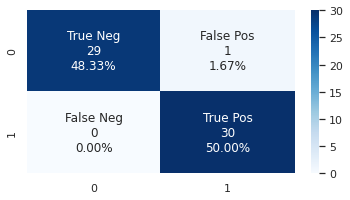

In [75]:
clf = [svmClf, rf, knn]
pred = MajorityVotingClassification(clf)
s2_3mv_acc, s2_3mv_f, s2_3mv_sens, s2_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



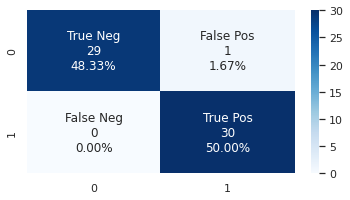

In [76]:
clf = [svmClf, rf, xgbClf, knn, dt]
pred = MajorityVotingClassification(clf)
s2_5mv_acc, s2_5mv_f, s2_5mv_sens, s2_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



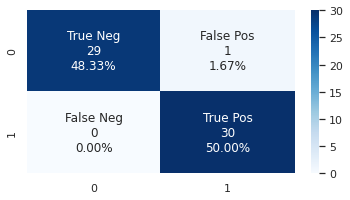

In [77]:
clf = [svmClf, rf, knn]
pred = UnanimousVotingClassification(clf)
s2_3uv_acc, s2_3uv_f, s2_3uv_sens, s2_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



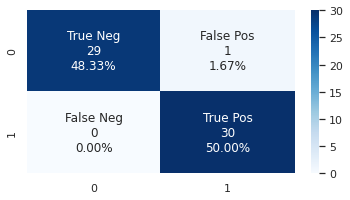

In [78]:
clf = [svmClf, rf, xgbClf, knn, dt]
pred = UnanimousVotingClassification(clf)
s2_5uv_acc, s2_5uv_f, s2_5uv_sens, s2_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

## Metrics

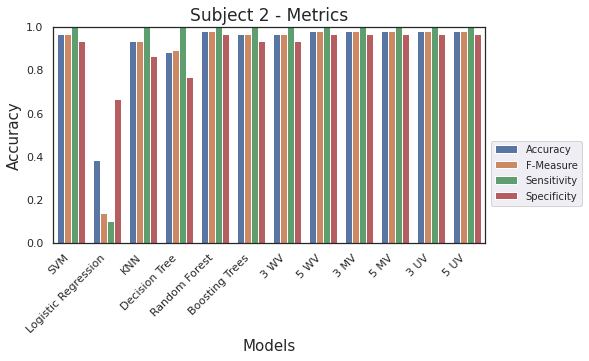

In [79]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc2, lrAcc2, knnAcc2, dtAcc2, rfAcc2, xgbClfAcc2, s2_3wv_acc, s2_5wv_acc, s2_3mv_acc, s2_5mv_acc, s2_3uv_acc, s2_5uv_acc, svmClfF2, lrF2, knnF2, dtF2, rfF2, xgbClfF2, s2_3wv_f, s2_5wv_f, s2_3mv_f, s2_5mv_f, s2_3uv_f, s2_5uv_f, svmClfSens2, lrSens2, knnSens2, dtSens2, rfSens2, xgbClfSens2, s2_3wv_sens, s2_5wv_sens, s2_3mv_sens, s2_5mv_sens, s2_3uv_sens, s2_5uv_sens, svmClfSpec2, lrSpec2, knnSpec2, dtSpec2, rfSpec2, xgbClfSpec2, s2_3wv_spec, s2_5wv_spec, s2_3mv_spec, s2_5mv_spec, s2_3uv_spec, s2_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 2 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Fold 3

In [80]:
df_train = pd.read_csv('Fold_3_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_3_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [81]:
df_train_master, df_val_master = createMasterTrainVal(3, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(3, 9, df_train_master, df_val_master)

## Metrics and Optimisations

### SVM

In [82]:
optimisationSVM(3)

10000.1 (0.732329482447388, 0.7611111111111112)


{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5472554855748678, 0.461111111111111),
 '0.10.1': (0.3942412279394037, 0.4870370370370371),
 '0.11': (0.2799596845649477, 0.5314814814814814),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5295679251510325, 0.4574074074074074),
 '10.01': (0.6082740226295338, 0.587037037037037),
 '10.1': (0.49398729332516833, 0.6092592592592593),
 '100.0001': (0.0784313725490196, 0.4277777777777778),
 '100.001': (0.5302790287014622, 0.5462962962962963),
 '100.01': (0.5894056667677354, 0.6648148148148149),
 '100.1': (0.4357606372813674, 0.5777777777777778),
 '1000.0001': (0.4692096682723936, 0.5277777777777778),
 '1000.001': (0.42224984009200556, 0.538888888888889),
 '1000.01': (0.5166054045703289, 0.612962962962963),
 '1000.1': (0.5465246985729223, 0.6592592592592592),
 '10000.0001': (0.40924268296720134, 0.5351851851851852),
 '10000.001': (0.4036866633356805, 0.5351851851851852),
 '10000.01': (0.436271

### Logistic Regression

In [83]:
optimisationLr(3)

l11.623776739188721liblinearFalse (0.6458532847570049, 0.6388888888888888)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.38518518518518513),
 'l10.03359818286283781liblinearTrue': (0.0, 0.38518518518518513),
 'l10.08858667904100823liblinearFalse': (0.5421769737183629,
  0.5574074074

### KNN

In [84]:
optimisationKnn(3)

20distanceball_tree302 (0.7908115002085351, 0.7777777777777777)


{'10distanceauto1001': (0.6441725616127244, 0.7037037037037037),
 '10distanceauto152': (0.723934627142108, 0.7481481481481482),
 '10distanceauto602': (0.723934627142108, 0.7481481481481482),
 '10distanceball_tree152': (0.7268630987883716, 0.751851851851852),
 '10distanceball_tree452': (0.7257619894055005, 0.751851851851852),
 '10distancebrute1001': (0.6441725616127244, 0.7037037037037037),
 '10distancebrute451': (0.6441725616127244, 0.7037037037037037),
 '10distancebrute751': (0.6441725616127244, 0.7037037037037037),
 '10distancebrute752': (0.723934627142108, 0.7481481481481482),
 '10distancekd_tree302': (0.7257619894055005, 0.751851851851852),
 '10uniformauto1001': (0.28495722673325286, 0.5111111111111111),
 '10uniformauto1002': (0.29299813425248666, 0.5111111111111111),
 '10uniformauto152': (0.29299813425248666, 0.5111111111111111),
 '10uniformauto451': (0.28495722673325286, 0.5111111111111111),
 '10uniformball_tree1001': (0.2897763206827816, 0.5185185185185185),
 '10uniformball_tree

### Decision Tree

In [85]:
dtVF3, dtVAcc3 = metricsDecisionTree(3)
dtVF3, dtVAcc3

(0.6331023143523145, 0.6925925925925926)

### Random Forest

In [86]:
rfVF3, rfVAcc3 = metricsRandomForest(3)
rfVF3, rfVAcc3

(0.6809895504073007, 0.7629629629629631)

### Xgboost

In [87]:
xgbClfVF3, xgbClfVAcc3 = metricsXgb(3)
xgbClfVF3, xgbClfVAcc3

(0.666225325465261, 0.7444444444444444)

## Model Training

### SVM

Accuracy: 0.9166666666666666
f-measure: 0.923076923076923
Sensitivity: 1.0
Specificity: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.86      1.00      0.92        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



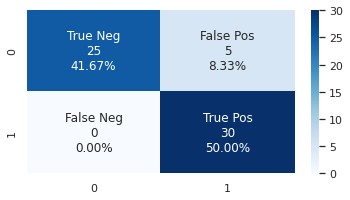

In [88]:
svmClfVF3 = 0.732329482447388
svmClfVAcc3 = 0.7611111111111112
svmClf = svm.SVC(C = 1000, gamma = 0.1, kernel='rbf', probability=True, random_state=31)
svmClfAcc3, svmClfF3, svmClfSens3, svmClfSpec3 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.3
f-measure: 0.125
Sensitivity: 0.1
Specificity: 0.5
              precision    recall  f1-score   support

           0       0.36      0.50      0.42        30
           1       0.17      0.10      0.12        30

    accuracy                           0.30        60
   macro avg       0.26      0.30      0.27        60
weighted avg       0.26      0.30      0.27        60



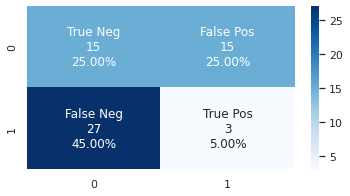

In [89]:
lrVF3, lrVAcc3 = (0.6458532847570049, 0.6388888888888888)
lr = LogisticRegression(penalty='l1', C=1.623776739188721, solver='liblinear', fit_intercept=False, random_state=31)
lrAcc3, lrF3, lrSens3, lrSpec3 = userModel(lr)

### KNN

Accuracy: 0.8166666666666667
f-measure: 0.8450704225352113
Sensitivity: 1.0
Specificity: 0.6333333333333333
              precision    recall  f1-score   support

           0       1.00      0.63      0.78        30
           1       0.73      1.00      0.85        30

    accuracy                           0.82        60
   macro avg       0.87      0.82      0.81        60
weighted avg       0.87      0.82      0.81        60



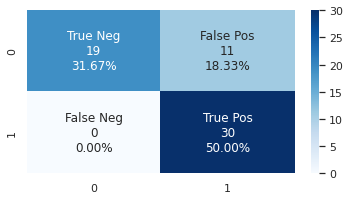

In [90]:
knnVF3, knnVAcc3 = (0.7908115002085351, 0.7777777777777777)
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='ball_tree', leaf_size=30, p=2)
knnAcc3, knnF3, knnSens3, knnSpec3 = userModel(knn)

### Decision Tree

Accuracy: 0.9
f-measure: 0.9090909090909091
Sensitivity: 1.0
Specificity: 0.8
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



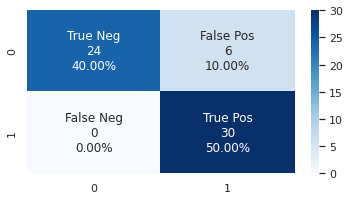

In [91]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc3, dtF3, dtSens3, dtSpec3 = userModel(dt)

### Random Forest

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



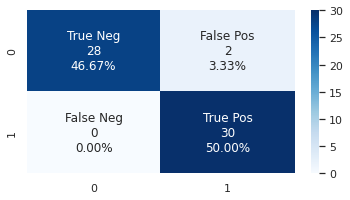

In [92]:
rf = RandomForestClassifier(random_state=31)
rfAcc3, rfF3, rfSens3, rfSpec3 = userModel(rf)

### Boosting

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



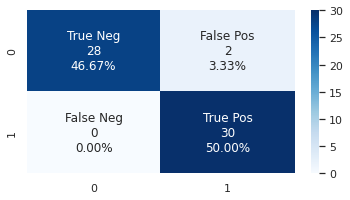

In [93]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc3, xgbClfF3, xgbClfSens3, xgbClfSpec3 = userModel(xgbClf)

## Plots

### Accuracy

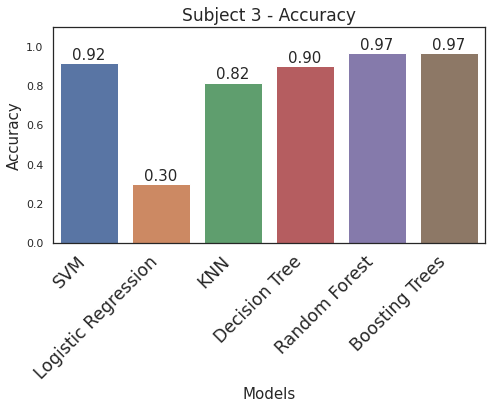

In [94]:
accuracies = [svmClfAcc3, lrAcc3, knnAcc3, dtAcc3, rfAcc3, xgbClfAcc3]
barPlot(accuracies, 'Subject 3 - Accuracy', 'Accuracy')

### F-Measure

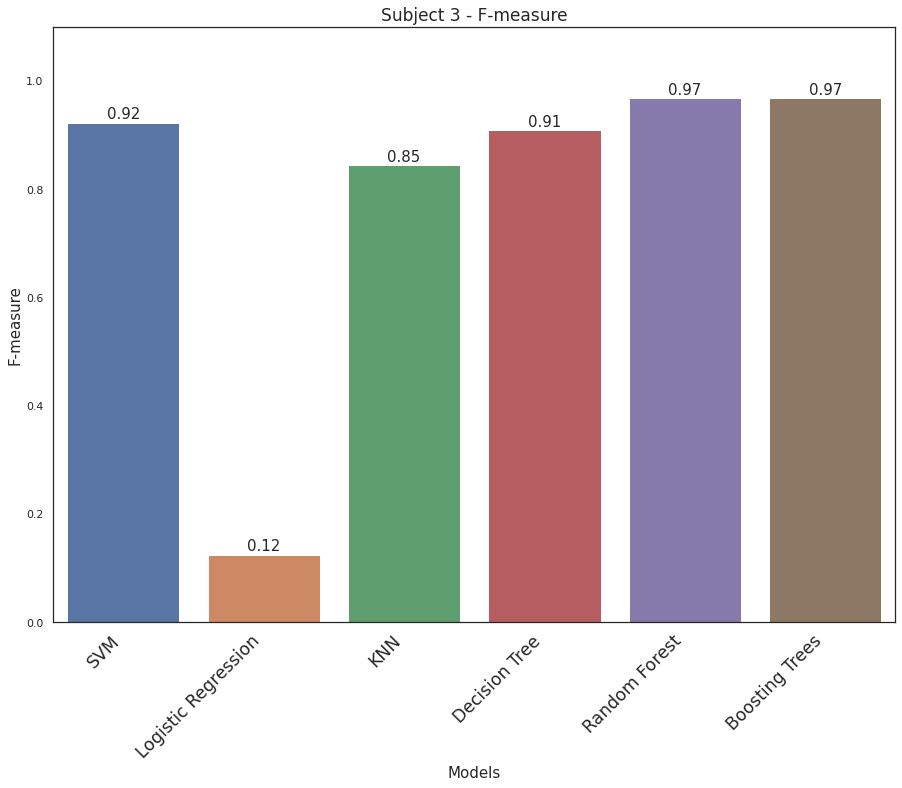

In [95]:
f_measure = [svmClfF3, lrF3, knnF3, dtF3, rfF3, xgbClfF3]
barPlot(f_measure, 'Subject 3 - F-measure', 'F-measure')

### Sensitivity

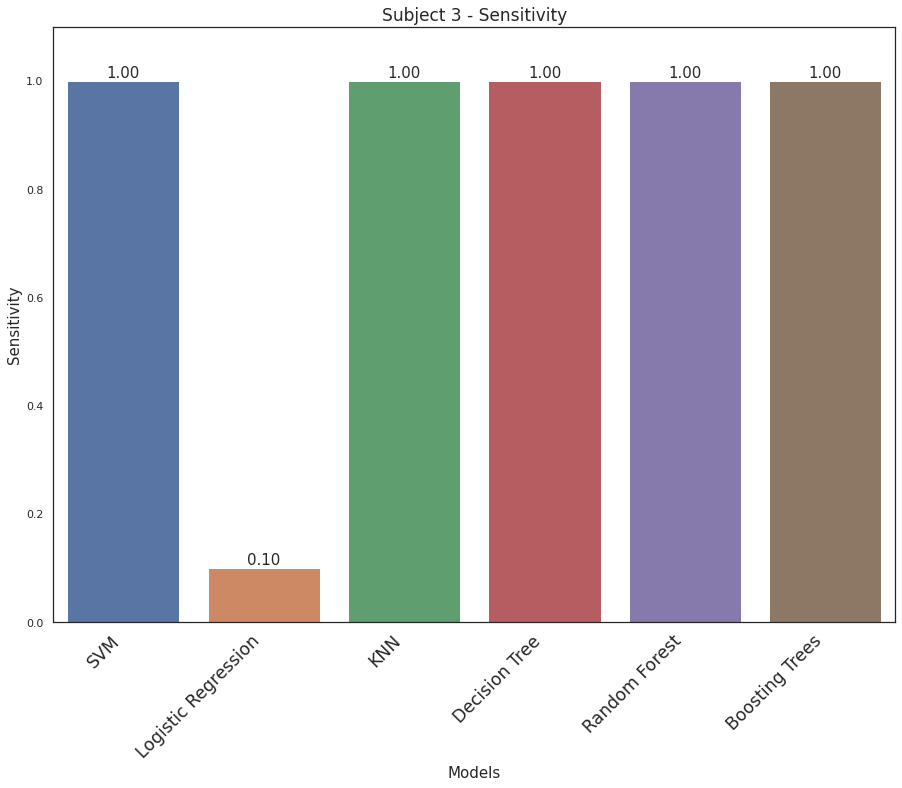

In [96]:
sens = [svmClfSens3, lrSens3, knnSens3, dtSens3, rfSens3, xgbClfSens3]
barPlot(sens, 'Subject 3 - Sensitivity', 'Sensitivity')

### Specificity

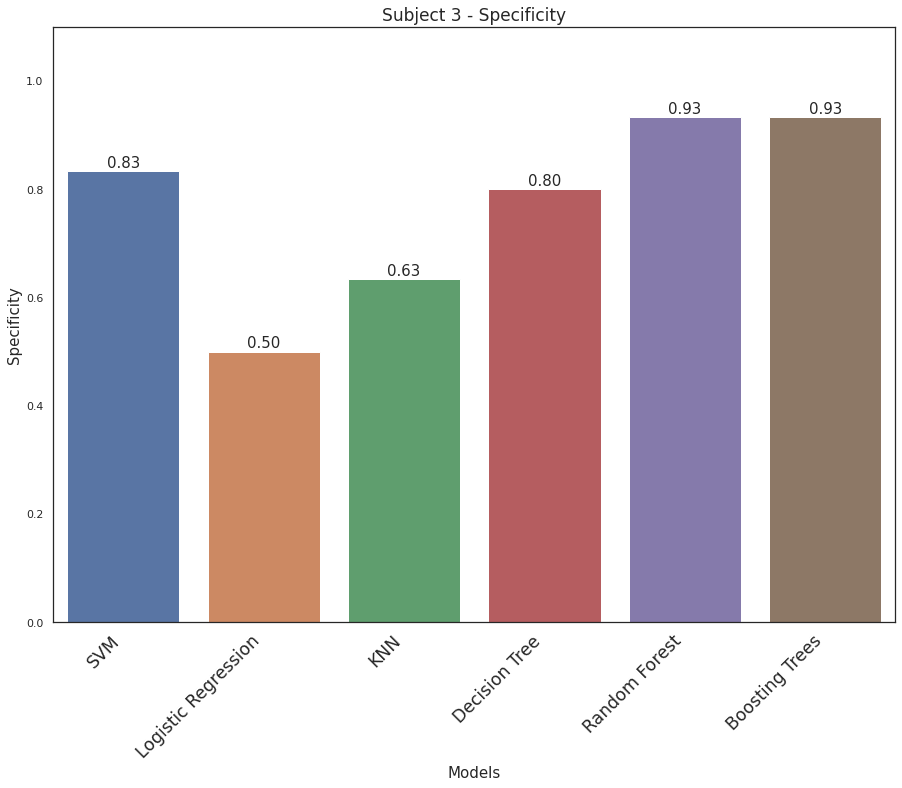

In [97]:
spec = [svmClfSpec3, lrSpec3, knnSpec3, dtSpec3, rfSpec3, xgbClfSpec3]
barPlot(spec, 'Subject 3 - Specificity', 'Specificity')

### Validation F-Measure

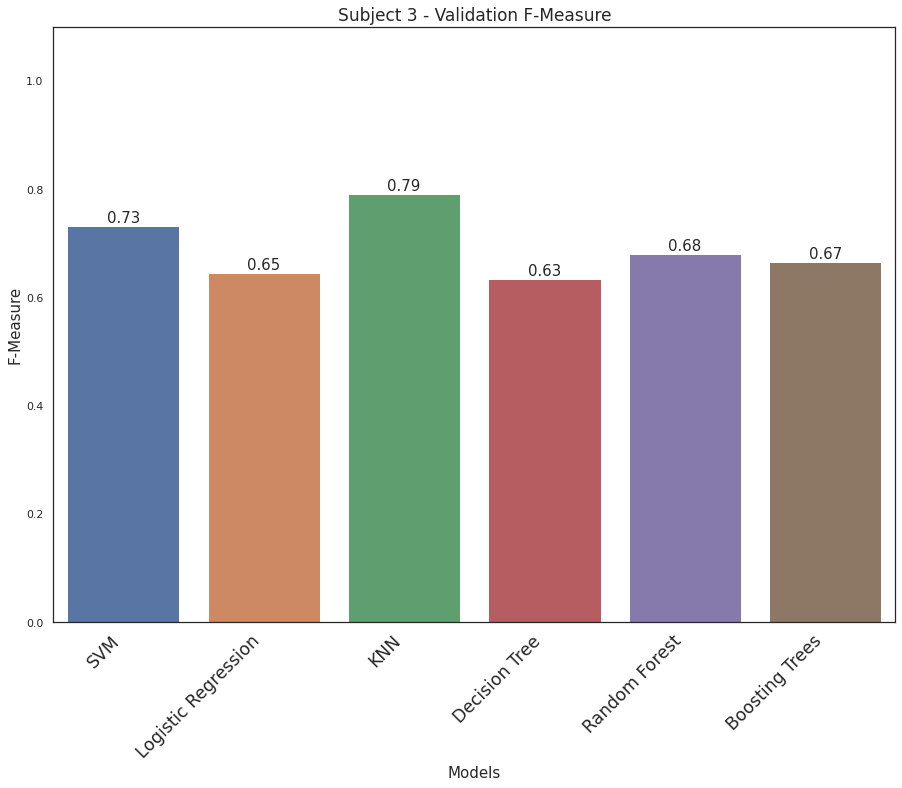

In [98]:
f_measure = [svmClfVF3, lrVF3, knnVF3, dtVF3, rfVF3, xgbClfVF3]
barPlot(f_measure, 'Subject 3 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.9166666666666666
f-measure: 0.923076923076923
Sensitivity: 1.0
Specificity: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.86      1.00      0.92        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



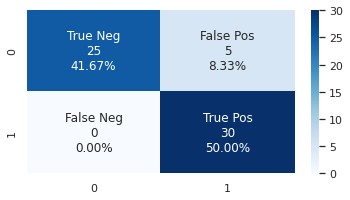

In [99]:
clf = [svmClf, rf, knn]
weights = np.array([svmClfVAcc3, rfVAcc3, knnVAcc3])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s3_3wv_acc, s3_3wv_f, s3_3wv_sens, s3_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.9333333333333333
f-measure: 0.9375
Sensitivity: 1.0
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



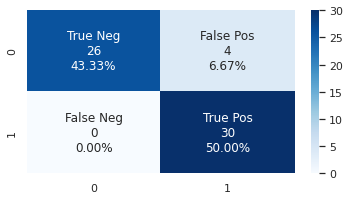

In [100]:
clf = [svmClf, rf, xgbClf, knn, lr]
weights = np.array([svmClfVAcc3, rfVAcc3, xgbClfVAcc3, knnVAcc3, lrVAcc3])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s3_5wv_acc, s3_5wv_f, s3_5wv_sens, s3_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.9
f-measure: 0.9090909090909091
Sensitivity: 1.0
Specificity: 0.8
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



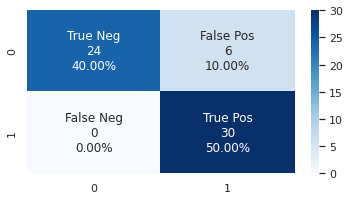

In [101]:
clf = [svmClf, rf, knn]
pred = MajorityVotingClassification(clf)
s3_3mv_acc, s3_3mv_f, s3_3mv_sens, s3_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.9333333333333333
f-measure: 0.9375
Sensitivity: 1.0
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



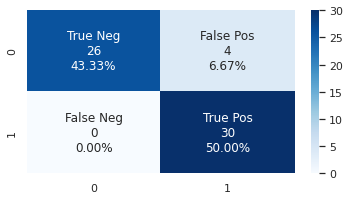

In [102]:
clf = [svmClf, rf, xgbClf, knn, lr]
pred = MajorityVotingClassification(clf)
s3_5mv_acc, s3_5mv_f, s3_5mv_sens, s3_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



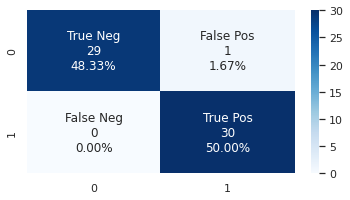

In [103]:
clf = [svmClf, rf, knn]
pred = UnanimousVotingClassification(clf)
s3_3uv_acc, s3_3uv_f, s3_3uv_sens, s3_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.55
f-measure: 0.18181818181818182
Sensitivity: 0.1
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



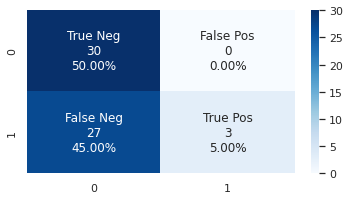

In [104]:
clf = [svmClf, rf, xgbClf, knn, lr]
pred = UnanimousVotingClassification(clf)
s3_5uv_acc, s3_5uv_f, s3_5uv_sens, s3_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

## Metrics

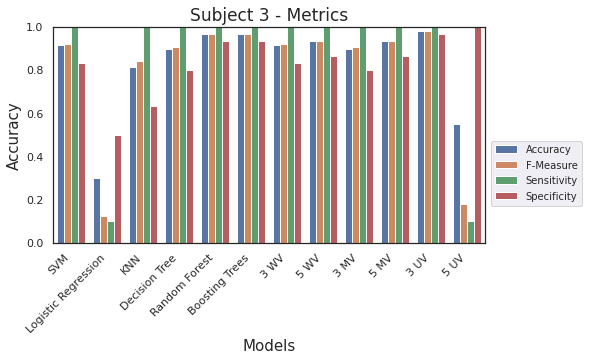

In [105]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc3, lrAcc3, knnAcc3, dtAcc3, rfAcc3, xgbClfAcc3, s3_3wv_acc, s3_5wv_acc, s3_3mv_acc, s3_5mv_acc, s3_3uv_acc, s3_5uv_acc, svmClfF3, lrF3, knnF3, dtF3, rfF3, xgbClfF3, s3_3wv_f, s3_5wv_f, s3_3mv_f, s3_5mv_f, s3_3uv_f, s3_5uv_f, svmClfSens3, lrSens3, knnSens3, dtSens3, rfSens3, xgbClfSens3, s3_3wv_sens, s3_5wv_sens, s3_3mv_sens, s3_5mv_sens, s3_3uv_sens, s3_5uv_sens, svmClfSpec3, lrSpec3, knnSpec3, dtSpec3, rfSpec3, xgbClfSpec3, s3_3wv_spec, s3_5wv_spec, s3_3mv_spec, s3_5mv_spec, s3_3uv_spec, s3_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 3 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Fold 4

In [106]:
df_train = pd.read_csv('Fold_4_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_4_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [107]:
df_train_master, df_val_master = createMasterTrainVal(4, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(4, 9, df_train_master, df_val_master)

## Metrics and Optimisations

### SVM

In [108]:
optimisationSVM(4)

10000.1 (0.7413418530068581, 0.7777777777777779)


{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5443393273287316, 0.45370370370370366),
 '0.10.1': (0.4553374010476683, 0.5296296296296297),
 '0.11': (0.2852438477438477, 0.5351851851851852),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5374774804743809, 0.4351851851851852),
 '10.01': (0.5784896952823748, 0.5333333333333334),
 '10.1': (0.49664794194169937, 0.6037037037037036),
 '100.0001': (0.015151515151515154, 0.42962962962962964),
 '100.001': (0.5025150323522838, 0.46851851851851856),
 '100.01': (0.4928102963873556, 0.5888888888888889),
 '100.1': (0.3626819245054975, 0.5629629629629629),
 '1000.0001': (0.46494668330417116, 0.49444444444444446),
 '1000.001': (0.4843816893524495, 0.537037037037037),
 '1000.01': (0.5026879163230653, 0.6148148148148148),
 '1000.1': (0.4721770140355271, 0.6296296296296297),
 '10000.0001': (0.49370293814738253, 0.55),
 '10000.001': (0.5050282341381191, 0.5777777777777777),
 '10000.01': (0.43889259667

### Logistic Regression

In [109]:
optimisationLr(4)

l20.08858667904100823liblinearFalse (0.48587618559212586, 0.5296296296296297)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearTrue': (0.0, 0.4444444444444444),
 'l10.08858667904100823liblinearFalse': (0.1620239033359601,
  0.327777777777

### KNN

In [110]:
optimisationKnn(4)

10distancebrute451 (0.7210767516063941, 0.7537037037037037)


{'10distanceauto1001': (0.7210767516063941, 0.7537037037037037),
 '10distanceauto152': (0.6435727169602162, 0.7074074074074075),
 '10distanceauto602': (0.6435727169602162, 0.7074074074074075),
 '10distanceball_tree152': (0.6469540807776102, 0.712962962962963),
 '10distanceball_tree452': (0.6435727169602162, 0.7074074074074075),
 '10distancebrute1001': (0.7210767516063941, 0.7537037037037037),
 '10distancebrute451': (0.7210767516063941, 0.7537037037037037),
 '10distancebrute751': (0.7210767516063941, 0.7537037037037037),
 '10distancebrute752': (0.6435727169602162, 0.7074074074074075),
 '10distancekd_tree302': (0.6435727169602162, 0.7074074074074075),
 '10uniformauto1001': (0.2812579281569051, 0.5148148148148148),
 '10uniformauto1002': (0.29632651917222275, 0.5148148148148148),
 '10uniformauto152': (0.29632651917222275, 0.5148148148148148),
 '10uniformauto451': (0.2812579281569051, 0.5148148148148148),
 '10uniformball_tree1001': (0.2832401301391071, 0.5240740740740741),
 '10uniformball_t

### Decision Tree

In [111]:
dtVF4, dtVAcc4 = metricsDecisionTree(4)
dtVF4, dtVAcc4

(0.6452386745971876, 0.7092592592592593)

### Random Forest

In [112]:
rfVF4, rfVAcc4 = metricsRandomForest(4)
rfVF4, rfVAcc4

(0.676879276968795, 0.7574074074074074)

### Xgboost

In [113]:
xgbClfVF4, xgbClfVAcc4 = metricsXgb(4)
xgbClfVF4, xgbClfVAcc4

(0.670759799757411, 0.7518518518518519)

## Model Training

### SVM

Accuracy: 0.9
f-measure: 0.9090909090909091
Sensitivity: 1.0
Specificity: 0.8
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



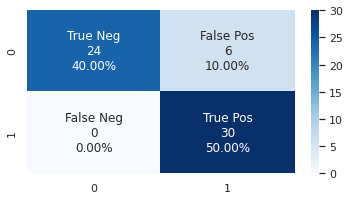

In [114]:
svmClfVF4 = 0.7413418530068581
svmClfVAcc4 = 0.7777777777777779
svmClf = svm.SVC(C = 1000, gamma = 0.1, kernel='rbf', probability=True, random_state=31)
svmClfAcc4, svmClfF4, svmClfSens4, svmClfSpec4 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.7666666666666667
f-measure: 0.8108108108108109
Sensitivity: 1.0
Specificity: 0.5333333333333333
              precision    recall  f1-score   support

           0       1.00      0.53      0.70        30
           1       0.68      1.00      0.81        30

    accuracy                           0.77        60
   macro avg       0.84      0.77      0.75        60
weighted avg       0.84      0.77      0.75        60



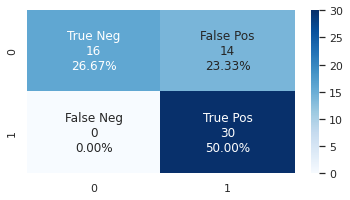

In [115]:
lrVF4, lrVAcc4 = (0.48587618559212586, 0.5296296296296297)
lr = LogisticRegression(penalty='l2', C=0.08858667904100823, solver='liblinear', fit_intercept=False, random_state=31)
lrAcc4, lrF4, lrSens4, lrSpec4 = userModel(lr)

### KNN

Accuracy: 0.8833333333333333
f-measure: 0.8955223880597014
Sensitivity: 1.0
Specificity: 0.7666666666666667
              precision    recall  f1-score   support

           0       1.00      0.77      0.87        30
           1       0.81      1.00      0.90        30

    accuracy                           0.88        60
   macro avg       0.91      0.88      0.88        60
weighted avg       0.91      0.88      0.88        60



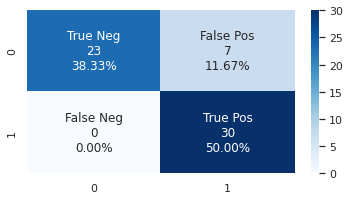

In [116]:
knnVF4, knnVAcc4 = (0.7210767516063941, 0.7537037037037037)
knn = KNeighborsClassifier(n_neighbors=10, weights='distance', algorithm='brute', leaf_size=45, p=1)
knnAcc4, knnF4, knnSens4, knnSpec4 = userModel(knn)

### Decision Tree

Accuracy: 0.85
f-measure: 0.8695652173913044
Sensitivity: 1.0
Specificity: 0.7
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        30
           1       0.77      1.00      0.87        30

    accuracy                           0.85        60
   macro avg       0.88      0.85      0.85        60
weighted avg       0.88      0.85      0.85        60



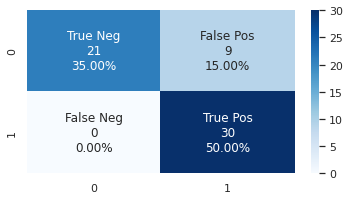

In [117]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc4, dtF4, dtSens4, dtSpec4 = userModel(dt)

### Random Forest

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



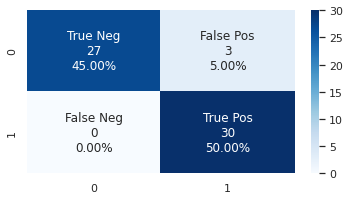

In [118]:
rf = RandomForestClassifier(random_state=31)
rfAcc4, rfF4, rfSens4, rfSpec4 = userModel(rf)

### Boosting

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



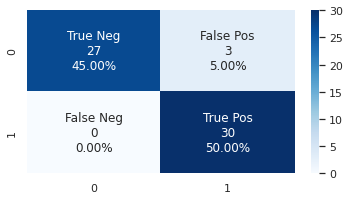

In [119]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc4, xgbClfF4, xgbClfSens4, xgbClfSpec4 = userModel(xgbClf)

## Plots

### Accuracy

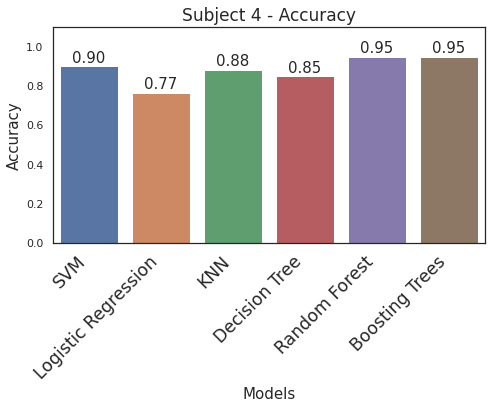

In [120]:
accuracies = [svmClfAcc4, lrAcc4, knnAcc4, dtAcc4, rfAcc4, xgbClfAcc4]
barPlot(accuracies, 'Subject 4 - Accuracy', 'Accuracy')

### F-Measure

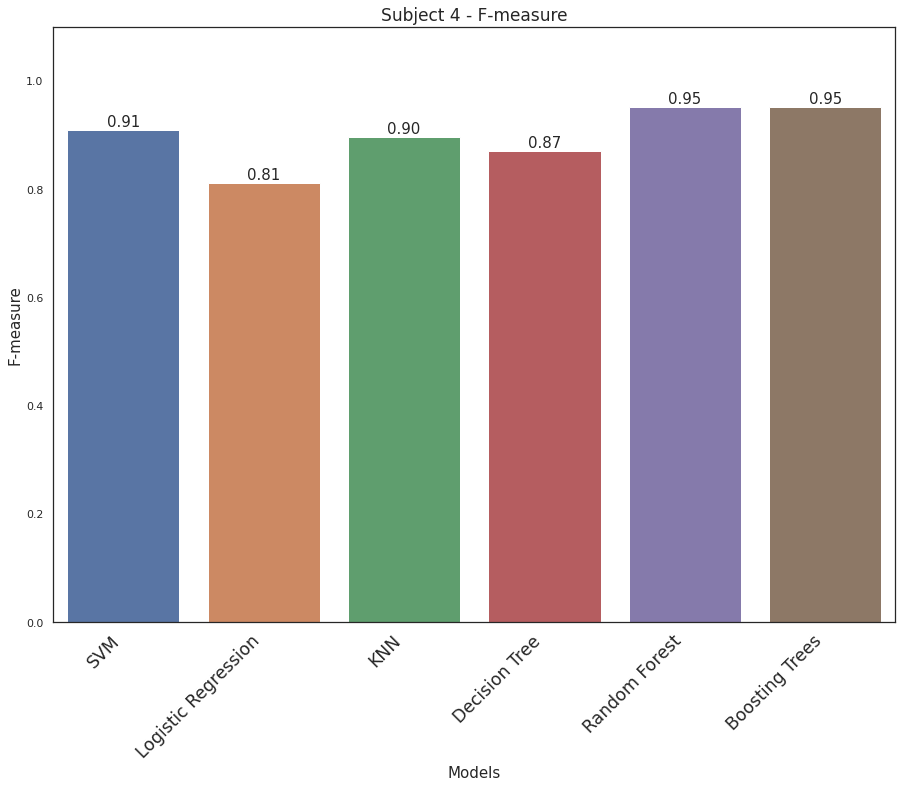

In [121]:
f_measure = [svmClfF4, lrF4, knnF4, dtF4, rfF4, xgbClfF4]
barPlot(f_measure, 'Subject 4 - F-measure', 'F-measure')

### Sensitivity

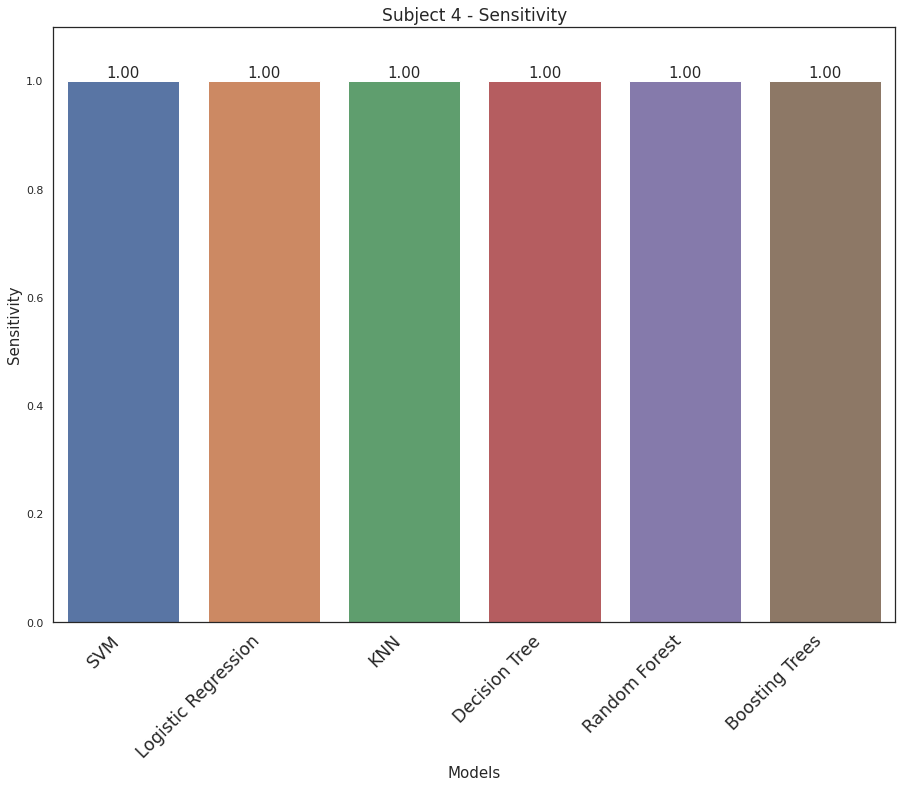

In [122]:
sens = [svmClfSens4, lrSens4, knnSens4, dtSens4, rfSens4, xgbClfSens4]
barPlot(sens, 'Subject 4 - Sensitivity', 'Sensitivity')

### Specificity

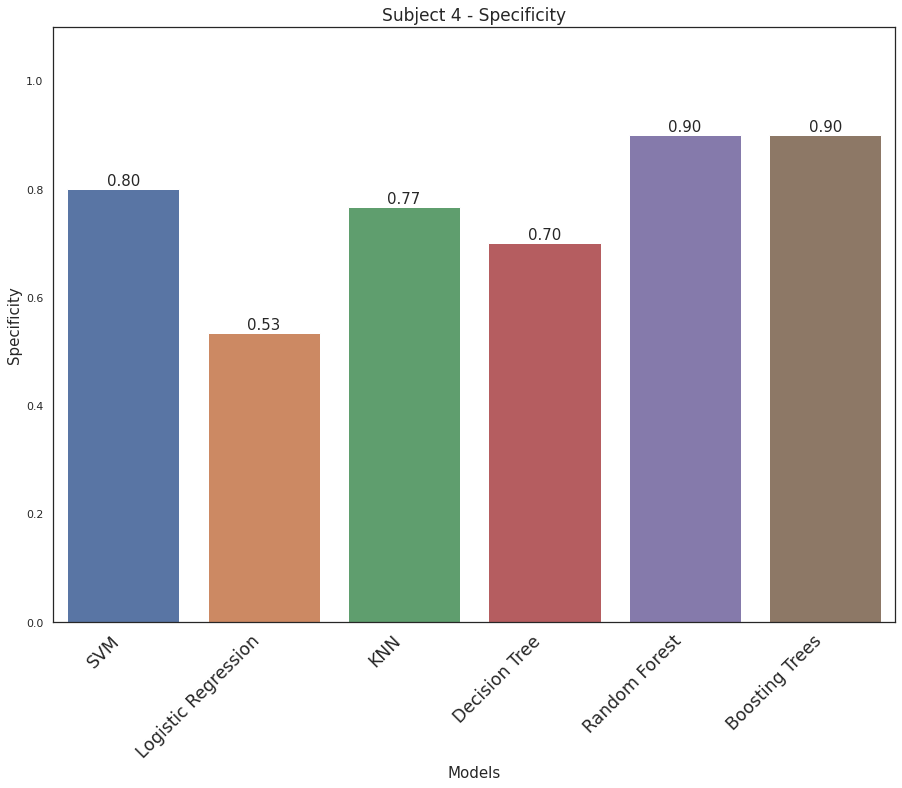

In [123]:
spec = [svmClfSpec4, lrSpec4, knnSpec4, dtSpec4, rfSpec4, xgbClfSpec4]
barPlot(spec, 'Subject 4 - Specificity', 'Specificity')

### Validation F-Measure

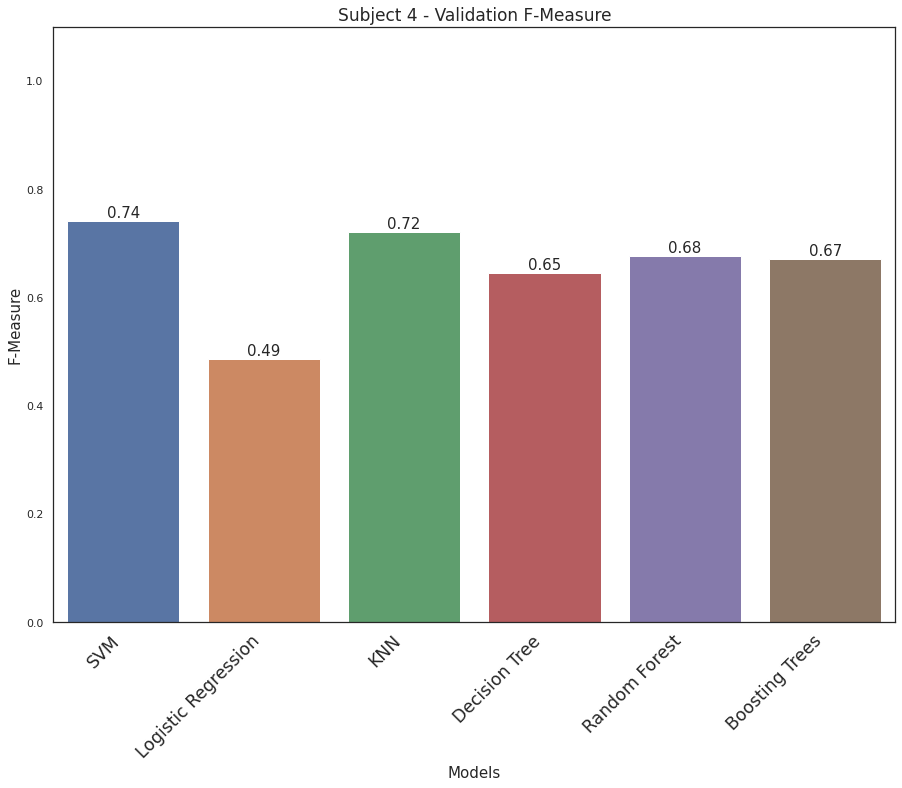

In [124]:
f_measure = [svmClfVF4, lrVF4, knnVF4, dtVF4, rfVF4, xgbClfVF4]
barPlot(f_measure, 'Subject 4 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.9
f-measure: 0.9090909090909091
Sensitivity: 1.0
Specificity: 0.8
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



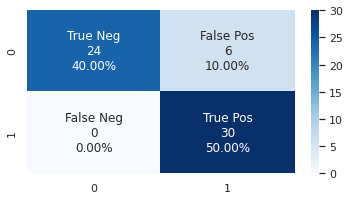

In [125]:
clf = [svmClf, rf, knn]
weights = np.array([svmClfVAcc4, rfVAcc4, knnVAcc4])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s4_3wv_acc, s4_3wv_f, s4_3wv_sens, s4_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.9166666666666666
f-measure: 0.923076923076923
Sensitivity: 1.0
Specificity: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.86      1.00      0.92        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



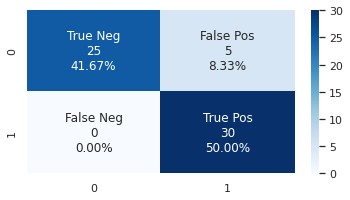

In [126]:
clf = [svmClf, rf, xgbClf, knn, dt]
weights = np.array([svmClfVAcc4, rfVAcc4, xgbClfVAcc4, knnVAcc4, dtVAcc4])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s4_5wv_acc, s4_5wv_f, s4_5wv_sens, s4_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.9333333333333333
f-measure: 0.9375
Sensitivity: 1.0
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



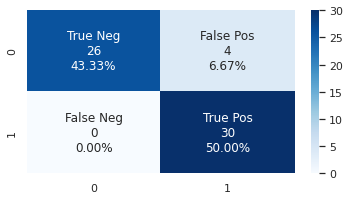

In [127]:
clf = [svmClf, rf, knn]
pred = MajorityVotingClassification(clf)
s4_3mv_acc, s4_3mv_f, s4_3mv_sens, s4_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



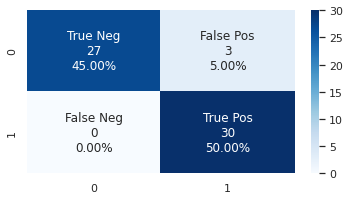

In [128]:
clf = [svmClf, rf, xgbClf, knn, dt]
pred = MajorityVotingClassification(clf)
s4_5mv_acc, s4_5mv_f, s4_5mv_sens, s4_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



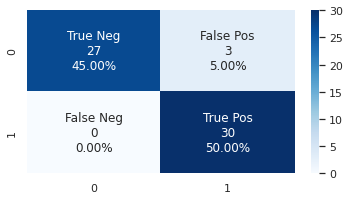

In [129]:
clf = [svmClf, rf, knn]

pred = UnanimousVotingClassification(clf)
s4_3uv_acc, s4_3uv_f, s4_3uv_sens, s4_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



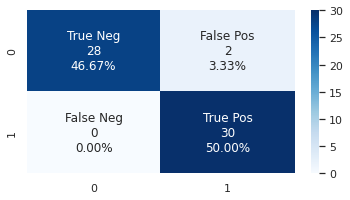

In [130]:
clf = [svmClf, rf, xgbClf, knn, dt]
pred = UnanimousVotingClassification(clf)
s4_5uv_acc, s4_5uv_f, s4_5uv_sens, s4_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

## Metrics

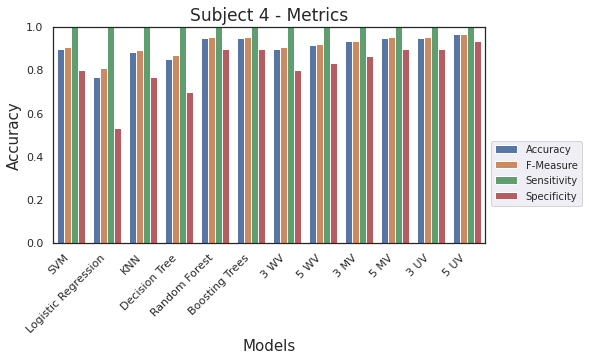

In [131]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc4, lrAcc4, knnAcc4, dtAcc4, rfAcc4, xgbClfAcc4, s4_3wv_acc, s4_5wv_acc, s4_3mv_acc, s4_5mv_acc, s4_3uv_acc, s4_5uv_acc, svmClfF4, lrF4, knnF4, dtF4, rfF4, xgbClfF4, s4_3wv_f, s4_5wv_f, s4_3mv_f, s4_5mv_f, s4_3uv_f, s4_5uv_f, svmClfSens4, lrSens4, knnSens4, dtSens4, rfSens4, xgbClfSens4, s4_3wv_sens, s4_5wv_sens, s4_3mv_sens, s4_5mv_sens, s4_3uv_sens, s4_5uv_sens, svmClfSpec4, lrSpec4, knnSpec4, dtSpec4, rfSpec4, xgbClfSpec4, s4_3wv_spec, s4_5wv_spec, s4_3mv_spec, s4_5mv_spec, s4_3uv_spec, s4_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 4 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Fold 5

In [132]:
df_train = pd.read_csv('Fold_5_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_5_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [133]:
df_train_master, df_val_master = createMasterTrainVal(5, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(5, 9, df_train_master, df_val_master)

## Metrics and SVM Optimisations

### SVM

In [134]:
optimisationSVM(5)

101 (0.6546975739166068, 0.7277777777777779)


{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5255436917543621, 0.4537037037037038),
 '0.10.1': (0.616215477649429, 0.5833333333333333),
 '0.11': (0.2783793408793409, 0.5185185185185186),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.14913252122554446, 0.45000000000000007),
 '10.01': (0.6095748928552942, 0.5759259259259258),
 '10.1': (0.5811609065859769, 0.6407407407407407),
 '100.0001': (0.0, 0.42962962962962964),
 '100.001': (0.6089956537334995, 0.5851851851851851),
 '100.01': (0.5744261098813879, 0.624074074074074),
 '100.1': (0.529669853199265, 0.6407407407407407),
 '1000.0001': (0.5293433189933079, 0.55),
 '1000.001': (0.4627659433350103, 0.5629629629629629),
 '1000.01': (0.41788766788766785, 0.5333333333333334),
 '1000.1': (0.4647990505817122, 0.6203703703703705),
 '10000.0001': (0.3740692015339902, 0.5148148148148148),
 '10000.001': (0.4070969460061739, 0.512962962962963),
 '10000.01': (0.2735503993624946, 0.47962962962962

### Logistic Regression

In [135]:
optimisationLr(5)

l20.23357214690901212liblinearFalse (0.6385127916068719, 0.6259259259259259)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearTrue': (0.0, 0.4444444444444444),
 'l10.08858667904100823liblinearFalse': (0.5434467217075913,
  0.555555555555

### KNN

In [136]:
optimisationKnn(5)

20distanceball_tree302 (0.7825361922508234, 0.7685185185185186)


{'10distanceauto1001': (0.646683459008529, 0.7092592592592593),
 '10distanceauto152': (0.6441826691826692, 0.7037037037037037),
 '10distanceauto602': (0.6441826691826692, 0.7037037037037037),
 '10distanceball_tree152': (0.6457366707366707, 0.7055555555555556),
 '10distanceball_tree452': (0.6457366707366707, 0.7055555555555556),
 '10distancebrute1001': (0.646683459008529, 0.7092592592592593),
 '10distancebrute451': (0.646683459008529, 0.7092592592592593),
 '10distancebrute751': (0.646683459008529, 0.7092592592592593),
 '10distancebrute752': (0.6441826691826692, 0.7037037037037037),
 '10distancekd_tree302': (0.6441826691826692, 0.7037037037037037),
 '10uniformauto1001': (0.11464070308742966, 0.42037037037037034),
 '10uniformauto1002': (0.293762935868199, 0.5111111111111112),
 '10uniformauto152': (0.293762935868199, 0.5111111111111112),
 '10uniformauto451': (0.11464070308742966, 0.42037037037037034),
 '10uniformball_tree1001': (0.11597505808032126, 0.4259259259259259),
 '10uniformball_tre

### Decision Tree

In [137]:
dtVF5, dtVAcc5 = metricsDecisionTree(5)
dtVF5, dtVAcc5

(0.7238454122257113, 0.7555555555555556)

### Random Forest

In [138]:
rfVF5, rfVAcc5 = metricsRandomForest(5)
rfVF5, rfVAcc5

(0.6763309135252461, 0.7555555555555555)

### Xgboost

In [139]:
xgbClfVF5, xgbClfVAcc5 = metricsXgb(5)
xgbClfVF5, xgbClfVAcc5

(0.6716123054752329, 0.7518518518518519)

## Model Training

### SVM

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



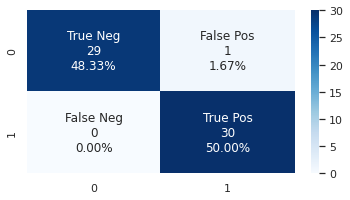

In [140]:
svmClfVF5 = 0.6546975739166068
svmClfVAcc5 = 0.7277777777777779
svmClf = svm.SVC(C = 10, gamma = 1, kernel='rbf', probability=True, random_state=31)
svmClfAcc5, svmClfF5, svmClfSens5, svmClfSpec5 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.35
f-measure: 0.13333333333333333
Sensitivity: 0.1
Specificity: 0.6
              precision    recall  f1-score   support

           0       0.40      0.60      0.48        30
           1       0.20      0.10      0.13        30

    accuracy                           0.35        60
   macro avg       0.30      0.35      0.31        60
weighted avg       0.30      0.35      0.31        60



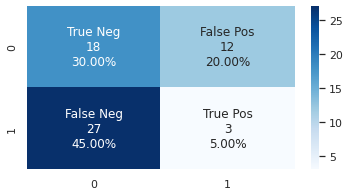

In [141]:
lrVF5, lrVAcc5 = (0.6385127916068719, 0.6259259259259259)
lr = LogisticRegression(penalty='l2', C=0.23357214690901212, solver='liblinear', fit_intercept=False, random_state=31)
lrAcc5, lrF5, lrSens5, lrSpec5 = userModel(lr)

### KNN

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



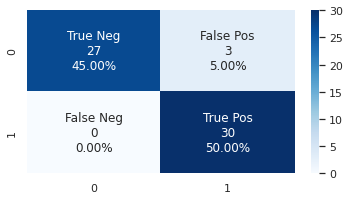

In [142]:
knnVF5, knnVAcc5 = (0.7825361922508234, 0.7685185185185186)
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='ball_tree', leaf_size=30, p=2)
knnAcc5, knnF5, knnSens5, knnSpec5 = userModel(knn)

### Decision Tree

Accuracy: 0.9333333333333333
f-measure: 0.9375
Sensitivity: 1.0
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



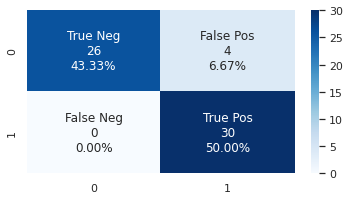

In [143]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc5, dtF5, dtSens5, dtSpec5 = userModel(dt)

### Random Forest

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



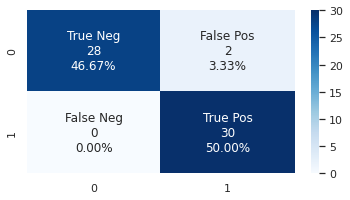

In [144]:
rf = RandomForestClassifier(random_state=31)
rfAcc5, rfF5, rfSens5, rfSpec5 = userModel(rf)

### Boosting

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



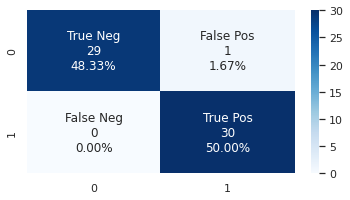

In [145]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc5, xgbClfF5, xgbClfSens5, xgbClfSpec5 = userModel(xgbClf)

## Plots

### Accuracy

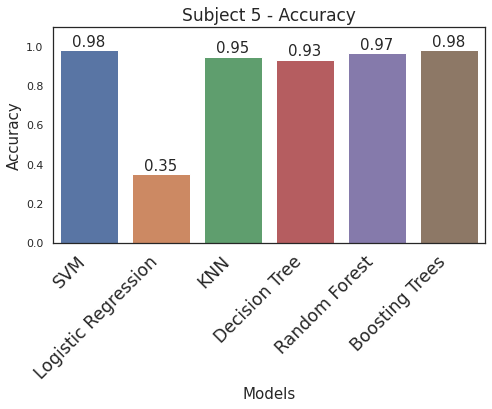

In [146]:
accuracies = [svmClfAcc5, lrAcc5, knnAcc5, dtAcc5, rfAcc5, xgbClfAcc5]
barPlot(accuracies, 'Subject 5 - Accuracy', 'Accuracy')

### F-Measure

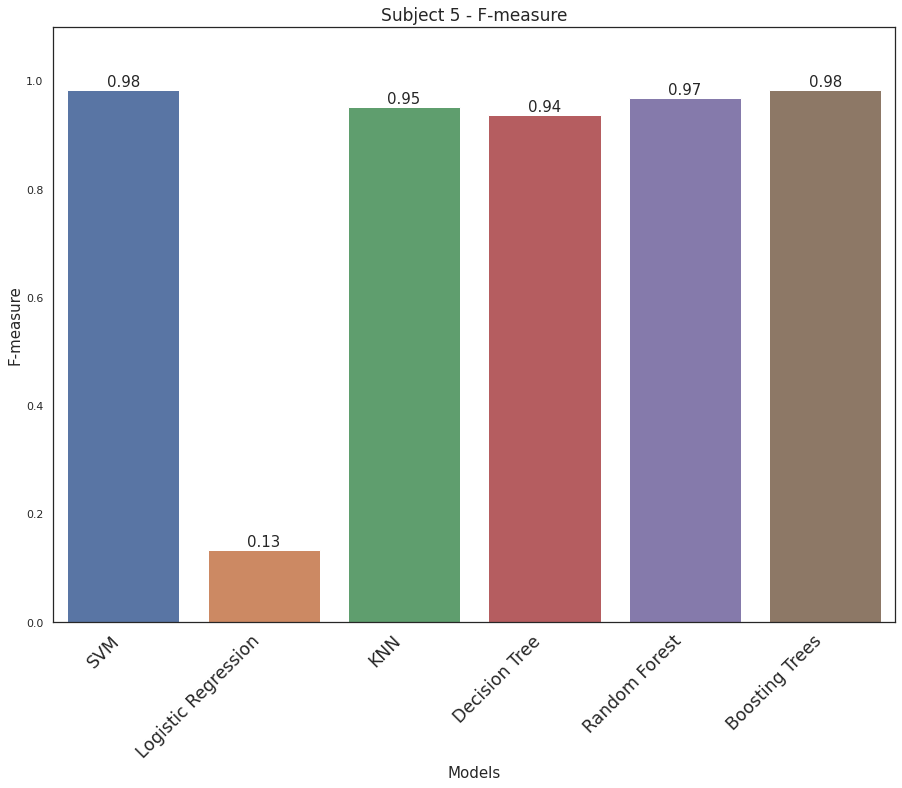

In [147]:
f_measure = [svmClfF5, lrF5, knnF5, dtF5, rfF5, xgbClfF5]
barPlot(f_measure, 'Subject 5 - F-measure', 'F-measure')

### Sensitivity

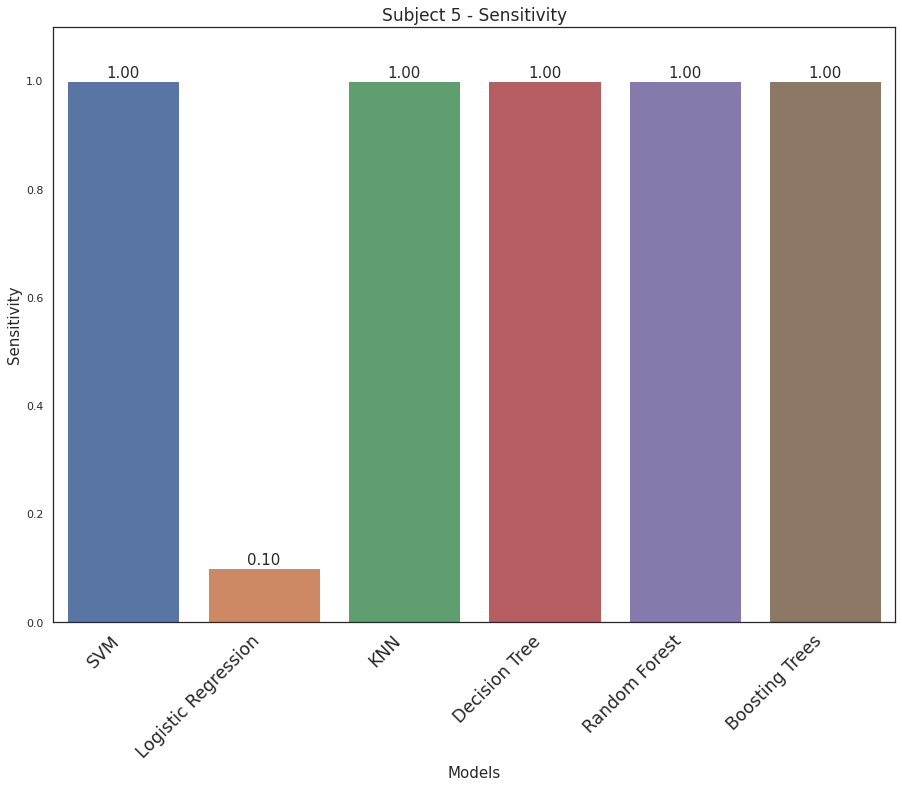

In [148]:
sens = [svmClfSens5, lrSens5, knnSens5, dtSens5, rfSens5, xgbClfSens5]
barPlot(sens, 'Subject 5 - Sensitivity', 'Sensitivity')

### Specificity

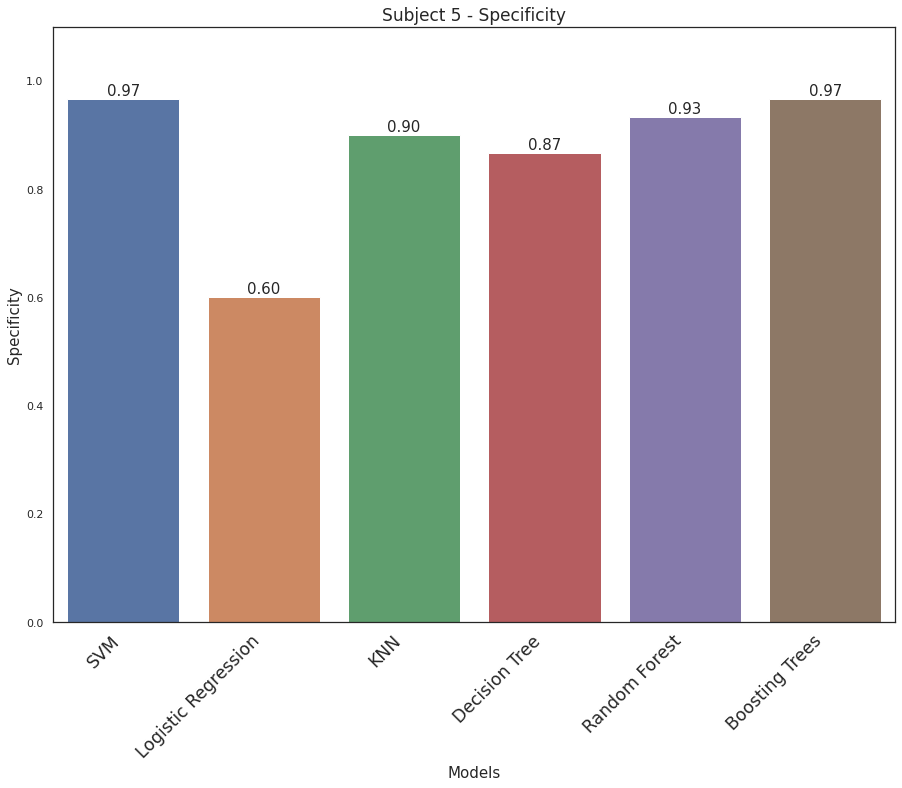

In [149]:
spec = [svmClfSpec5, lrSpec5, knnSpec5, dtSpec5, rfSpec5, xgbClfSpec5]
barPlot(spec, 'Subject 5 - Specificity', 'Specificity')

### Validation F-Measure

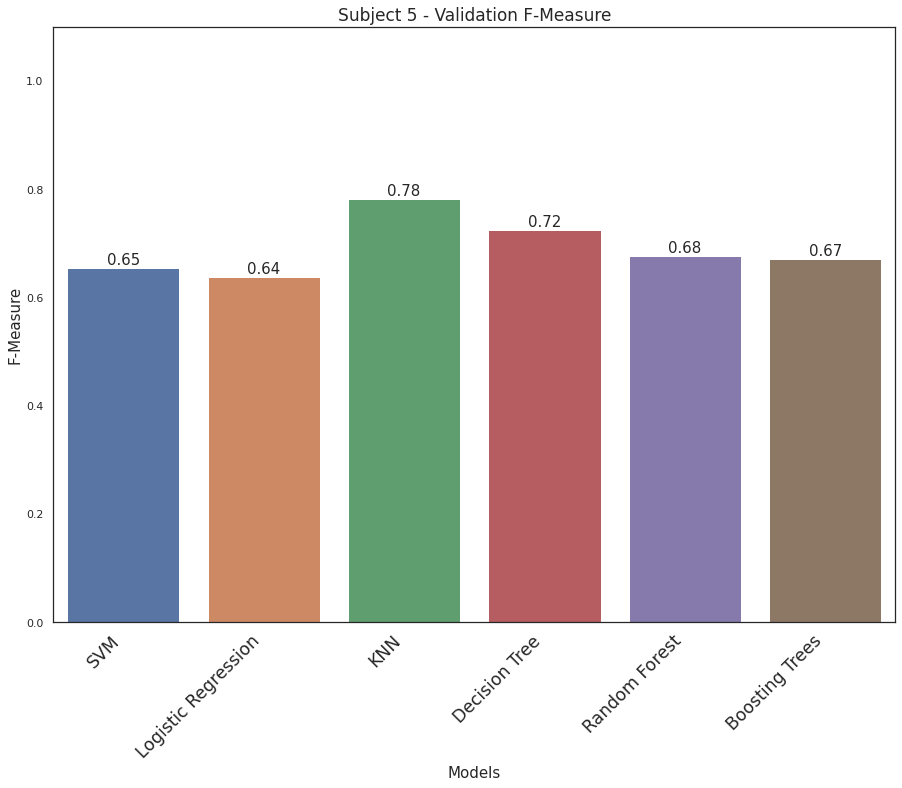

In [150]:
f_measure = [svmClfVF5, lrVF5, knnVF5, dtVF5, rfVF5, xgbClfVF5]
barPlot(f_measure, 'Subject 5 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.9333333333333333
f-measure: 0.9375
Sensitivity: 1.0
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



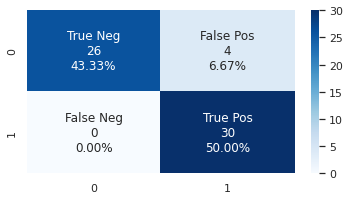

In [151]:
clf = [dt, rf, knn]
weights = np.array([dtVAcc5, rfVAcc5, knnVAcc5])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s5_3wv_acc, s5_3wv_f, s5_3wv_sens, s5_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



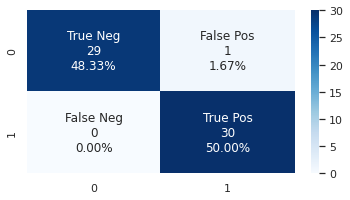

In [152]:
clf = [dt, rf, xgbClf, svmClf, knn]
weights = np.array([dtVAcc5, rfVAcc5, xgbClfVAcc5, svmClfVAcc5, knnVAcc5])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s5_5wv_acc, s5_5wv_f, s5_5wv_sens, s5_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



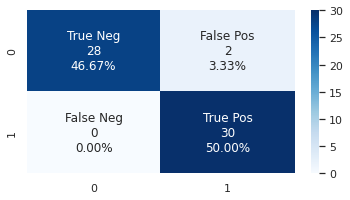

In [153]:
clf = [dt, rf, knn]
pred = MajorityVotingClassification(clf)
s5_3mv_acc, s5_3mv_f, s5_3mv_sens, s5_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



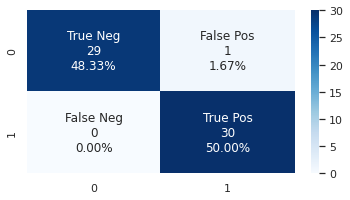

In [154]:
clf = [dt, rf, xgbClf, svmClf, knn]
pred = MajorityVotingClassification(clf)
s5_5mv_acc, s5_5mv_f, s5_5mv_sens, s5_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



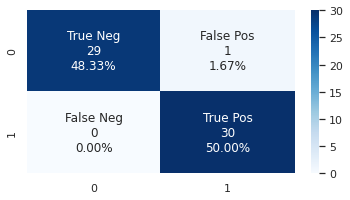

In [155]:
clf = [dt, rf, knn]
pred = UnanimousVotingClassification(clf)
s5_3uv_acc, s5_3uv_f, s5_3uv_sens, s5_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



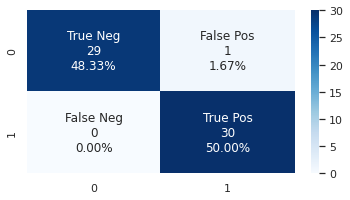

In [156]:
clf = [dt, rf, xgbClf, svmClf, knn]
pred = UnanimousVotingClassification(clf)
s5_5uv_acc, s5_5uv_f, s5_5uv_sens, s5_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

### Metrics

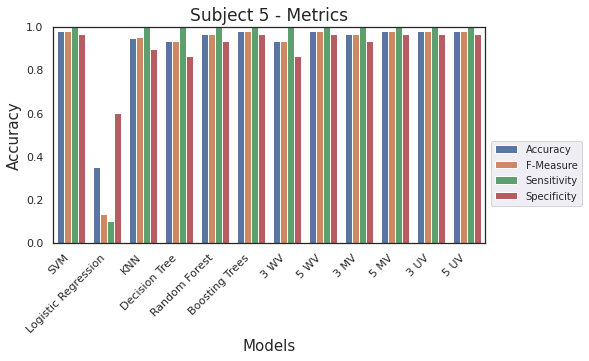

In [157]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc5, lrAcc5, knnAcc5, dtAcc5, rfAcc5, xgbClfAcc5, s5_3wv_acc, s5_5wv_acc, s5_3mv_acc, s5_5mv_acc, s5_3uv_acc, s5_5uv_acc, svmClfF5, lrF5, knnF5, dtF5, rfF5, xgbClfF5, s5_3wv_f, s5_5wv_f, s5_3mv_f, s5_5mv_f, s5_3uv_f, s5_5uv_f, svmClfSens5, lrSens5, knnSens5, dtSens5, rfSens5, xgbClfSens5, s5_3wv_sens, s5_5wv_sens, s5_3mv_sens, s5_5mv_sens, s5_3uv_sens, s5_5uv_sens, svmClfSpec5, lrSpec5, knnSpec5, dtSpec5, rfSpec5, xgbClfSpec5, s5_3wv_spec, s5_5wv_spec, s5_3mv_spec, s5_5mv_spec, s5_3uv_spec, s5_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 5 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Fold 6

In [158]:
df_train = pd.read_csv('Fold_6_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_6_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [159]:
df_train_master, df_val_master = createMasterTrainVal(6, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(6, 9, df_train_master, df_val_master)

## Metrics and Optimisations

### SVM

In [160]:
optimisationSVM(6)

1001 (0.6645926660581412, 0.7351851851851854)


{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.55654203103404, 0.4833333333333333),
 '0.10.1': (0.6205976774909999, 0.6055555555555555),
 '0.11': (0.12759121969648288, 0.43333333333333335),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5370358469308143, 0.4833333333333333),
 '10.01': (0.5203370289322178, 0.5203703703703704),
 '10.1': (0.5901980401609755, 0.6425925925925926),
 '100.0001': (0.19353108764873472, 0.43333333333333335),
 '100.001': (0.37762266667201366, 0.4388888888888889),
 '100.01': (0.4124465928437837, 0.5425925925925925),
 '100.1': (0.4493645839822747, 0.5888888888888889),
 '1000.0001': (0.29871513749096235, 0.4092592592592592),
 '1000.001': (0.3311213522343841, 0.4629629629629629),
 '1000.01': (0.3555081551037061, 0.501851851851852),
 '1000.1': (0.4648592758886877, 0.6166666666666667),
 '10000.0001': (0.3423169481993011, 0.47777777777777775),
 '10000.001': (0.4247928182434399, 0.5092592592592593),
 '10000.01': (0.3

### Logistic Regression

In [161]:
optimisationLr(6)

l20.23357214690901212liblinearFalse (0.48901922633107453, 0.5333333333333333)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.20024773937817417,
  0.412962962962963),
 'l10.03359818286283781liblinearTrue': (0.20024773937817417,
  0.412962962962963),
 'l10.08858667904100823liblinearFalse': (0.

### KNN

In [162]:
optimisationKnn(6)

80distancekd_tree751 (0.7479770654682596, 0.7166666666666667)


{'10distanceauto1001': (0.6458155478193429, 0.7092592592592593),
 '10distanceauto152': (0.642186702498726, 0.7037037037037037),
 '10distanceauto602': (0.642186702498726, 0.7037037037037037),
 '10distanceball_tree152': (0.6457710384180972, 0.7092592592592593),
 '10distanceball_tree452': (0.6437892666012901, 0.7055555555555556),
 '10distancebrute1001': (0.6458155478193429, 0.7092592592592593),
 '10distancebrute451': (0.6458155478193429, 0.7092592592592593),
 '10distancebrute751': (0.6458155478193429, 0.7092592592592593),
 '10distancebrute752': (0.642186702498726, 0.7037037037037037),
 '10distancekd_tree302': (0.6437892666012901, 0.7055555555555556),
 '10uniformauto1001': (0.19838590722737065, 0.46851851851851856),
 '10uniformauto1002': (0.27950880967377434, 0.5129629629629631),
 '10uniformauto152': (0.27950880967377434, 0.5129629629629631),
 '10uniformauto451': (0.19838590722737065, 0.46851851851851856),
 '10uniformball_tree1001': (0.1994441082855717, 0.4722222222222222),
 '10uniformball

### Decision Tree

In [163]:
dtVF6, dtVAcc6 = metricsDecisionTree(6)
dtVF6, dtVAcc6

(0.6358892826284132, 0.7000000000000001)

### Random Forest

In [164]:
rfVF6, rfVAcc6 = metricsRandomForest(6)
rfVF6, rfVAcc6

(0.6723623638599752, 0.7537037037037038)

### Xgboost

In [165]:
xgbClfVF6, xgbClfVAcc6 = metricsXgb(6)
xgbClfVF6, xgbClfVAcc6

(0.6705462913471814, 0.751851851851852)

## Model Training

### SVM

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



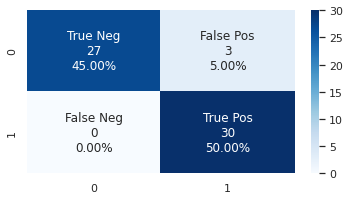

In [166]:
svmClfVF6 = 0.6645926660581412
svmClfVAcc6 = 0.7351851851851854
svmClf = svm.SVC(C = 100, gamma = 1, kernel='rbf', probability=True, random_state=31)
svmClfAcc6, svmClfF6, svmClfSens6, svmClfSpec6 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.7666666666666667
f-measure: 0.8108108108108109
Sensitivity: 1.0
Specificity: 0.5333333333333333
              precision    recall  f1-score   support

           0       1.00      0.53      0.70        30
           1       0.68      1.00      0.81        30

    accuracy                           0.77        60
   macro avg       0.84      0.77      0.75        60
weighted avg       0.84      0.77      0.75        60



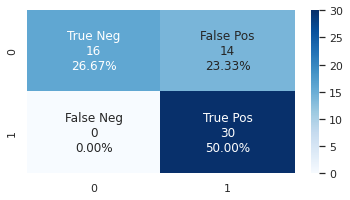

In [167]:
lrVF6, lrVAcc6 = (0.48901922633107453, 0.5333333333333333)
lr = LogisticRegression(penalty='l2', C=0.23357214690901212, solver='liblinear', fit_intercept=False, random_state=31)
lrAcc6, lrF6, lrSens6, lrSpec6 = userModel(lr)

### KNN

Accuracy: 0.7833333333333333
f-measure: 0.8219178082191781
Sensitivity: 1.0
Specificity: 0.5666666666666667
              precision    recall  f1-score   support

           0       1.00      0.57      0.72        30
           1       0.70      1.00      0.82        30

    accuracy                           0.78        60
   macro avg       0.85      0.78      0.77        60
weighted avg       0.85      0.78      0.77        60



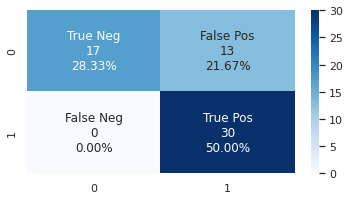

In [168]:
knnVF6, knnVAcc6 = (0.7479770654682596, 0.7166666666666667)
knn = KNeighborsClassifier(n_neighbors=80, weights='distance', algorithm='kd_tree', leaf_size=75, p=1)
knnAcc6, knnF6, knnSens6, knnSpec6 = userModel(knn)

### Decision Tree

Accuracy: 0.9166666666666666
f-measure: 0.923076923076923
Sensitivity: 1.0
Specificity: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.86      1.00      0.92        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



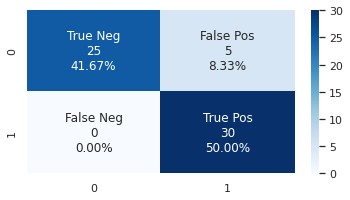

In [169]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc6, dtF6, dtSens6, dtSpec6 = userModel(dt)

### Random Forest

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



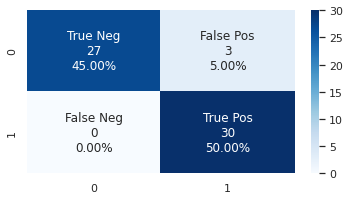

In [170]:
rf = RandomForestClassifier(random_state=31)
rfAcc6, rfF6, rfSens6, rfSpec6 = userModel(rf)

### Boosting

Accuracy: 0.9166666666666666
f-measure: 0.923076923076923
Sensitivity: 1.0
Specificity: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.86      1.00      0.92        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



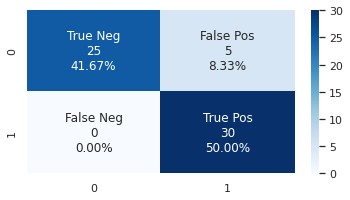

In [171]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc6, xgbClfF6, xgbClfSens6, xgbClfSpec6 = userModel(xgbClf)

## Plots

### Accuracy

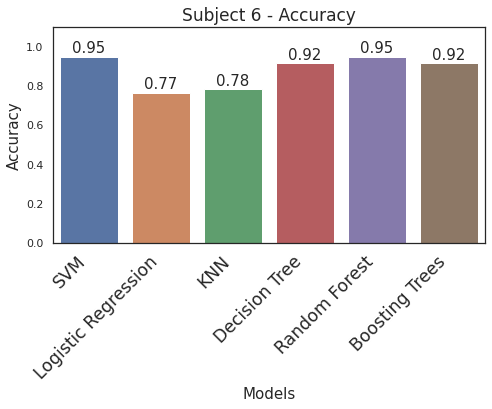

In [172]:
accuracies = [svmClfAcc6, lrAcc6, knnAcc6, dtAcc6, rfAcc6, xgbClfAcc6]
barPlot(accuracies, 'Subject 6 - Accuracy', 'Accuracy')

### F-Measure

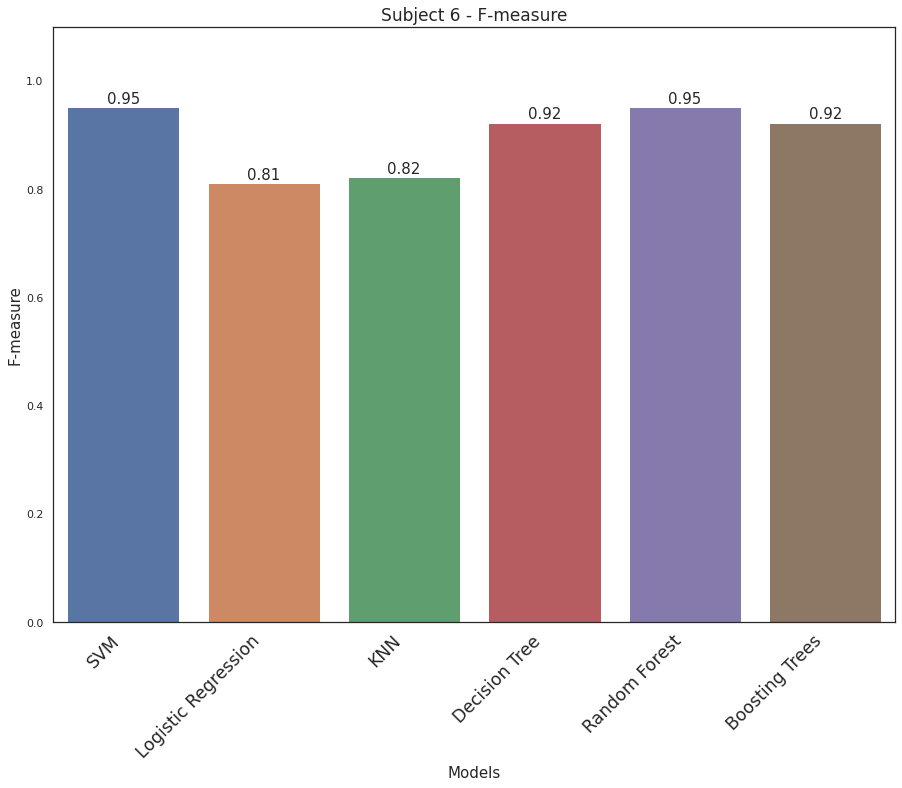

In [173]:
f_measure = [svmClfF6, lrF6, knnF6, dtF6, rfF6, xgbClfF6]
barPlot(f_measure, 'Subject 6 - F-measure', 'F-measure')

### Sensitivity

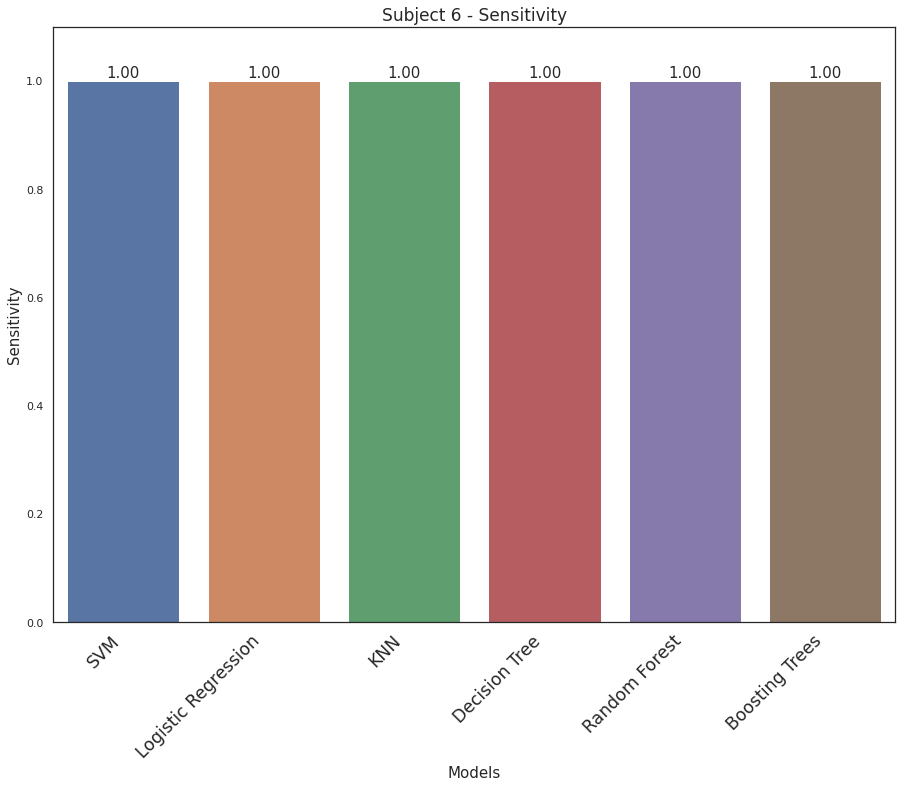

In [174]:
sens = [svmClfSens6, lrSens6, knnSens6, dtSens6, rfSens6, xgbClfSens6]
barPlot(sens, 'Subject 6 - Sensitivity', 'Sensitivity')

### Specificity

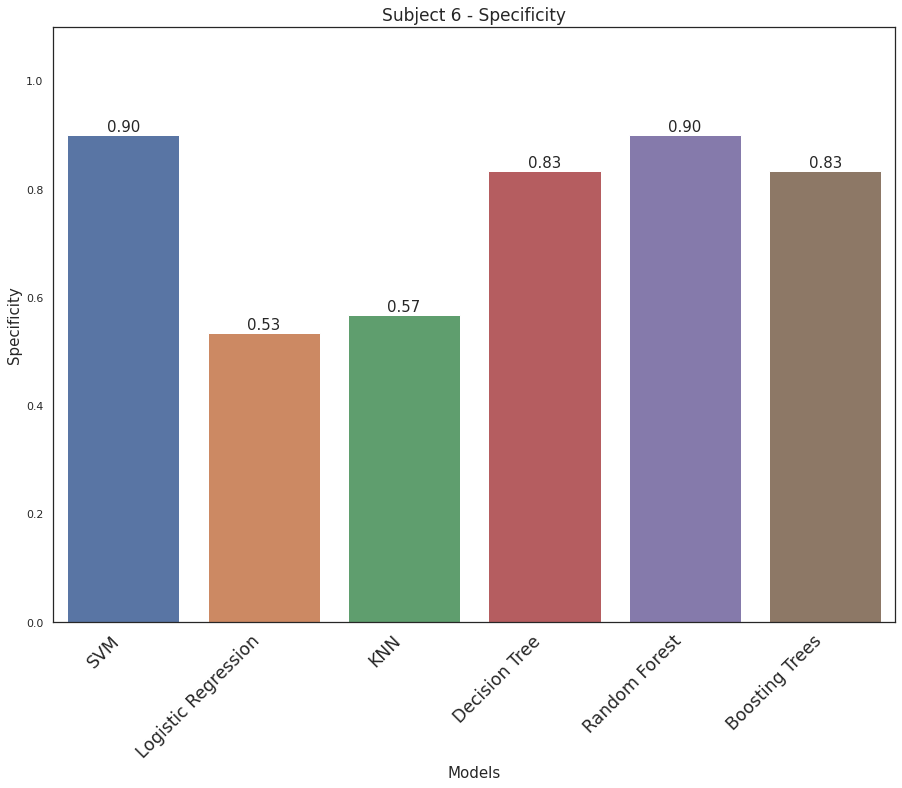

In [175]:
spec = [svmClfSpec6, lrSpec6, knnSpec6, dtSpec6, rfSpec6, xgbClfSpec6]
barPlot(spec, 'Subject 6 - Specificity', 'Specificity')

### Validation F-Measure

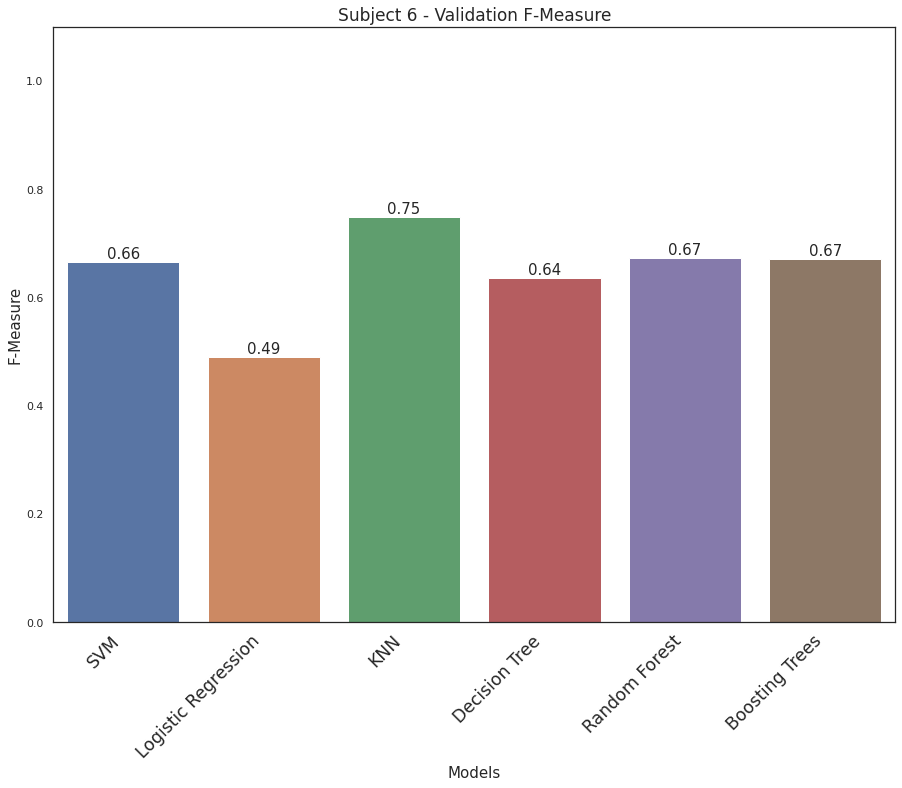

In [176]:
f_measure = [svmClfVF6, lrVF6, knnVF6, dtVF6, rfVF6, xgbClfVF6]
barPlot(f_measure, 'Subject 6 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.9
f-measure: 0.9090909090909091
Sensitivity: 1.0
Specificity: 0.8
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



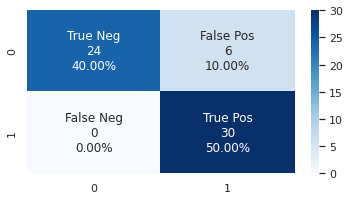

In [177]:
clf = [xgbClf, rf, knn]
weights = np.array([xgbClfVAcc6, rfVAcc6, knnVAcc6])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s6_3wv_acc, s6_3wv_f, s6_3wv_sens, s6_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



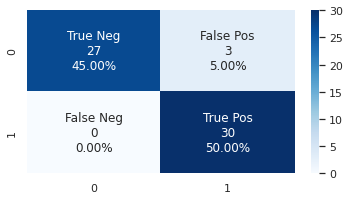

In [178]:
clf = [xgbClf, rf, svmClf, knn, dt]
weights = np.array([xgbClfVAcc6, rfVAcc6, svmClfVAcc6, knnVAcc6, dtVAcc6])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s6_5wv_acc, s6_5wv_f, s6_5wv_sens, s6_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.9166666666666666
f-measure: 0.923076923076923
Sensitivity: 1.0
Specificity: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.86      1.00      0.92        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



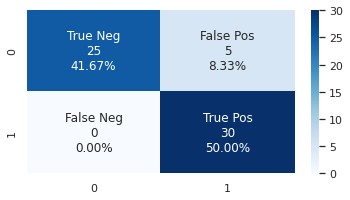

In [179]:
clf = [xgbClf, rf, knn]
pred = MajorityVotingClassification(clf)
s6_3mv_acc, s6_3mv_f, s6_3mv_sens, s6_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.9166666666666666
f-measure: 0.923076923076923
Sensitivity: 1.0
Specificity: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.86      1.00      0.92        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



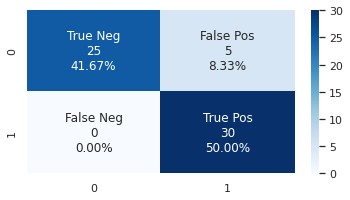

In [180]:
clf = [xgbClf, rf, svmClf, knn, dt]
pred = MajorityVotingClassification(clf)
s6_5mv_acc, s6_5mv_f, s6_5mv_sens, s6_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



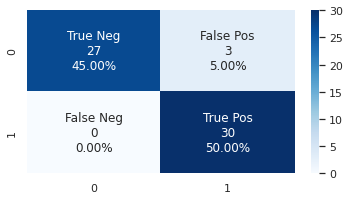

In [181]:
clf = [xgbClf, rf, knn]

pred = UnanimousVotingClassification(clf)
s6_3uv_acc, s6_3uv_f, s6_3uv_sens, s6_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



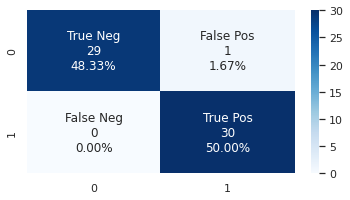

In [182]:
clf = [dt, rf, xgbClf, svmClf, knn]
pred = UnanimousVotingClassification(clf)
s6_5uv_acc, s6_5uv_f, s6_5uv_sens, s6_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

## Metrics

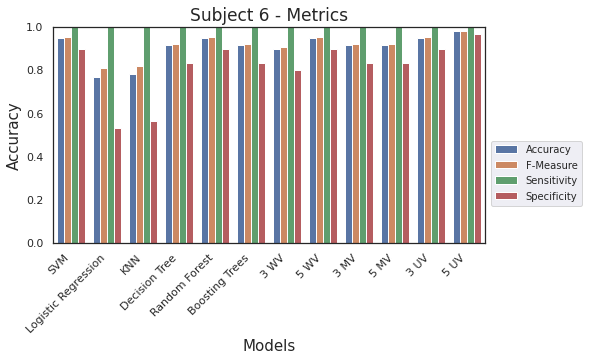

In [183]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc6, lrAcc6, knnAcc6, dtAcc6, rfAcc6, xgbClfAcc6, s6_3wv_acc, s6_5wv_acc, s6_3mv_acc, s6_5mv_acc, s6_3uv_acc, s6_5uv_acc, svmClfF6, lrF6, knnF6, dtF6, rfF6, xgbClfF6, s6_3wv_f, s6_5wv_f, s6_3mv_f, s6_5mv_f, s6_3uv_f, s6_5uv_f, svmClfSens6, lrSens6, knnSens6, dtSens6, rfSens6, xgbClfSens6, s6_3wv_sens, s6_5wv_sens, s6_3mv_sens, s6_5mv_sens, s6_3uv_sens, s6_5uv_sens, svmClfSpec6, lrSpec6, knnSpec6, dtSpec6, rfSpec6, xgbClfSpec6, s6_3wv_spec, s6_5wv_spec, s6_3mv_spec, s6_5mv_spec, s6_3uv_spec, s6_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 6 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Fold 7

In [184]:
df_train = pd.read_csv('Fold_7_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_7_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [185]:
df_train_master, df_val_master = createMasterTrainVal(7, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(7, 9, df_train_master, df_val_master)

## Metrics and Optimisations

### SVM

In [186]:
optimisationSVM(7)

101 (0.6656445205972853, 0.738888888888889)


{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5528933359056701, 0.4759259259259259),
 '0.10.1': (0.6143773300602375, 0.5925925925925926),
 '0.11': (0.11288293641234819, 0.4462962962962963),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5361448195762746, 0.48148148148148145),
 '10.01': (0.4627055355039833, 0.5),
 '10.1': (0.4273240694293326, 0.5537037037037038),
 '100.0001': (0.41074729558836637, 0.4833333333333333),
 '100.001': (0.3880134929834059, 0.45185185185185184),
 '100.01': (0.3437845969938396, 0.5111111111111112),
 '100.1': (0.4480642419561262, 0.5962962962962963),
 '1000.0001': (0.3861981858435759, 0.4703703703703704),
 '1000.001': (0.41642108741251943, 0.5333333333333334),
 '1000.01': (0.43488703496883846, 0.5574074074074074),
 '1000.1': (0.549990505137564, 0.6648148148148149),
 '10000.0001': (0.42200028275120127, 0.5407407407407407),
 '10000.001': (0.5107042643905381, 0.577777777777778),
 '10000.01': (0.371299363404626

### Logistic Regression

In [187]:
optimisationLr(7)

l10.23357214690901212liblinearFalse (0.5662893040625481, 0.5833333333333334)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.11472823472823472,
  0.3796296296296296),
 'l10.03359818286283781liblinearTrue': (0.11472823472823472,
  0.3796296296296296),
 'l10.08858667904100823liblinearFalse': (

### KNN

In [188]:
optimisationKnn(7)

80distancekd_tree751 (0.7417750777411221, 0.7074074074074075)


{'10distanceauto1001': (0.6468047545033734, 0.7129629629629629),
 '10distanceauto152': (0.6484289419321919, 0.7148148148148148),
 '10distanceauto602': (0.6484289419321919, 0.7148148148148148),
 '10distanceball_tree152': (0.6499365553801038, 0.7166666666666666),
 '10distanceball_tree452': (0.6484289419321919, 0.7148148148148148),
 '10distancebrute1001': (0.6468047545033734, 0.7129629629629629),
 '10distancebrute451': (0.6468047545033734, 0.7129629629629629),
 '10distancebrute751': (0.6468047545033734, 0.7129629629629629),
 '10distancebrute752': (0.6484289419321919, 0.7148148148148148),
 '10distancekd_tree302': (0.6484289419321919, 0.7148148148148148),
 '10uniformauto1001': (0.2147915554503384, 0.47777777777777775),
 '10uniformauto1002': (0.28494667300637444, 0.5240740740740741),
 '10uniformauto152': (0.28494667300637444, 0.5240740740740741),
 '10uniformauto451': (0.2147915554503384, 0.47777777777777775),
 '10uniformball_tree1001': (0.216960000241734, 0.48148148148148145),
 '10uniformbal

### Decision Tree

In [189]:
dtVF7, dtVAcc7 = metricsDecisionTree(7)
dtVF7, dtVAcc7

(0.6428132631671662, 0.7074074074074074)

### Random Forest

In [190]:
rfVF7, rfVAcc7 = metricsRandomForest(7)
rfVF7, rfVAcc7

(0.6751843617145578, 0.7555555555555556)

### Xgboost

In [191]:
xgbClfVF7, xgbClfVAcc7 = metricsXgb(7)
xgbClfVF7, xgbClfVAcc7

(0.6662767580738155, 0.7444444444444446)

## Model Training

### SVM

Accuracy: 0.9
f-measure: 0.9090909090909091
Sensitivity: 1.0
Specificity: 0.8
              precision    recall  f1-score   support

           0       1.00      0.80      0.89        30
           1       0.83      1.00      0.91        30

    accuracy                           0.90        60
   macro avg       0.92      0.90      0.90        60
weighted avg       0.92      0.90      0.90        60



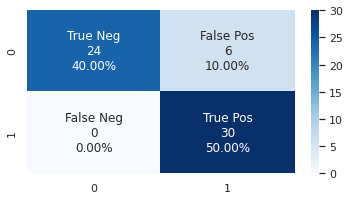

In [192]:
svmClfVF7 = 0.6656445205972853
svmClfVAcc7 = 0.738888888888889
svmClf = svm.SVC(C = 10, gamma = 1, kernel='rbf', probability=True, random_state=31)
svmClfAcc7, svmClfF7, svmClfSens7, svmClfSpec7 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.6666666666666666
f-measure: 0.7499999999999999
Sensitivity: 1.0
Specificity: 0.3333333333333333
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        30
           1       0.60      1.00      0.75        30

    accuracy                           0.67        60
   macro avg       0.80      0.67      0.62        60
weighted avg       0.80      0.67      0.62        60



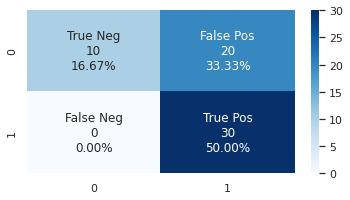

In [193]:
lrVF7, lrVAcc7 = (0.5662893040625481, 0.5833333333333334)
lr = LogisticRegression(penalty='l1', C=0.23357214690901212, solver='liblinear', fit_intercept=False, random_state=31)
lrAcc7, lrF7, lrSens7, lrSpec7 = userModel(lr)

### KNN

Accuracy: 0.8333333333333334
f-measure: 0.8571428571428571
Sensitivity: 1.0
Specificity: 0.6666666666666666
              precision    recall  f1-score   support

           0       1.00      0.67      0.80        30
           1       0.75      1.00      0.86        30

    accuracy                           0.83        60
   macro avg       0.88      0.83      0.83        60
weighted avg       0.88      0.83      0.83        60



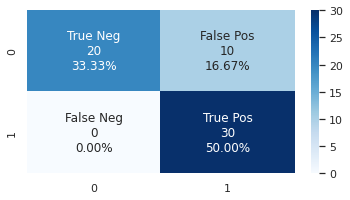

In [194]:
knnVF7, knnVAcc7 = (0.7417750777411221, 0.7074074074074075)
knn = KNeighborsClassifier(n_neighbors=80, weights='distance', algorithm='kd_tree', leaf_size=75, p=1)
knnAcc7, knnF7, knnSens7, knnSpec7 = userModel(knn)

### Decision Tree

Accuracy: 0.85
f-measure: 0.8695652173913044
Sensitivity: 1.0
Specificity: 0.7
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        30
           1       0.77      1.00      0.87        30

    accuracy                           0.85        60
   macro avg       0.88      0.85      0.85        60
weighted avg       0.88      0.85      0.85        60



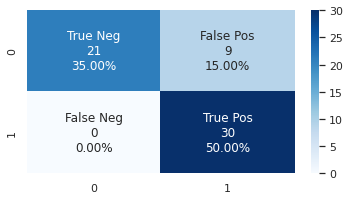

In [195]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc7, dtF7, dtSens7, dtSpec7 = userModel(dt)

### Random Forest

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



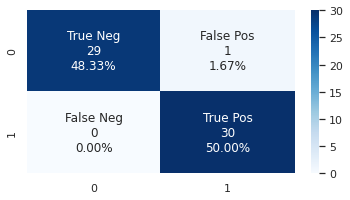

In [196]:
rf = RandomForestClassifier(random_state=31)
rfAcc7, rfF7, rfSens7, rfSpec7 = userModel(rf)

### Boosting

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



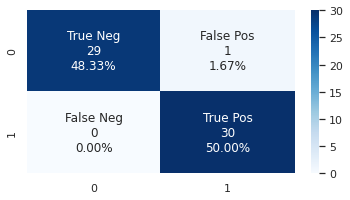

In [197]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc7, xgbClfF7, xgbClfSens7, xgbClfSpec7 = userModel(xgbClf)

## Plots

### Accuracy

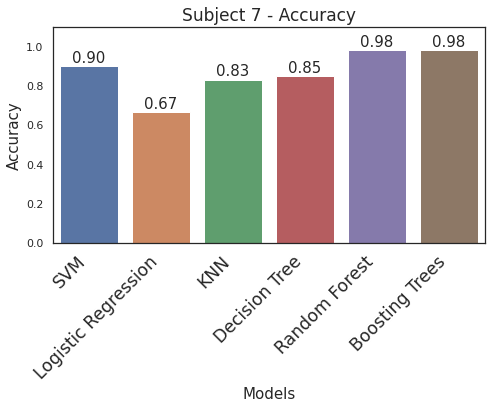

In [198]:
accuracies = [svmClfAcc7, lrAcc7, knnAcc7, dtAcc7, rfAcc7, xgbClfAcc7]
barPlot(accuracies, 'Subject 7 - Accuracy', 'Accuracy')

### F-Measure

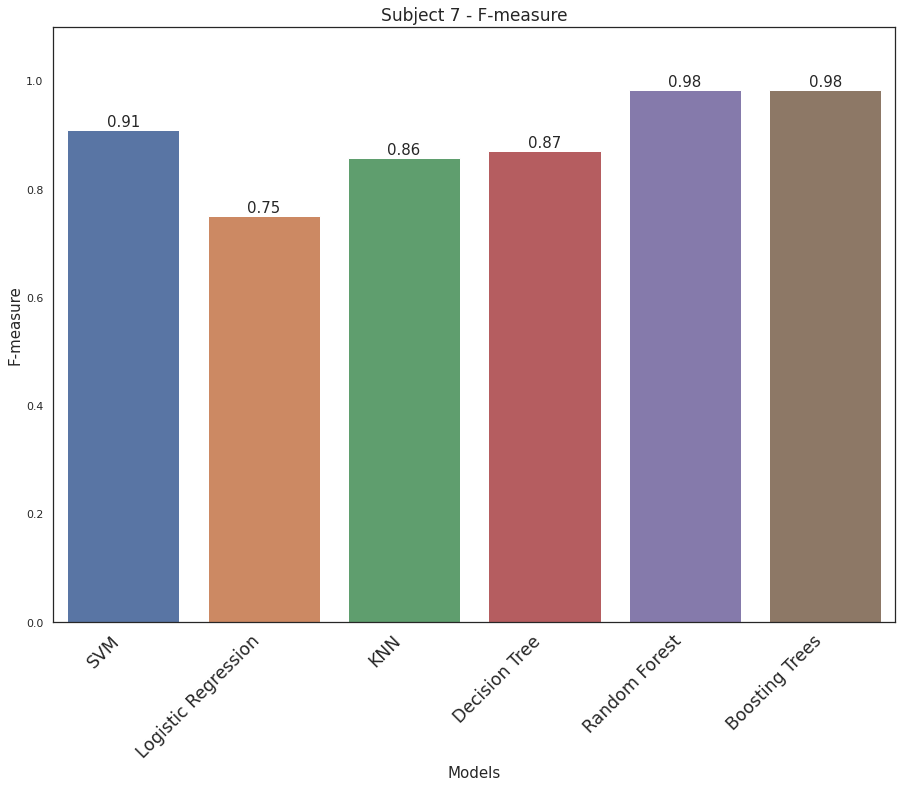

In [199]:
f_measure = [svmClfF7, lrF7, knnF7, dtF7, rfF7, xgbClfF7]
barPlot(f_measure, 'Subject 7 - F-measure', 'F-measure')

### Sensitivity

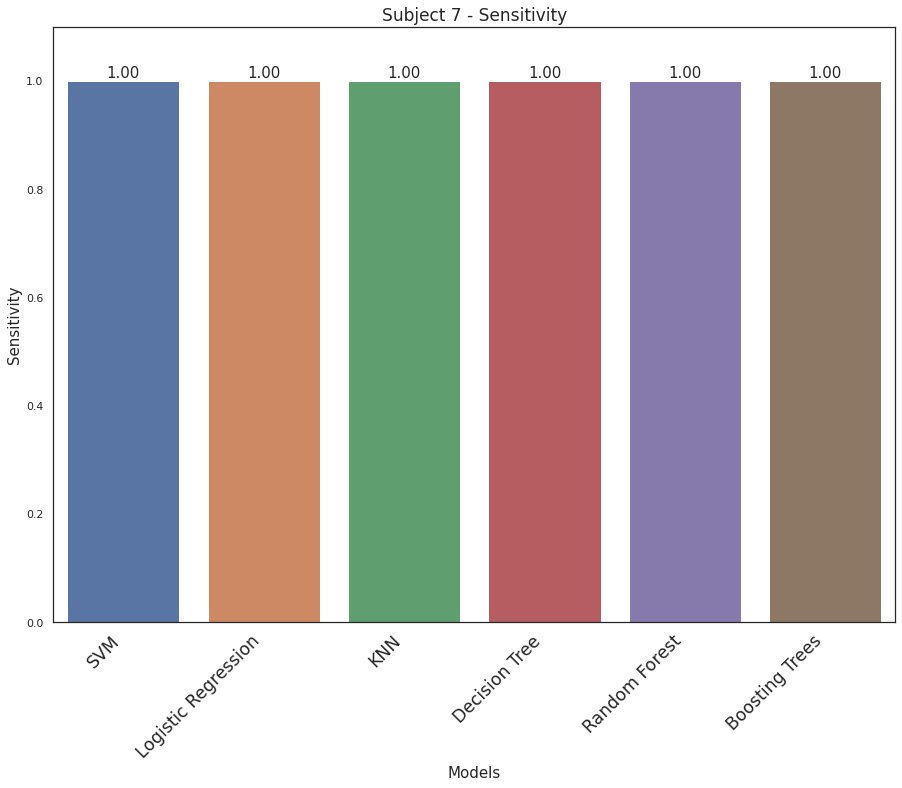

In [200]:
sens = [svmClfSens7, lrSens7, knnSens7, dtSens7, rfSens7, xgbClfSens7]
barPlot(sens, 'Subject 7 - Sensitivity', 'Sensitivity')

### Specificity

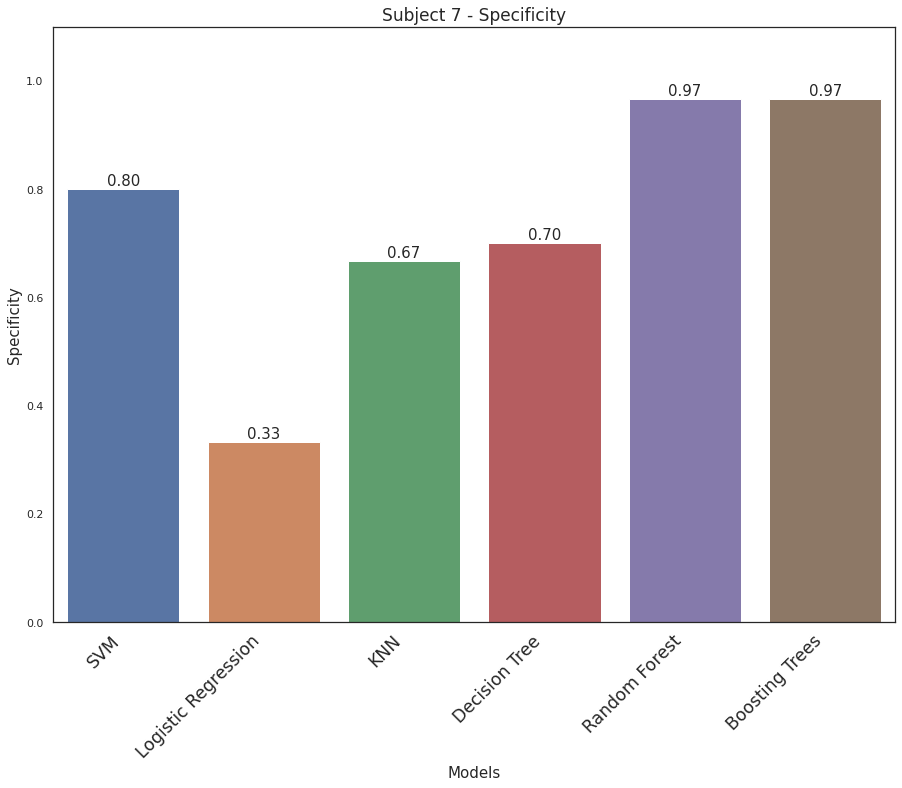

In [201]:
spec = [svmClfSpec7, lrSpec7, knnSpec7, dtSpec7, rfSpec7, xgbClfSpec7]
barPlot(spec, 'Subject 7 - Specificity', 'Specificity')

### Validation F-Measure

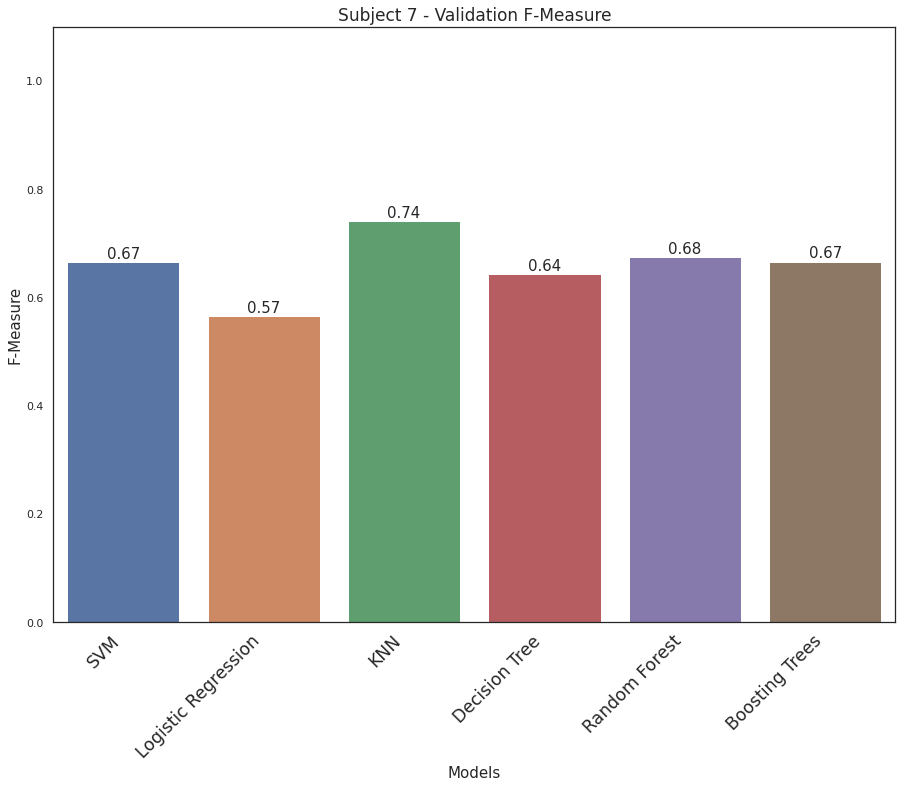

In [202]:
f_measure = [svmClfVF7, lrVF7, knnVF7, dtVF7, rfVF7, xgbClfVF7]
barPlot(f_measure, 'Subject 7 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



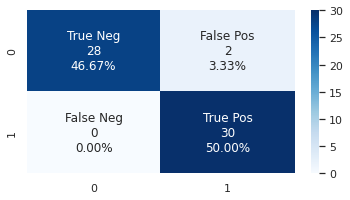

In [203]:
clf = [xgbClf, rf, knn]
weights = np.array([xgbClfVAcc7, rfVAcc7, knnVAcc7])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s7_3wv_acc, s7_3wv_f, s7_3wv_sens, s7_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.9166666666666666
f-measure: 0.923076923076923
Sensitivity: 1.0
Specificity: 0.8333333333333334
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        30
           1       0.86      1.00      0.92        30

    accuracy                           0.92        60
   macro avg       0.93      0.92      0.92        60
weighted avg       0.93      0.92      0.92        60



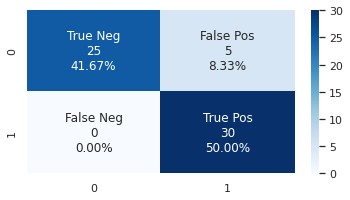

In [204]:
clf = [xgbClf, rf, svmClf, knn, dt]
weights = np.array([xgbClfVAcc7, rfVAcc7, svmClfVAcc7, knnVAcc7, dtVAcc7])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s7_5wv_acc, s7_5wv_f, s7_5wv_sens, s7_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



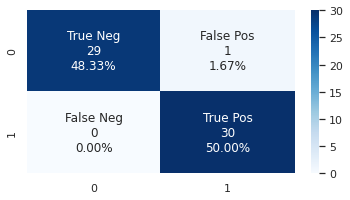

In [205]:
clf = [xgbClf, rf, knn]
pred = MajorityVotingClassification(clf)
s7_3mv_acc, s7_3mv_f, s7_3mv_sens, s7_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.9333333333333333
f-measure: 0.9375
Sensitivity: 1.0
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        30
           1       0.88      1.00      0.94        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



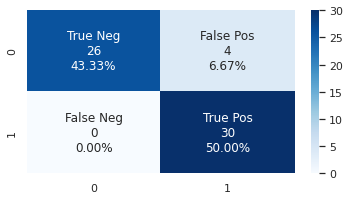

In [206]:
clf = [xgbClf, rf, svmClf, knn, dt]
pred = MajorityVotingClassification(clf)
s7_5mv_acc, s7_5mv_f, s7_5mv_sens, s7_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



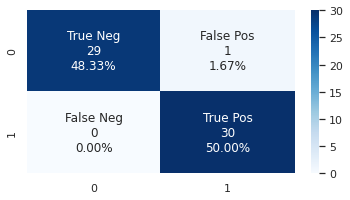

In [207]:
clf = [xgbClf, rf, knn]
pred = UnanimousVotingClassification(clf)
s7_3uv_acc, s7_3uv_f, s7_3uv_sens, s7_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



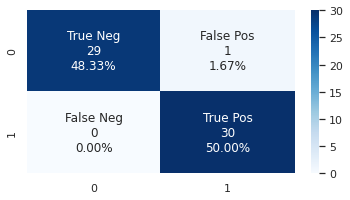

In [208]:
clf = [xgbClf, rf, svmClf, knn, dt]
pred = UnanimousVotingClassification(clf)
s7_5uv_acc, s7_5uv_f, s7_5uv_sens, s7_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

## Metrics

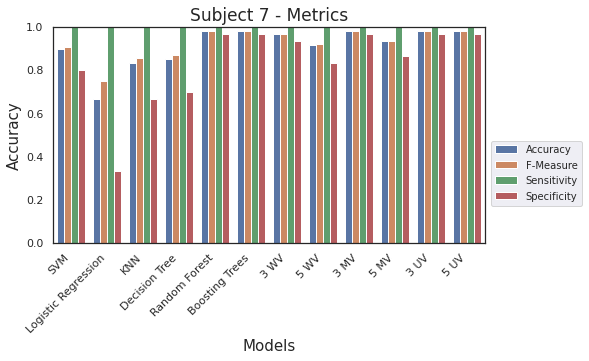

In [209]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc7, lrAcc7, knnAcc7, dtAcc7, rfAcc7, xgbClfAcc7, s7_3wv_acc, s7_5wv_acc, s7_3mv_acc, s7_5mv_acc, s7_3uv_acc, s7_5uv_acc, svmClfF7, lrF7, knnF7, dtF7, rfF7, xgbClfF7, s7_3wv_f, s7_5wv_f, s7_3mv_f, s7_5mv_f, s7_3uv_f, s7_5uv_f, svmClfSens7, lrSens7, knnSens7, dtSens7, rfSens7, xgbClfSens7, s7_3wv_sens, s7_5wv_sens, s7_3mv_sens, s7_5mv_sens, s7_3uv_sens, s7_5uv_sens, svmClfSpec7, lrSpec7, knnSpec7, dtSpec7, rfSpec7, xgbClfSpec7, s7_3wv_spec, s7_5wv_spec, s7_3mv_spec, s7_5mv_spec, s7_3uv_spec, s7_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 7 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Fold 8

In [210]:
df_train = pd.read_csv('Fold_8_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_8_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [211]:
df_train_master, df_val_master = createMasterTrainVal(8, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(8, 9, df_train_master, df_val_master)

## Metrics and Optimisations

### SVM

In [212]:
optimisationSVM(8)

11 (0.6512763046343163, 0.7425925925925926)


{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5479219019716213, 0.4629629629629629),
 '0.10.1': (0.5579000904159133, 0.5759259259259258),
 '0.11': (0.2860266227201711, 0.5370370370370371),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5296266595384479, 0.46851851851851845),
 '10.01': (0.45599809314956985, 0.48148148148148145),
 '10.1': (0.5962607639666898, 0.662962962962963),
 '100.0001': (0.0784313725490196, 0.44074074074074077),
 '100.001': (0.38179256883699786, 0.4444444444444444),
 '100.01': (0.49600304662469635, 0.6037037037037037),
 '100.1': (0.4489649712172932, 0.6018518518518517),
 '1000.0001': (0.46327546752001375, 0.5148148148148147),
 '1000.001': (0.42358312713561924, 0.5314814814814814),
 '1000.01': (0.596203802086155, 0.6611111111111111),
 '1000.1': (0.633519407712956, 0.7092592592592593),
 '10000.0001': (0.40763757822599106, 0.5259259259259259),
 '10000.001': (0.48344014989697015, 0.5648148148148148),
 '10000.01': (

### Logistic Regression

In [213]:
optimisationLr(8)

l11438.44988828766liblinearFalse (0.6323718804210263, 0.6166666666666667)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.3814814814814815),
 'l10.03359818286283781liblinearTrue': (0.0, 0.3814814814814815),
 'l10.08858667904100823liblinearFalse': (0.46977951467436047,
  0.50370370370

### KNN

In [214]:
optimisationKnn(8)

80distanceauto302 (0.7331829220793141, 0.7000000000000001)


{'10distanceauto1001': (0.6376637926039554, 0.7092592592592593),
 '10distanceauto152': (0.6336194458726957, 0.7092592592592593),
 '10distanceauto602': (0.6336194458726957, 0.7092592592592593),
 '10distanceball_tree152': (0.6367296234231719, 0.7129629629629629),
 '10distanceball_tree452': (0.6352220099752599, 0.711111111111111),
 '10distancebrute1001': (0.6376637926039554, 0.7092592592592593),
 '10distancebrute451': (0.6376637926039554, 0.7092592592592593),
 '10distancebrute751': (0.6376637926039554, 0.7092592592592593),
 '10distancebrute752': (0.6336194458726957, 0.7092592592592593),
 '10distancekd_tree302': (0.6352220099752599, 0.711111111111111),
 '10uniformauto1001': (0.280065526964504, 0.5166666666666667),
 '10uniformauto1002': (0.37130367510248663, 0.5703703703703704),
 '10uniformauto152': (0.37130367510248663, 0.5703703703703704),
 '10uniformauto451': (0.280065526964504, 0.5166666666666667),
 '10uniformball_tree1001': (0.2851633202818453, 0.5240740740740741),
 '10uniformball_tree

### Decision Tree

In [215]:
dtVF8, dtVAcc8 = metricsDecisionTree(8)
dtVF8, dtVAcc8

(0.6211648509442627, 0.7037037037037037)

### Random Forest

In [216]:
rfVF8, rfVAcc8 = metricsRandomForest(8)
rfVF8, rfVAcc8

(0.6597431852439695, 0.7555555555555556)

### Xgboost

In [217]:
xgbClfVF8, xgbClfVAcc8 = metricsXgb(8)
xgbClfVF8, xgbClfVAcc8

(0.6546711094751724, 0.7462962962962965)

## Model Training

### SVM

Accuracy: 0.5166666666666667
f-measure: 0.17142857142857143
Sensitivity: 0.1
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       0.51      0.93      0.66        30
           1       0.60      0.10      0.17        30

    accuracy                           0.52        60
   macro avg       0.55      0.52      0.42        60
weighted avg       0.55      0.52      0.42        60



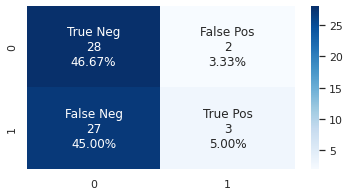

In [218]:
svmClfVF8 = 0.6512763046343163
svmClfVAcc8 = 0.7425925925925926
svmClf = svm.SVC(C = 1, gamma = 1, kernel='rbf', probability=True, random_state=31)
svmClfAcc8, svmClfF8, svmClfSens8, svmClfSpec8 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.35
f-measure: 0.13333333333333333
Sensitivity: 0.1
Specificity: 0.6
              precision    recall  f1-score   support

           0       0.40      0.60      0.48        30
           1       0.20      0.10      0.13        30

    accuracy                           0.35        60
   macro avg       0.30      0.35      0.31        60
weighted avg       0.30      0.35      0.31        60



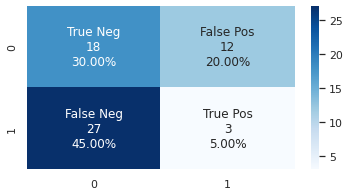

In [219]:
lrVF8, lrVAcc8 = (0.6323718804210263, 0.6166666666666667)
lr = LogisticRegression(penalty='l1', C=1438.44988828766, solver='liblinear', fit_intercept=False, random_state=31)
lrAcc8, lrF8, lrSens8, lrSpec8 = userModel(lr)

### KNN

Accuracy: 0.7666666666666667
f-measure: 0.8108108108108109
Sensitivity: 1.0
Specificity: 0.5333333333333333
              precision    recall  f1-score   support

           0       1.00      0.53      0.70        30
           1       0.68      1.00      0.81        30

    accuracy                           0.77        60
   macro avg       0.84      0.77      0.75        60
weighted avg       0.84      0.77      0.75        60



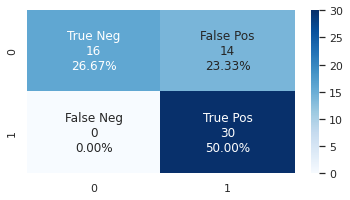

In [220]:
knnVF8, knnVAcc8 = (0.7331829220793141, 0.7000000000000001)
knn = KNeighborsClassifier(n_neighbors=80, weights='distance', algorithm='auto', leaf_size=30, p=2)
knnAcc8, knnF8, knnSens8, knnSpec8 = userModel(knn)

### Decision Tree

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



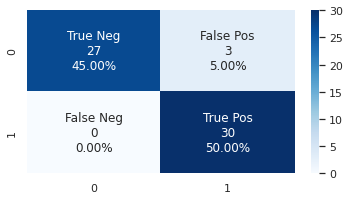

In [221]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc8, dtF8, dtSens8, dtSpec8 = userModel(dt)

### Random Forest

Accuracy: 0.9833333333333333
f-measure: 0.9836065573770492
Sensitivity: 1.0
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        30
           1       0.97      1.00      0.98        30

    accuracy                           0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60



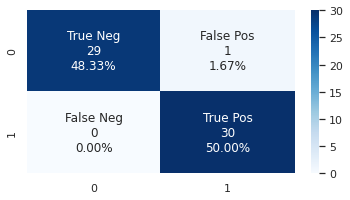

In [222]:
rf = RandomForestClassifier(random_state=31)
rfAcc8, rfF8, rfSens8, rfSpec8 = userModel(rf)

### Boosting

Accuracy: 0.9666666666666667
f-measure: 0.967741935483871
Sensitivity: 1.0
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       1.00      0.93      0.97        30
           1       0.94      1.00      0.97        30

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



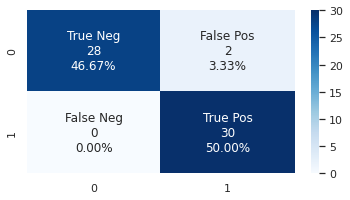

In [223]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc8, xgbClfF8, xgbClfSens8, xgbClfSpec8 = userModel(xgbClf)

## Plots

### Accuracy

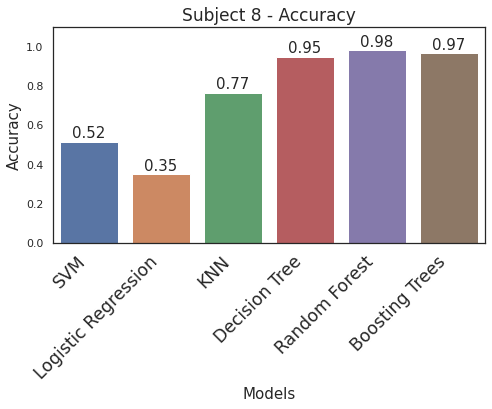

In [224]:
accuracies = [svmClfAcc8, lrAcc8, knnAcc8, dtAcc8, rfAcc8, xgbClfAcc8]
barPlot(accuracies, 'Subject 8 - Accuracy', 'Accuracy')

### F-Measure

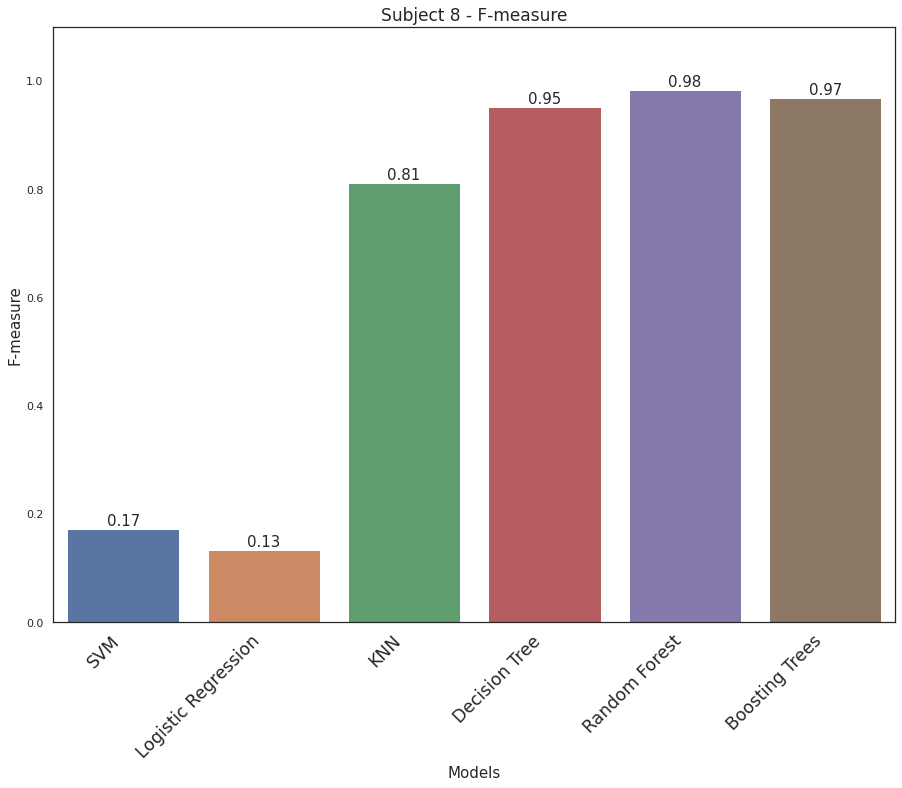

In [225]:
f_measure = [svmClfF8, lrF8, knnF8, dtF8, rfF8, xgbClfF8]
barPlot(f_measure, 'Subject 8 - F-measure', 'F-measure')

### Sensitivity

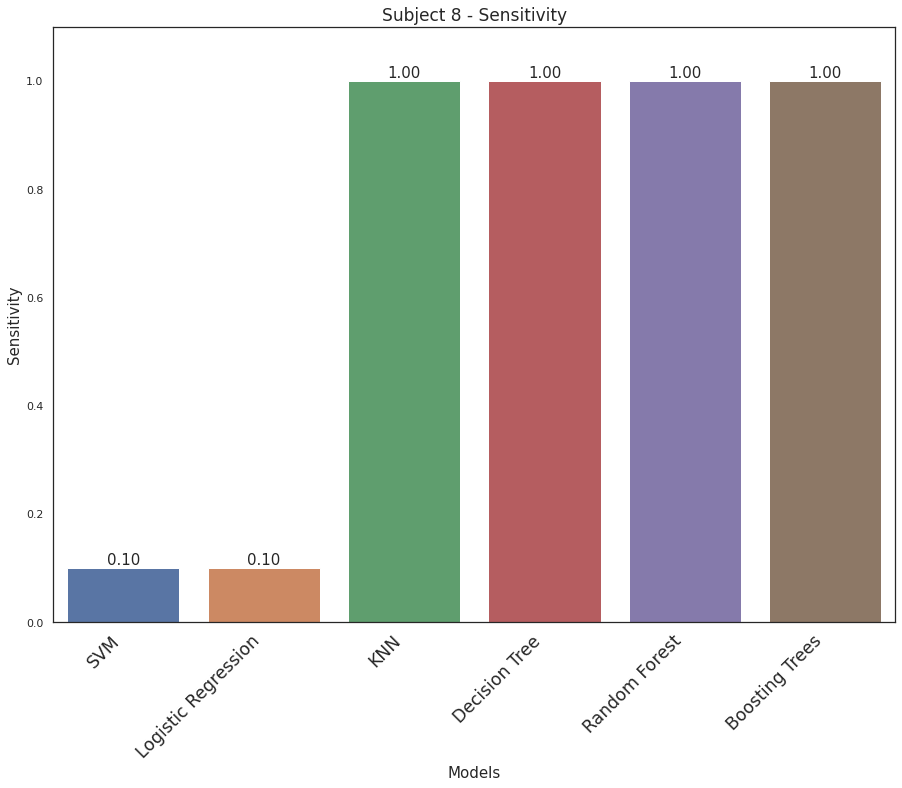

In [226]:
sens = [svmClfSens8, lrSens8, knnSens8, dtSens8, rfSens8, xgbClfSens8]
barPlot(sens, 'Subject 8 - Sensitivity', 'Sensitivity')

### Specificity

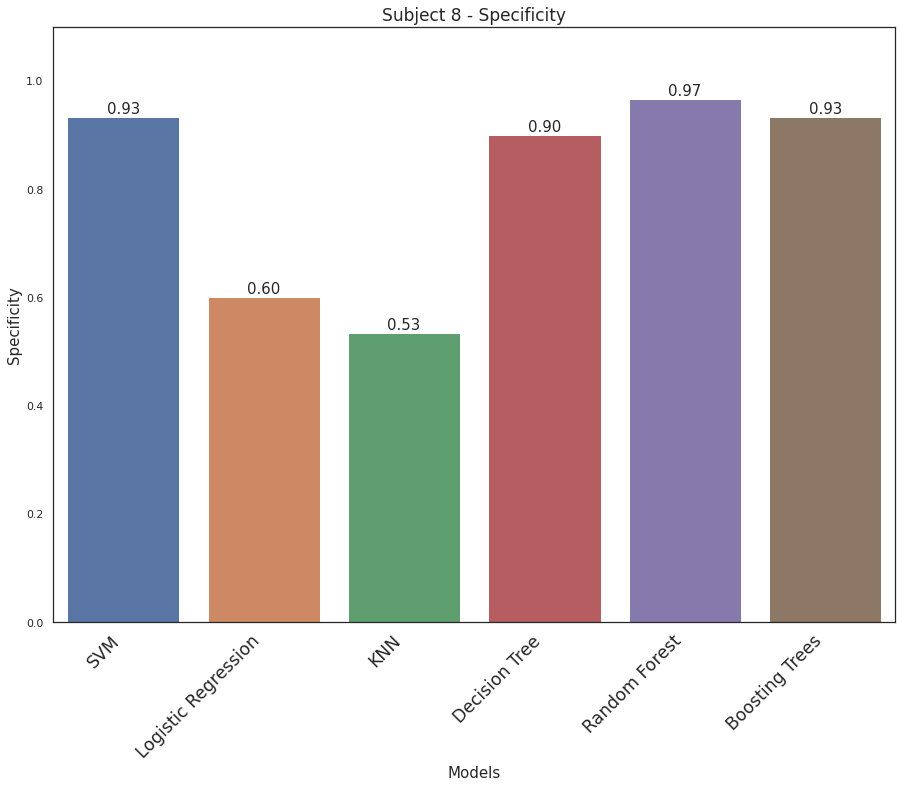

In [227]:
spec = [svmClfSpec8, lrSpec8, knnSpec8, dtSpec8, rfSpec8, xgbClfSpec8]
barPlot(spec, 'Subject 8 - Specificity', 'Specificity')

### Validation F-Measure

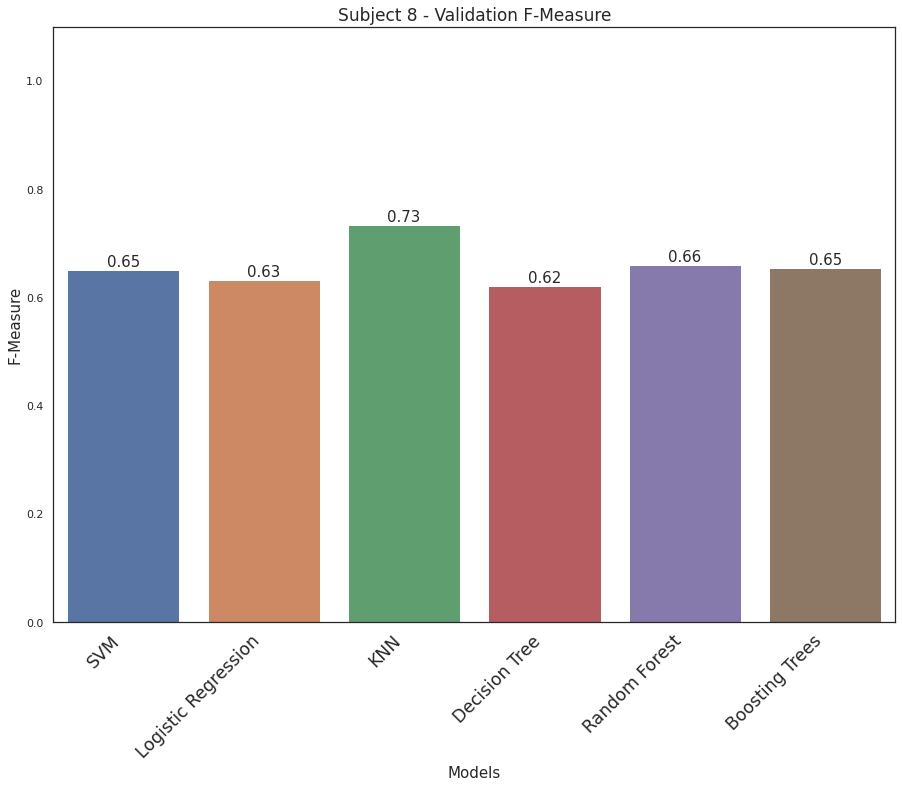

In [228]:
f_measure = [svmClfVF8, lrVF8, knnVF8, dtVF8, rfVF8, xgbClfVF8]
barPlot(f_measure, 'Subject 8 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



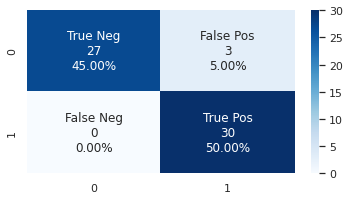

In [229]:
clf = [knn, rf, svmClf]
weights = np.array([knnVAcc8, rfVAcc8, svmClfVAcc8])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s8_3wv_acc, s8_3wv_f, s8_3wv_sens, s8_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



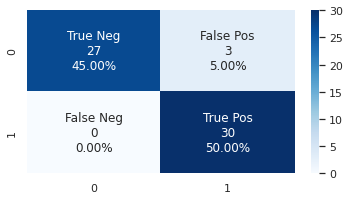

In [230]:
clf = [xgbClf, rf, svmClf, knn, dt]
weights = np.array([xgbClfVAcc8, rfVAcc8, svmClfVAcc8, knnVAcc8, dtVAcc8])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s8_5wv_acc, s8_5wv_f, s8_5wv_sens, s8_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



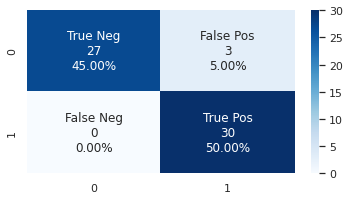

In [231]:
clf = [knn, rf, svmClf]
pred = MajorityVotingClassification(clf)
s8_3mv_acc, s8_3mv_f, s8_3mv_sens, s8_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.95
f-measure: 0.9523809523809523
Sensitivity: 1.0
Specificity: 0.9
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        30
           1       0.91      1.00      0.95        30

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



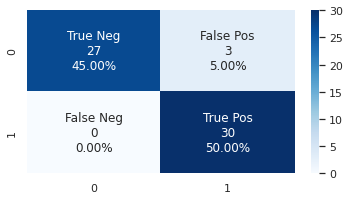

In [232]:
clf = [xgbClf, rf, svmClf, knn, dt]
pred = MajorityVotingClassification(clf)
s8_5mv_acc, s8_5mv_f, s8_5mv_sens, s8_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.55
f-measure: 0.18181818181818182
Sensitivity: 0.1
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



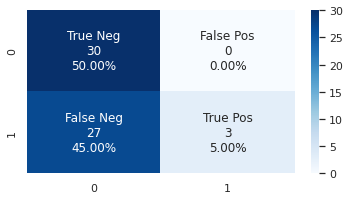

In [233]:
clf = [knn, rf, svmClf]
pred = UnanimousVotingClassification(clf)
s8_3uv_acc, s8_3uv_f, s8_3uv_sens, s8_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.55
f-measure: 0.18181818181818182
Sensitivity: 0.1
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        30
           1       1.00      0.10      0.18        30

    accuracy                           0.55        60
   macro avg       0.76      0.55      0.44        60
weighted avg       0.76      0.55      0.44        60



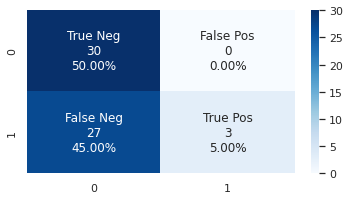

In [234]:
clf = [xgbClf, rf, svmClf, knn, dt]
pred = UnanimousVotingClassification(clf)
s8_5uv_acc, s8_5uv_f, s8_5uv_sens, s8_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

## Metrics

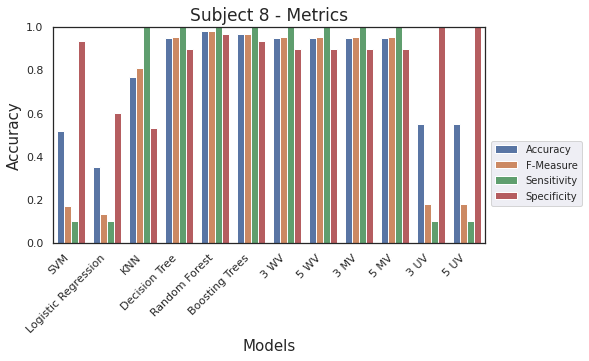

In [235]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc8, lrAcc8, knnAcc8, dtAcc8, rfAcc8, xgbClfAcc8, s8_3wv_acc, s8_5wv_acc, s8_3mv_acc, s8_5mv_acc, s8_3uv_acc, s8_5uv_acc, svmClfF8, lrF8, knnF8, dtF8, rfF8, xgbClfF8, s8_3wv_f, s8_5wv_f, s8_3mv_f, s8_5mv_f, s8_3uv_f, s8_5uv_f, svmClfSens8, lrSens8, knnSens8, dtSens8, rfSens8, xgbClfSens8, s8_3wv_sens, s8_5wv_sens, s8_3mv_sens, s8_5mv_sens, s8_3uv_sens, s8_5uv_sens, svmClfSpec8, lrSpec8, knnSpec8, dtSpec8, rfSpec8, xgbClfSpec8, s8_3wv_spec, s8_5wv_spec, s8_3mv_spec, s8_5mv_spec, s8_3uv_spec, s8_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 8 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Fold 9

In [236]:
df_train = pd.read_csv('Fold_9_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_9_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [237]:
df_train_master, df_val_master = createMasterTrainVal(9, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(9, 9, df_train_master, df_val_master)

## Metrics and Optimisations

### SVM

In [238]:
optimisationSVM(9)

101 (0.752193473143065, 0.7870370370370372)


{'0.10.0001': (0.0, 0.4444444444444444),
 '0.10.001': (0.0, 0.4444444444444444),
 '0.10.01': (0.5500438206310077, 0.47777777777777775),
 '0.10.1': (0.418586981879715, 0.5018518518518519),
 '0.11': (0.30544440544440543, 0.5462962962962963),
 '10.0001': (0.0, 0.4444444444444444),
 '10.001': (0.5279046740892249, 0.4629629629629629),
 '10.01': (0.45005703905874067, 0.4740740740740741),
 '10.1': (0.5230878913310189, 0.6203703703703703),
 '100.0001': (0.07662835249042146, 0.4222222222222222),
 '100.001': (0.4034939271432265, 0.46481481481481485),
 '100.01': (0.6774945238659458, 0.6925925925925925),
 '100.1': (0.4533234533234533, 0.6111111111111112),
 '1000.0001': (0.4637676532123314, 0.5185185185185186),
 '1000.001': (0.5013001732011122, 0.5722222222222223),
 '1000.01': (0.4292016485430116, 0.5518518518518519),
 '1000.1': (0.6372562622562623, 0.7240740740740742),
 '10000.0001': (0.43422905251264216, 0.5333333333333334),
 '10000.001': (0.40776612422294456, 0.5166666666666666),
 '10000.01': (0

### Logistic Regression

In [239]:
optimisationLr(9)

l20.08858667904100823liblinearFalse (0.4900171341952164, 0.5314814814814814)


{'l10.0001liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0001liblinearTrue': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.4444444444444444),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.4444444444444444),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearFalse': (0.0, 0.4444444444444444),
 'l10.004832930238571752liblinearTrue': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearFalse': (0.0, 0.4444444444444444),
 'l10.012742749857031334liblinearTrue': (0.0, 0.4444444444444444),
 'l10.03359818286283781liblinearFalse': (0.0, 0.38518518518518513),
 'l10.03359818286283781liblinearTrue': (0.0, 0.38518518518518513),
 'l10.08858667904100823liblinearFalse': (0.4643406770579161,
  0.5148148148

### KNN

In [240]:
optimisationKnn(9)

20distancebrute601 (0.8037831581237653, 0.7944444444444446)


{'10distanceauto1001': (0.7446348347135925, 0.7759259259259259),
 '10distanceauto152': (0.7386455491190438, 0.7703703703703705),
 '10distanceauto602': (0.7386455491190438, 0.7703703703703705),
 '10distanceball_tree152': (0.7407994887729834, 0.7740740740740741),
 '10distanceball_tree452': (0.7391460496195443, 0.7722222222222224),
 '10distancebrute1001': (0.7446348347135925, 0.7759259259259259),
 '10distancebrute451': (0.7446348347135925, 0.7759259259259259),
 '10distancebrute751': (0.7446348347135925, 0.7759259259259259),
 '10distancebrute752': (0.7386455491190438, 0.7703703703703705),
 '10distancekd_tree302': (0.7391460496195443, 0.7722222222222224),
 '10uniformauto1001': (0.21449704263171757, 0.48888888888888893),
 '10uniformauto1002': (0.38152406021843666, 0.5814814814814815),
 '10uniformauto152': (0.38152406021843666, 0.5814814814814815),
 '10uniformauto451': (0.21449704263171757, 0.48888888888888893),
 '10uniformball_tree1001': (0.21449704263171757, 0.48888888888888893),
 '10unifor

### Decision Tree

In [241]:
dtVF9, dtVAcc9 = metricsDecisionTree(9)
dtVF9, dtVAcc9

(0.722510626604858, 0.75)

### Random Forest

In [242]:
rfVF9, rfVAcc9 = metricsRandomForest(9)
rfVF9, rfVAcc9

(0.7672700669643996, 0.8074074074074075)

### Xgboost

In [243]:
xgbClfVF9, xgbClfVAcc9 = metricsXgb(9)
xgbClfVF9, xgbClfVAcc9

(0.7701454015658672, 0.8092592592592593)

## Model Training

### SVM

Accuracy: 0.9166666666666666
f-measure: 0.9152542372881356
Sensitivity: 0.9
Specificity: 0.9333333333333333
              precision    recall  f1-score   support

           0       0.90      0.93      0.92        30
           1       0.93      0.90      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



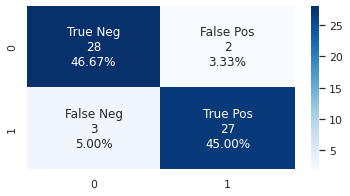

In [244]:
svmClfVF9 = 0.752193473143065
svmClfVAcc9 = 0.7870370370370372
svmClf = svm.SVC(C = 10, gamma = 1, kernel='rbf', probability=True, random_state=31)
svmClfAcc9, svmClfF9, svmClfSens9, svmClfSpec9 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.7666666666666667
f-measure: 0.7941176470588235
Sensitivity: 0.9
Specificity: 0.6333333333333333
              precision    recall  f1-score   support

           0       0.86      0.63      0.73        30
           1       0.71      0.90      0.79        30

    accuracy                           0.77        60
   macro avg       0.79      0.77      0.76        60
weighted avg       0.79      0.77      0.76        60



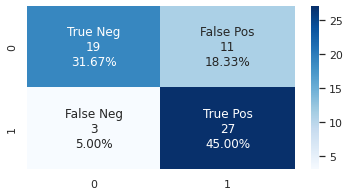

In [245]:
lrVF9, lrVAcc9 = (0.4900171341952164, 0.5314814814814814)
lr = LogisticRegression(penalty='l2', C=0.08858667904100823, solver='liblinear', fit_intercept=False, random_state=31)
lrAcc9, lrF9, lrSens9, lrSpec9 = userModel(lr)

### KNN

Accuracy: 0.9
f-measure: 0.9032258064516129
Sensitivity: 0.9333333333333333
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.88      0.93      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



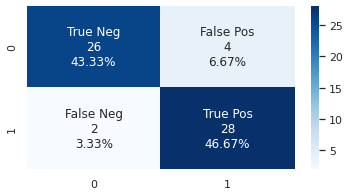

In [246]:
knnVF9, knnVAcc9 = (0.8037831581237653, 0.7944444444444446)
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='brute', leaf_size=60, p=1)
knnAcc9, knnF9, knnSens9, knnSpec9 = userModel(knn)

### Decision Tree

Accuracy: 0.9
f-measure: 0.9032258064516129
Sensitivity: 0.9333333333333333
Specificity: 0.8666666666666667
              precision    recall  f1-score   support

           0       0.93      0.87      0.90        30
           1       0.88      0.93      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



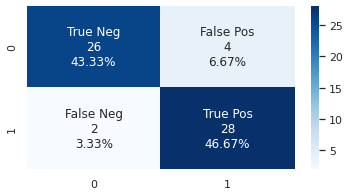

In [247]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc9, dtF9, dtSens9, dtSpec9 = userModel(dt)

### Random Forest

Accuracy: 0.9333333333333333
f-measure: 0.9310344827586207
Sensitivity: 0.9
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.96      0.90      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



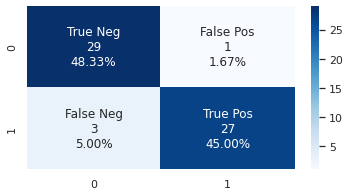

In [248]:
rf = RandomForestClassifier(random_state=31)
rfAcc9, rfF9, rfSens9, rfSpec9 = userModel(rf)

### Boosting

Accuracy: 0.9
f-measure: 0.9
Sensitivity: 0.9
Specificity: 0.9
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



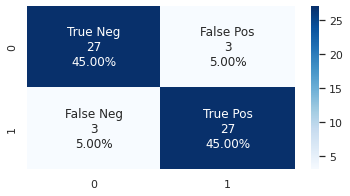

In [249]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc9, xgbClfF9, xgbClfSens9, xgbClfSpec9 = userModel(xgbClf)

## Plots

### Accuracy

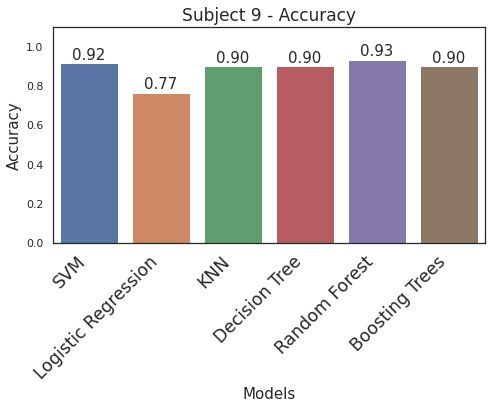

In [250]:
accuracies = [svmClfAcc9, lrAcc9, knnAcc9, dtAcc9, rfAcc9, xgbClfAcc9]
barPlot(accuracies, 'Subject 9 - Accuracy', 'Accuracy')

### F-Measure

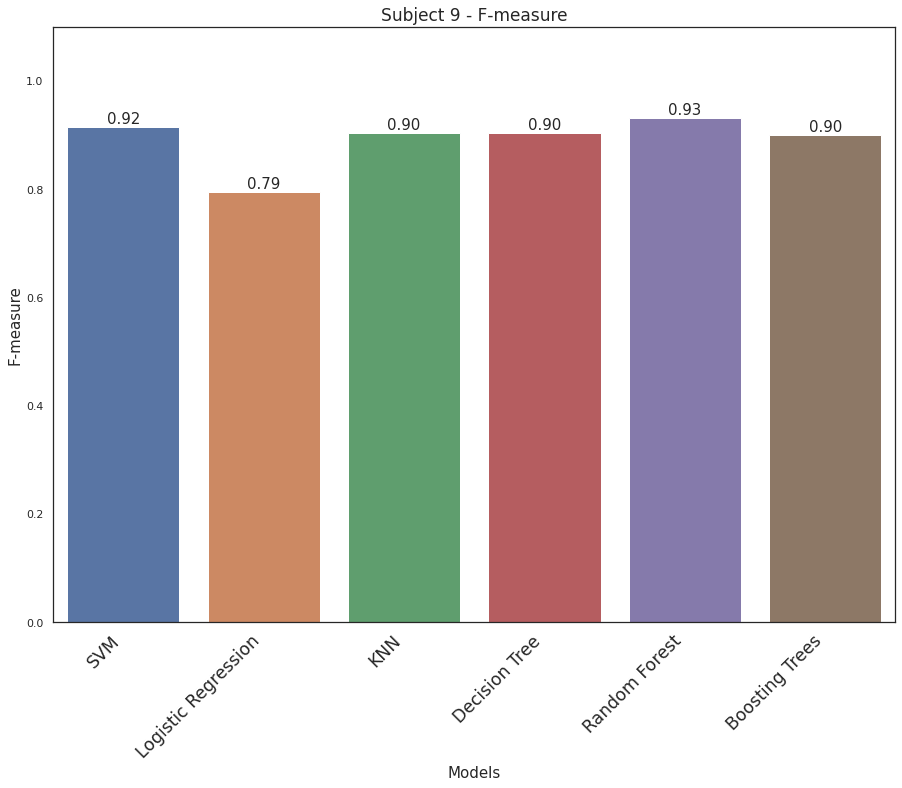

In [251]:
f_measure = [svmClfF9, lrF9, knnF9, dtF9, rfF9, xgbClfF9]
barPlot(f_measure, 'Subject 9 - F-measure', 'F-measure')

### Sensitivity

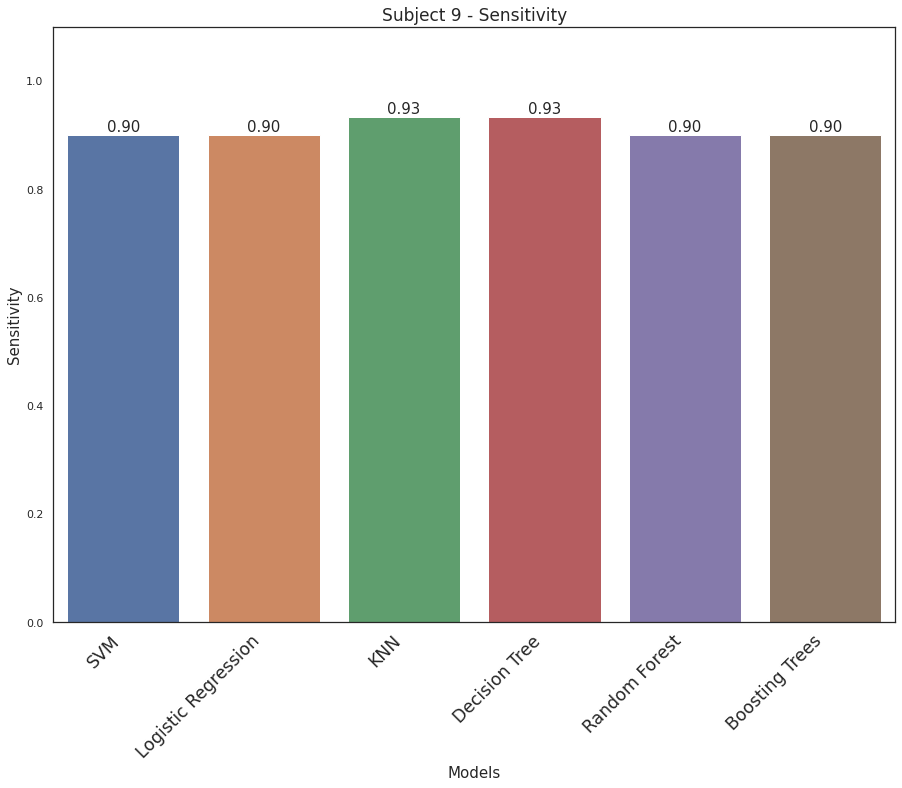

In [252]:
sens = [svmClfSens9, lrSens9, knnSens9, dtSens9, rfSens9, xgbClfSens9]
barPlot(sens, 'Subject 9 - Sensitivity', 'Sensitivity')

### Specificity

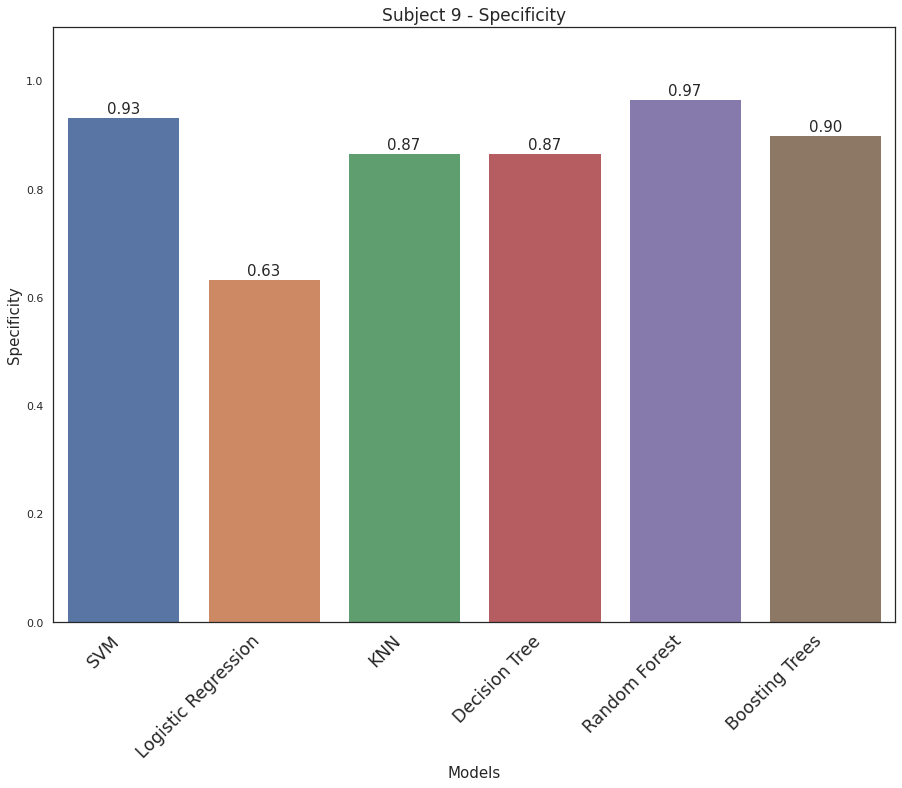

In [253]:
spec = [svmClfSpec9, lrSpec9, knnSpec9, dtSpec9, rfSpec9, xgbClfSpec9]
barPlot(spec, 'Subject 9 - Specificity', 'Specificity')

### Validation F-Measure

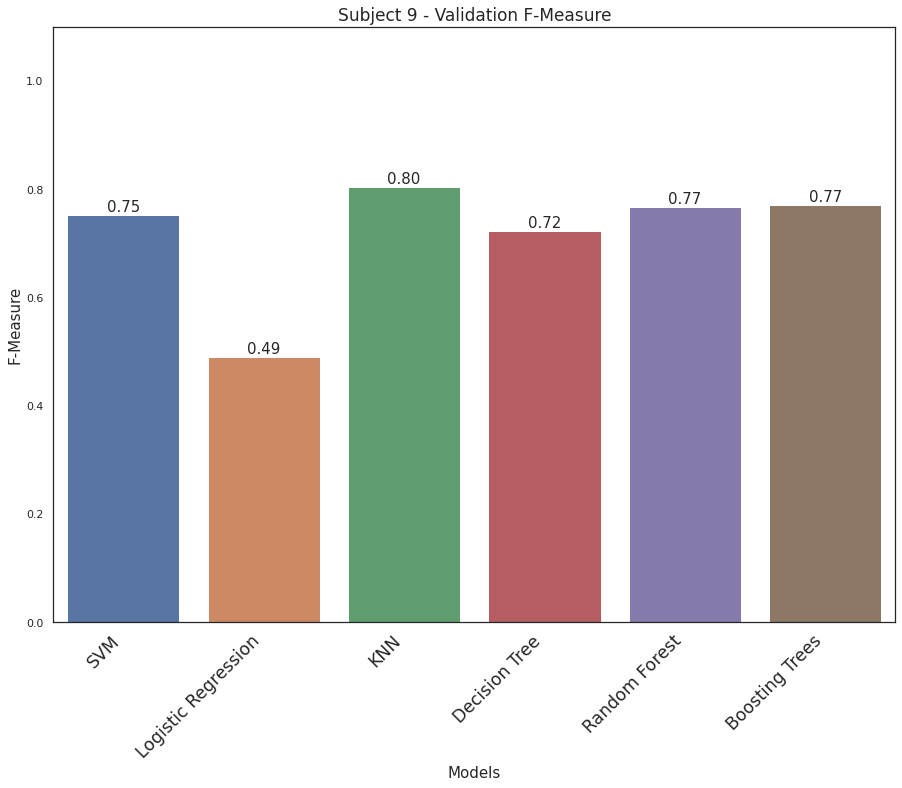

In [254]:
f_measure = [svmClfVF9, lrVF9, knnVF9, dtVF9, rfVF9, xgbClfVF9]
barPlot(f_measure, 'Subject 9 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.9
f-measure: 0.9
Sensitivity: 0.9
Specificity: 0.9
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



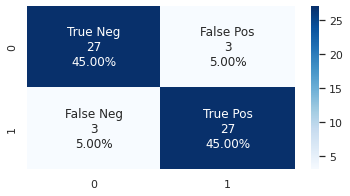

In [255]:
clf = [xgbClf, rf, knn]
weights = np.array([xgbClfVAcc9, rfVAcc9, knnVAcc9])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s9_3wv_acc, s9_3wv_f, s9_3wv_sens, s9_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.9166666666666666
f-measure: 0.9180327868852459
Sensitivity: 0.9333333333333333
Specificity: 0.9
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       0.90      0.93      0.92        30

    accuracy                           0.92        60
   macro avg       0.92      0.92      0.92        60
weighted avg       0.92      0.92      0.92        60



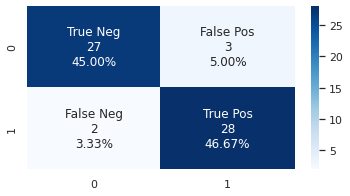

In [256]:
clf = [xgbClf, rf, svmClf, knn, dt]
weights = np.array([xgbClfVAcc9, rfVAcc9, svmClfVAcc9, knnVAcc9, dtVAcc9])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s9_5wv_acc, s9_5wv_f, s9_5wv_sens, s9_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.9
f-measure: 0.9
Sensitivity: 0.9
Specificity: 0.9
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



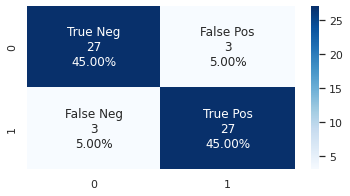

In [257]:
clf = [xgbClf, rf, knn]
pred = MajorityVotingClassification(clf)
s9_3mv_acc, s9_3mv_f, s9_3mv_sens, s9_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.9
f-measure: 0.9
Sensitivity: 0.9
Specificity: 0.9
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        30
           1       0.90      0.90      0.90        30

    accuracy                           0.90        60
   macro avg       0.90      0.90      0.90        60
weighted avg       0.90      0.90      0.90        60



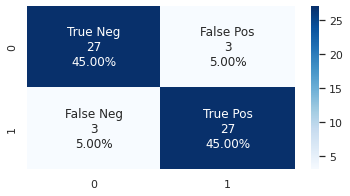

In [258]:
clf = [xgbClf, rf, svmClf, knn, dt]
pred = MajorityVotingClassification(clf)
s9_5mv_acc, s9_5mv_f, s9_5mv_sens, s9_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.9333333333333333
f-measure: 0.9310344827586207
Sensitivity: 0.9
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.96      0.90      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



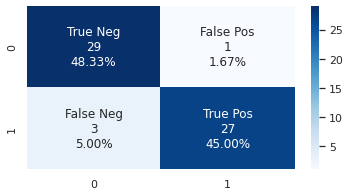

In [259]:
clf = [xgbClf, rf, knn]
pred = UnanimousVotingClassification(clf)
s9_3uv_acc, s9_3uv_f, s9_3uv_sens, s9_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.9333333333333333
f-measure: 0.9310344827586207
Sensitivity: 0.9
Specificity: 0.9666666666666667
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        30
           1       0.96      0.90      0.93        30

    accuracy                           0.93        60
   macro avg       0.94      0.93      0.93        60
weighted avg       0.94      0.93      0.93        60



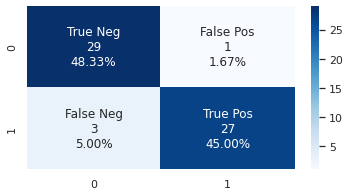

In [260]:
clf = [xgbClf, rf, svmClf, knn, dt]
pred = UnanimousVotingClassification(clf)
s9_5uv_acc, s9_5uv_f, s9_5uv_sens, s9_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

## Metrics

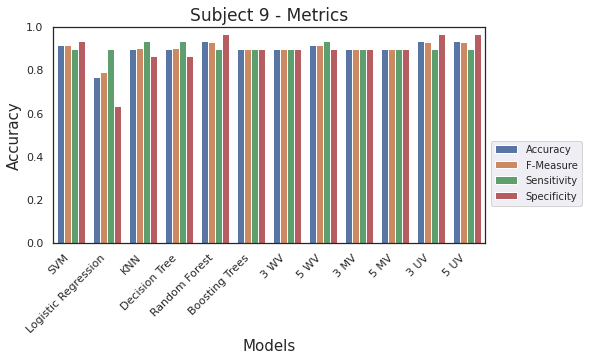

In [261]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc9, lrAcc9, knnAcc9, dtAcc9, rfAcc9, xgbClfAcc9, s9_3wv_acc, s9_5wv_acc, s9_3mv_acc, s9_5mv_acc, s9_3uv_acc, s9_5uv_acc, svmClfF9, lrF9, knnF9, dtF9, rfF9, xgbClfF9, s9_3wv_f, s9_5wv_f, s9_3mv_f, s9_5mv_f, s9_3uv_f, s9_5uv_f, svmClfSens9, lrSens9, knnSens9, dtSens9, rfSens9, xgbClfSens9, s9_3wv_sens, s9_5wv_sens, s9_3mv_sens, s9_5mv_sens, s9_3uv_sens, s9_5uv_sens, svmClfSpec9, lrSpec9, knnSpec9, dtSpec9, rfSpec9, xgbClfSpec9, s9_3wv_spec, s9_5wv_spec, s9_3mv_spec, s9_5mv_spec, s9_3uv_spec, s9_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 9 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Fold 10

In [262]:
df_train = pd.read_csv('Fold_10_Train_Dataset.csv', header=None) 
df_test = pd.read_csv('Fold_10_Test_Dataset.csv', header=None)

df_trainX = df_train.iloc[:,:-1]
df_trainY = df_train.iloc[:,-1]
df_testX = df_test.iloc[:,:-1]
df_testY = df_test.iloc[:,-1]

df_trainY[df_trainY==1] = 0
df_trainY[df_trainY==2] = 1
df_testY[df_testY==1] = 0
df_testY[df_testY==2] = 1

## Train Validation Sets

In [263]:
df_train_master, df_val_master = createMasterTrainVal(10, 9)
df_trainX_master, df_trainY_master, df_valX_master, df_valY_master = getMasterTrainValXY(10, 9, df_train_master, df_val_master)

## Metrics and Optimisations

### SVM

In [264]:
optimisationSVM(10)

101 (0.874766886154767, 0.9111111111111112)


{'0.10.0001': (0.6701916721744878, 0.5092592592592592),
 '0.10.001': (0.6718562581087366, 0.5111111111111111),
 '0.10.01': (0.619828365264402, 0.5111111111111111),
 '0.10.1': (0.65224567295594, 0.6685185185185185),
 '0.11': (0.31922950344002976, 0.5925925925925926),
 '10.0001': (0.6701916721744878, 0.5092592592592592),
 '10.001': (0.6104168991200596, 0.487037037037037),
 '10.01': (0.5302313431365087, 0.5407407407407407),
 '10.1': (0.44617831759093174, 0.6092592592592593),
 '100.0001': (0.605365741802339, 0.4759259259259259),
 '100.001': (0.5480285752713947, 0.5629629629629629),
 '100.01': (0.5159933337474112, 0.6481481481481481),
 '100.1': (0.47219215969215966, 0.6574074074074074),
 '1000.0001': (0.5764589086913634, 0.6185185185185185),
 '1000.001': (0.5921816443642735, 0.6518518518518518),
 '1000.01': (0.533373926244701, 0.6574074074074074),
 '1000.1': (0.6706198800188571, 0.7925925925925926),
 '10000.0001': (0.42662120017969796, 0.5685185185185186),
 '10000.001': (0.5848631112774373,

### Logistic Regression

In [265]:
optimisationLr(10)

l20.03359818286283781liblinearTrue (0.5824506902481977, 0.6555555555555554)


{'l10.0001liblinearFalse': (0.0, 0.5),
 'l10.0001liblinearTrue': (0.0, 0.5),
 'l10.00026366508987303583liblinearFalse': (0.0, 0.5),
 'l10.00026366508987303583liblinearTrue': (0.0, 0.5),
 'l10.0006951927961775605liblinearFalse': (0.0, 0.5),
 'l10.0006951927961775605liblinearTrue': (0.0, 0.5),
 'l10.0018329807108324356liblinearFalse': (0.0, 0.5),
 'l10.0018329807108324356liblinearTrue': (0.0, 0.5),
 'l10.004832930238571752liblinearFalse': (0.0, 0.5),
 'l10.004832930238571752liblinearTrue': (0.0, 0.5),
 'l10.012742749857031334liblinearFalse': (0.0, 0.5),
 'l10.012742749857031334liblinearTrue': (0.0, 0.5),
 'l10.03359818286283781liblinearFalse': (0.0, 0.5),
 'l10.03359818286283781liblinearTrue': (0.0, 0.5),
 'l10.08858667904100823liblinearFalse': (0.5464793622180344,
  0.5833333333333334),
 'l10.08858667904100823liblinearTrue': (0.5464793622180344,
  0.5833333333333334),
 'l10.23357214690901212liblinearFalse': (0.5680816621501668,
  0.5981481481481482),
 'l10.23357214690901212liblinearTrue

### KNN

In [266]:
optimisationKnn(10)

20distancekd_tree151 (0.8882645083592648, 0.8722222222222222)


{'10distanceauto1001': (0.8438546720915285, 0.8722222222222222),
 '10distanceauto152': (0.837346492246801, 0.862962962962963),
 '10distanceauto602': (0.837346492246801, 0.862962962962963),
 '10distanceball_tree152': (0.8405030579033667, 0.8666666666666667),
 '10distanceball_tree452': (0.8389004938008026, 0.8648148148148149),
 '10distancebrute1001': (0.8438546720915285, 0.8722222222222222),
 '10distancebrute451': (0.8438546720915285, 0.8722222222222222),
 '10distancebrute751': (0.8438546720915285, 0.8722222222222222),
 '10distancebrute752': (0.837346492246801, 0.862962962962963),
 '10distancekd_tree302': (0.837346492246801, 0.862962962962963),
 '10uniformauto1001': (0.15267691831159325, 0.4888888888888888),
 '10uniformauto1002': (0.3176351713295477, 0.5740740740740741),
 '10uniformauto152': (0.3176351713295477, 0.5740740740740741),
 '10uniformauto451': (0.15267691831159325, 0.4888888888888888),
 '10uniformball_tree1001': (0.15131396329010163, 0.4833333333333333),
 '10uniformball_tree151

### Decision Tree

In [267]:
dtVF10, dtVAcc10 = metricsDecisionTree(10)
dtVF10, dtVAcc10

(0.8539649397225131, 0.8888888888888888)

### Random Forest

In [268]:
rfVF10, rfVAcc10 = metricsRandomForest(10)
rfVF10, rfVAcc10

(0.8765596844507384, 0.9166666666666666)

### Xgboost

In [269]:
xgbClfVF10, xgbClfVAcc10 = metricsXgb(10)
xgbClfVF10, xgbClfVAcc10

(0.8714367336310662, 0.9111111111111112)

## Model Training

### SVM

Accuracy: 0.5272727272727272
f-measure: 0.0
Sensitivity: 0.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



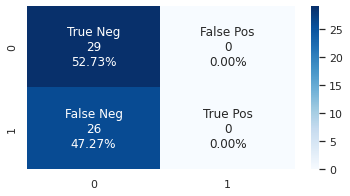

In [270]:
svmClfVF10 = 0.874766886154767
svmClfVAcc10 = 0.9111111111111112
svmClf = svm.SVC(C = 10, gamma = 1, kernel='rbf', probability=True, random_state=31)
svmClfAcc10, svmClfF10, svmClfSens10, svmClfSpec10 = userModel(svmClf)

### Logistic Regression

Accuracy: 0.5818181818181818
f-measure: 0.43902439024390244
Sensitivity: 0.34615384615384615
Specificity: 0.7931034482758621
              precision    recall  f1-score   support

           0       0.57      0.79      0.67        29
           1       0.60      0.35      0.44        26

    accuracy                           0.58        55
   macro avg       0.59      0.57      0.55        55
weighted avg       0.59      0.58      0.56        55



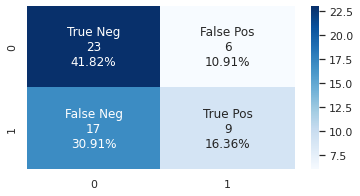

In [271]:
lrVF10, lrVAcc10 = (0.5824506902481977, 0.6555555555555554)
lr = LogisticRegression(penalty='l2', C=0.03359818286283781, solver='liblinear', fit_intercept=True, random_state=31)
lrAcc10, lrF10, lrSens10, lrSpec10 = userModel(lr)

### KNN

Accuracy: 0.5818181818181818
f-measure: 0.30303030303030304
Sensitivity: 0.19230769230769232
Specificity: 0.9310344827586207
              precision    recall  f1-score   support

           0       0.56      0.93      0.70        29
           1       0.71      0.19      0.30        26

    accuracy                           0.58        55
   macro avg       0.64      0.56      0.50        55
weighted avg       0.63      0.58      0.51        55



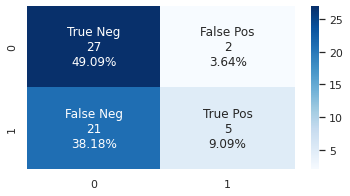

In [272]:
knnVF10, knnVAcc10 = (0.8882645083592648, 0.8722222222222222)
knn = KNeighborsClassifier(n_neighbors=20, weights='distance', algorithm='kd_tree', leaf_size=15, p=1)
knnAcc10, knnF10, knnSens10, knnSpec10 = userModel(knn)

### Decision Tree

Accuracy: 0.5272727272727272
f-measure: 0.0
Sensitivity: 0.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



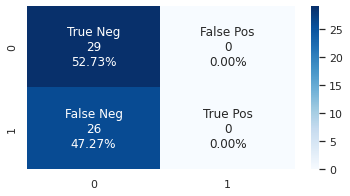

In [273]:
dt = DecisionTreeClassifier(random_state=31)
dtAcc10, dtF10, dtSens10, dtSpec10 = userModel(dt)

### Random Forest

Accuracy: 0.5272727272727272
f-measure: 0.0
Sensitivity: 0.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



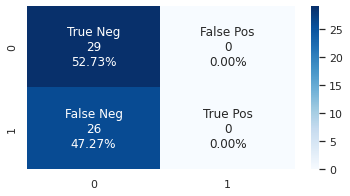

In [274]:
rf = RandomForestClassifier(random_state=31)
rfAcc10, rfF10, rfSens10, rfSpec10 = userModel(rf)

### Boosting

Accuracy: 0.509090909090909
f-measure: 0.0
Sensitivity: 0.0
Specificity: 0.9655172413793104
              precision    recall  f1-score   support

           0       0.52      0.97      0.67        29
           1       0.00      0.00      0.00        26

    accuracy                           0.51        55
   macro avg       0.26      0.48      0.34        55
weighted avg       0.27      0.51      0.36        55



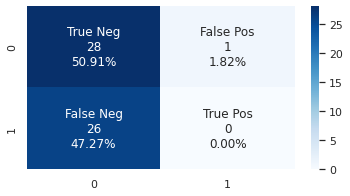

In [275]:
xgbClf = xgb.XGBClassifier(random_state=31)
xgbClfAcc10, xgbClfF10, xgbClfSens10, xgbClfSpec10 = userModel(xgbClf)

## Plots

### Accuracy

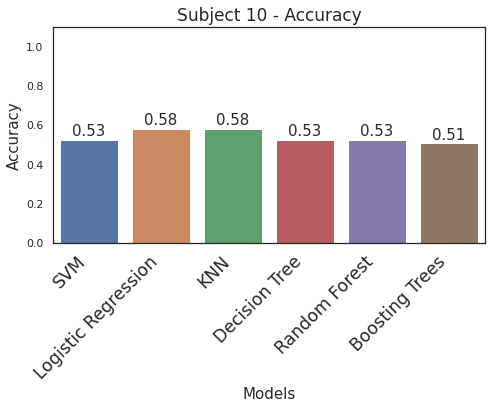

In [276]:
accuracies = [svmClfAcc10, lrAcc10, knnAcc10, dtAcc10, rfAcc10, xgbClfAcc10]
barPlot(accuracies, 'Subject 10 - Accuracy', 'Accuracy')

### F-Measure

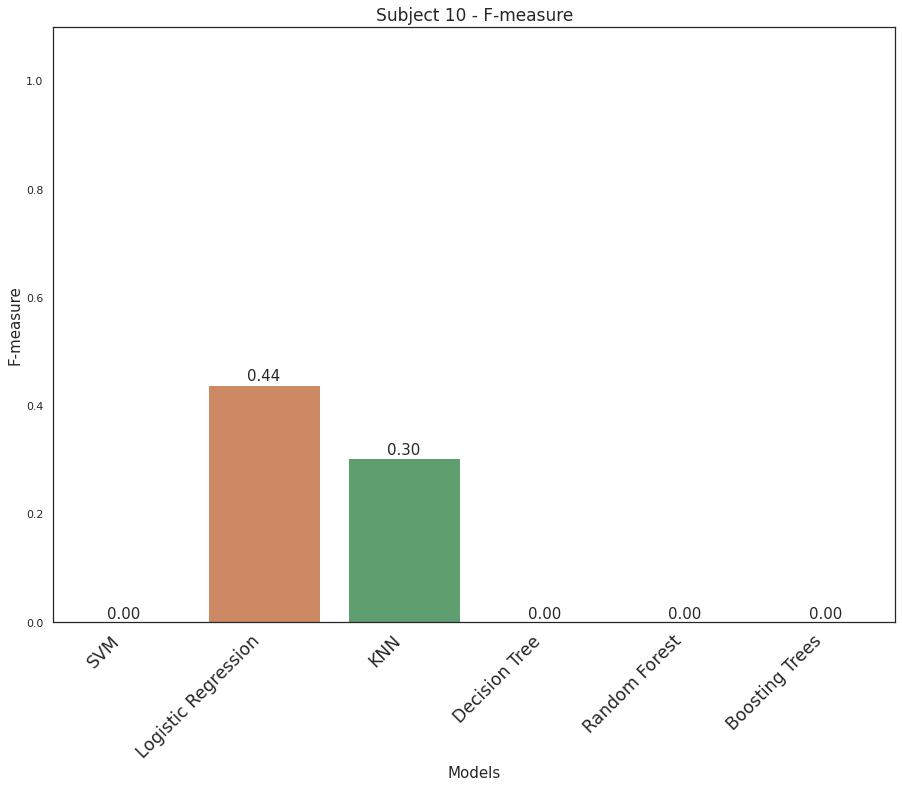

In [277]:
f_measure = [svmClfF10, lrF10, knnF10, dtF10, rfF10, xgbClfF10]
barPlot(f_measure, 'Subject 10 - F-measure', 'F-measure')

### Sensitivity

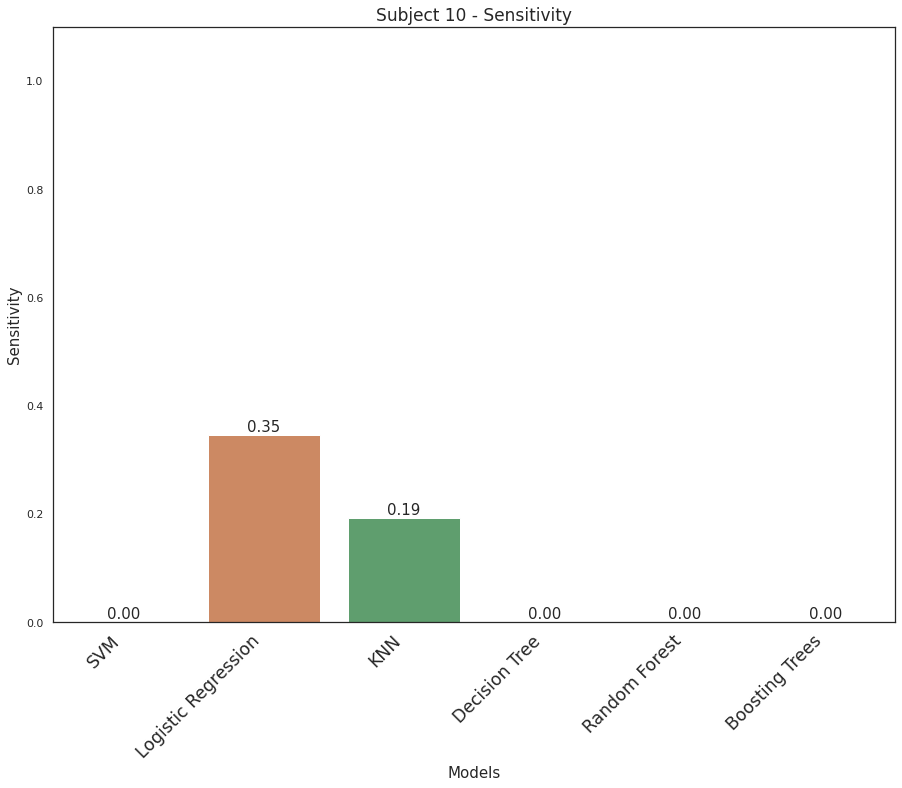

In [278]:
sens = [svmClfSens10, lrSens10, knnSens10, dtSens10, rfSens10, xgbClfSens10]
barPlot(sens, 'Subject 10 - Sensitivity', 'Sensitivity')

### Specificity

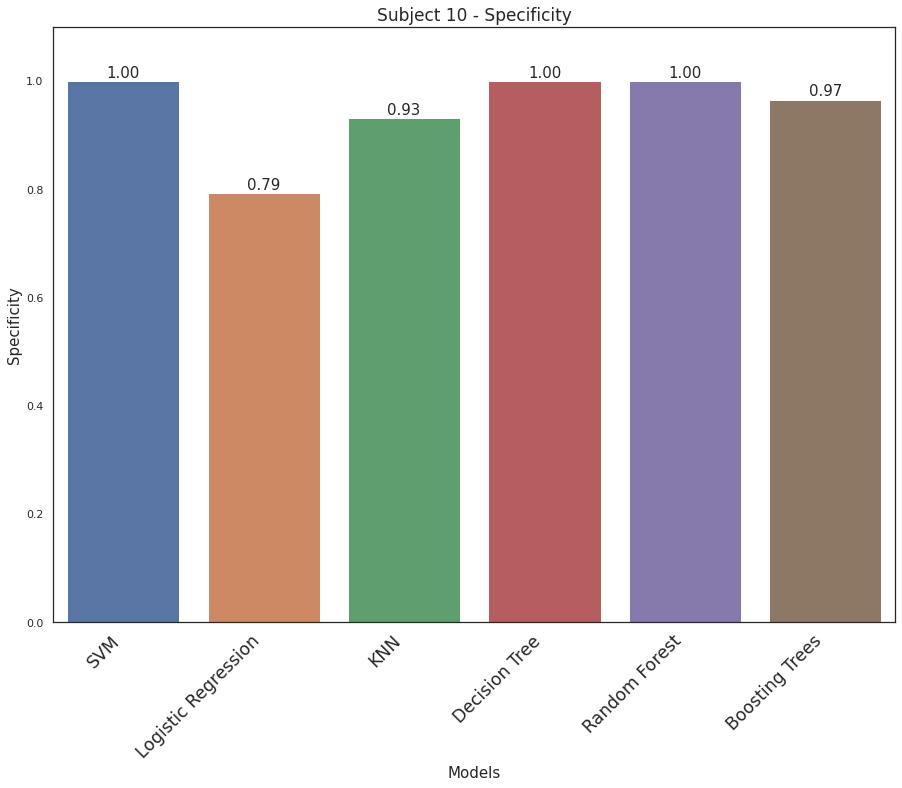

In [279]:
spec = [svmClfSpec10, lrSpec10, knnSpec10, dtSpec10, rfSpec10, xgbClfSpec10]
barPlot(spec, 'Subject 10 - Specificity', 'Specificity')

### Validation F-Measure

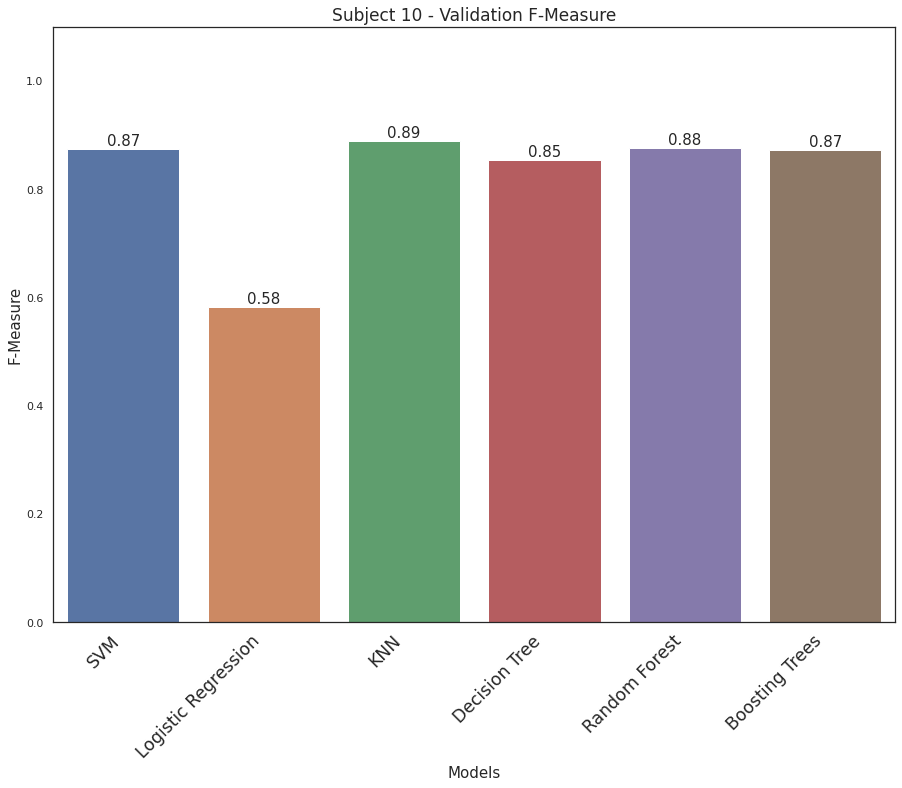

In [280]:
f_measure = [svmClfVF10, lrVF10, knnVF10, dtVF10, rfVF10, xgbClfVF10]
barPlot(f_measure, 'Subject 10 - Validation F-Measure', 'F-Measure')

## Weighted Voting

### 3 WV

Accuracy: 0.5272727272727272
f-measure: 0.0
Sensitivity: 0.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



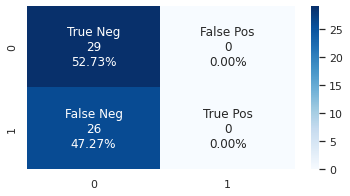

In [281]:
clf = [xgbClf, rf, knn]
weights = np.array([xgbClfVAcc10, rfVAcc10, knnVAcc10])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s10_3wv_acc, s10_3wv_f, s10_3wv_sens, s10_3wv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 WV

Accuracy: 0.5272727272727272
f-measure: 0.0
Sensitivity: 0.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



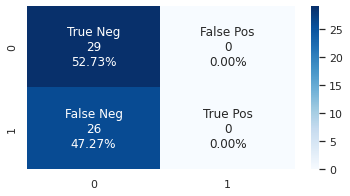

In [282]:
clf = [xgbClf, rf, svmClf, knn, dt]
weights = np.array([xgbClfVAcc10, rfVAcc10, svmClfVAcc10, knnVAcc10, dtVAcc10])
pred = WeightedVotingClassification(clf, weights)
pred[pred>=0.5] = 1
pred[pred<0.5] = 0
s10_5wv_acc, s10_5wv_f, s10_5wv_sens, s10_5wv_spec = getVotingClassifierMetrics(df_testY, pred)

## Majority Voting

### 3 MV

Accuracy: 0.5272727272727272
f-measure: 0.0
Sensitivity: 0.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



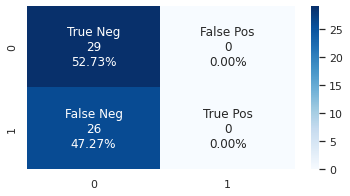

In [283]:
clf = [xgbClf, rf, knn]
pred = MajorityVotingClassification(clf)
s10_3mv_acc, s10_3mv_f, s10_3mv_sens, s10_3mv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 MV

Accuracy: 0.5272727272727272
f-measure: 0.0
Sensitivity: 0.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



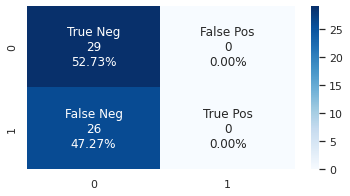

In [284]:
clf = [xgbClf, rf, svmClf, knn, dt]
pred = MajorityVotingClassification(clf)
s10_5mv_acc, s10_5mv_f, s10_5mv_sens, s10_5mv_spec = getVotingClassifierMetrics(df_testY, pred)

## Unanimous Voting

### 3 UV

Accuracy: 0.5272727272727272
f-measure: 0.0
Sensitivity: 0.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



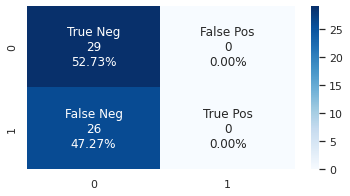

In [285]:
clf = [xgbClf, rf, knn]
pred = UnanimousVotingClassification(clf)
s10_3uv_acc, s10_3uv_f, s10_3uv_sens, s10_3uv_spec = getVotingClassifierMetrics(df_testY, pred)

### 5 UV

Accuracy: 0.5272727272727272
f-measure: 0.0
Sensitivity: 0.0
Specificity: 1.0
              precision    recall  f1-score   support

           0       0.53      1.00      0.69        29
           1       0.00      0.00      0.00        26

    accuracy                           0.53        55
   macro avg       0.26      0.50      0.35        55
weighted avg       0.28      0.53      0.36        55



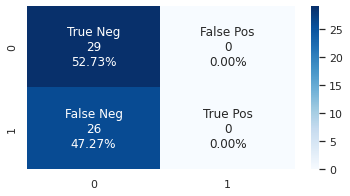

In [286]:
clf = [xgbClf, rf, svmClf, knn, dt]
pred = UnanimousVotingClassification(clf)
s10_5uv_acc, s10_5uv_f, s10_5uv_sens, s10_5uv_spec = getVotingClassifierMetrics(df_testY, pred)

## Metrics

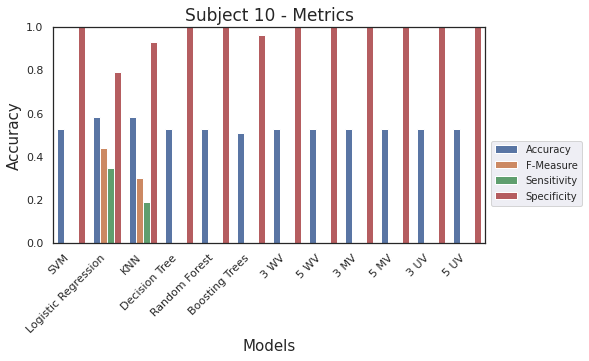

In [287]:
acc_str = ['Accuracy' for i in range(12)]
F_str = ['F-Measure' for i in range(12)]
sens_str = ['Sensitivity' for i in range(12)]
spec_str = ['Specificity' for i in range(12)]
model_list = ['SVM', 'Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Boosting Trees', '3 WV', '5 WV', '3 MV', '5 MV', '3 UV', '5 UV']

acc_list = [svmClfAcc10, lrAcc10, knnAcc10, dtAcc10, rfAcc10, xgbClfAcc10, s10_3wv_acc, s10_5wv_acc, s10_3mv_acc, s10_5mv_acc, s10_3uv_acc, s10_5uv_acc, svmClfF10, lrF10, knnF10, dtF10, rfF10, xgbClfF10, s10_3wv_f, s10_5wv_f, s10_3mv_f, s10_5mv_f, s10_3uv_f, s10_5uv_f, svmClfSens10, lrSens10, knnSens10, dtSens10, rfSens10, xgbClfSens10, s10_3wv_sens, s10_5wv_sens, s10_3mv_sens, s10_5mv_sens, s10_3uv_sens, s10_5uv_sens, svmClfSpec10, lrSpec10, knnSpec10, dtSpec10, rfSpec10, xgbClfSpec10, s10_3wv_spec, s10_5wv_spec, s10_3mv_spec, s10_5mv_spec, s10_3uv_spec, s10_5uv_spec]
data = {
        'Accuracies': acc_list,
        'Metrics': acc_str+F_str+sens_str+spec_str,
        'Models': model_list + model_list + model_list + model_list
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Subject 10 - Metrics', 'Models', 'Accuracies', 'Metrics', 'Models')

# Observations & Results



## Weighted Voting Avg. Accuracy

### 3 WV

In [288]:
(s1_3wv_acc+s2_3wv_acc+s3_3wv_acc+s4_3wv_acc+s5_3wv_acc+s6_3wv_acc+s7_3wv_acc+s8_3wv_acc+s9_3wv_acc+s10_3wv_acc)/float(10)

0.8443939393939395

### 5 WV

In [289]:
(s1_5wv_acc+s2_5wv_acc+s3_5wv_acc+s4_5wv_acc+s5_5wv_acc+s6_5wv_acc+s7_5wv_acc+s8_5wv_acc+s9_5wv_acc+s10_5wv_acc)/float(10)

0.8610606060606061

## Majority Voting Avg. Accuracy

### 3 MV

In [290]:
(s1_3mv_acc+s2_3mv_acc+s3_3mv_acc+s4_3mv_acc+s5_3mv_acc+s6_3mv_acc+s7_3mv_acc+s8_3mv_acc+s9_3mv_acc+s10_3mv_acc)/float(10)

0.8560606060606061

### 5 MV

In [291]:
(s1_5mv_acc+s2_5mv_acc+s3_5mv_acc+s4_5mv_acc+s5_5mv_acc+s6_5mv_acc+s7_5mv_acc+s8_5mv_acc+s9_5mv_acc+s10_5mv_acc)/float(10)

0.8627272727272729

## Unanimous Voting Avg. Accuracy

### 3 UV

In [292]:
(s1_3uv_acc+s2_3uv_acc+s3_3uv_acc+s4_3uv_acc+s5_3uv_acc+s6_3uv_acc+s7_3uv_acc+s8_3uv_acc+s9_3uv_acc+s10_3uv_acc)/float(10)

0.8393939393939395

### 5 UV

In [293]:
(s1_5uv_acc+s2_5uv_acc+s3_5uv_acc+s4_5uv_acc+s5_5uv_acc+s6_5uv_acc+s7_5uv_acc+s8_5uv_acc+s9_5uv_acc+s10_5uv_acc)/float(10)

0.801060606060606

## Plots

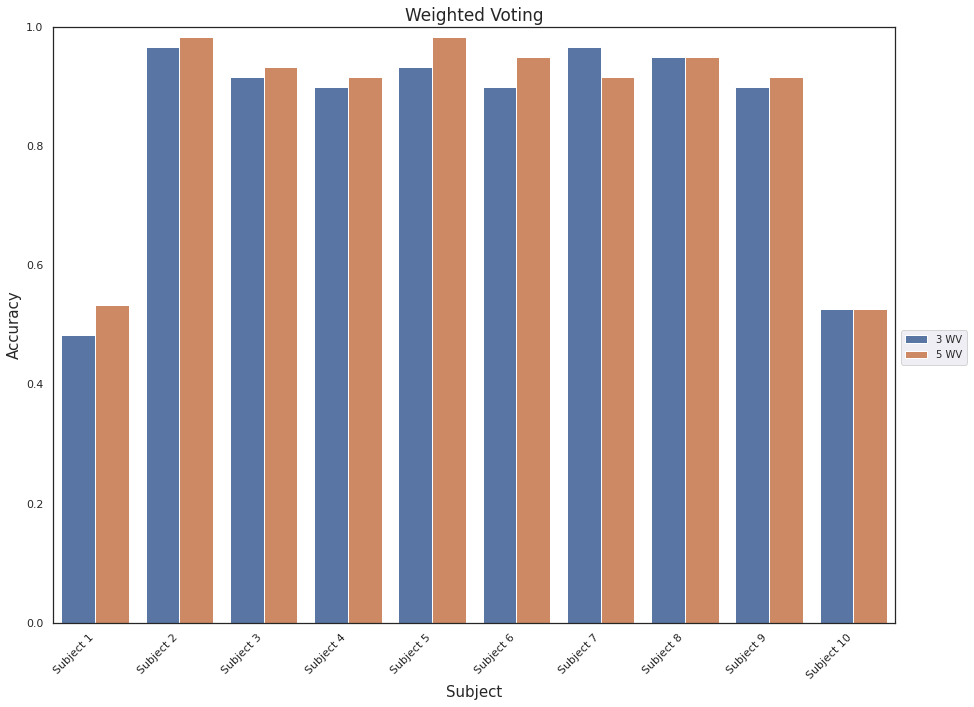

In [294]:
data = {
        'Accuracies': [s1_3wv_acc,s2_3wv_acc,s3_3wv_acc,s4_3wv_acc,s5_3wv_acc,s6_3wv_acc,s7_3wv_acc,s8_3wv_acc,s9_3wv_acc,s10_3wv_acc,s1_5wv_acc,s2_5wv_acc,s3_5wv_acc,s4_5wv_acc,s5_5wv_acc,s6_5wv_acc,s7_5wv_acc,s8_5wv_acc,s9_5wv_acc,s10_5wv_acc], 
        'Voting': ['3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','3 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV','5 WV'],
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Weighted Voting', 'Subject', 'Accuracies', 'Voting', 'Subject')

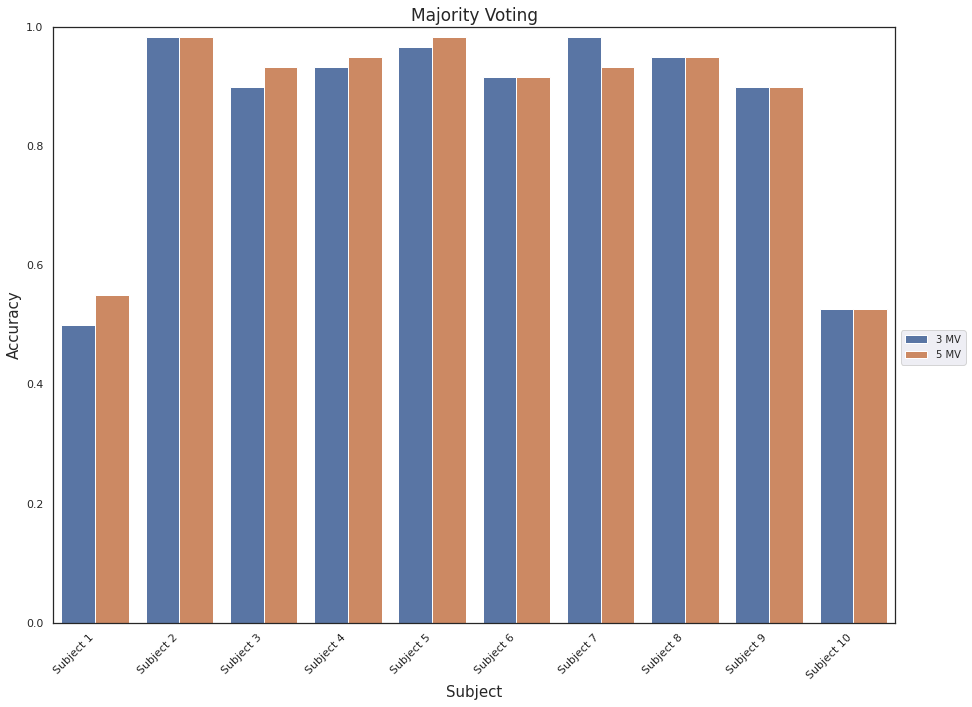

In [295]:
data = {
        'Accuracies': [s1_3mv_acc,s2_3mv_acc,s3_3mv_acc,s4_3mv_acc,s5_3mv_acc,s6_3mv_acc,s7_3mv_acc,s8_3mv_acc,s9_3mv_acc,s10_3mv_acc,s1_5mv_acc,s2_5mv_acc,s3_5mv_acc,s4_5mv_acc,s5_5mv_acc,s6_5mv_acc,s7_5mv_acc,s8_5mv_acc,s9_5mv_acc,s10_5mv_acc], 
        'Voting': ['3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','3 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV','5 MV'],
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Majority Voting', 'Subject', 'Accuracies', 'Voting', 'Subject')

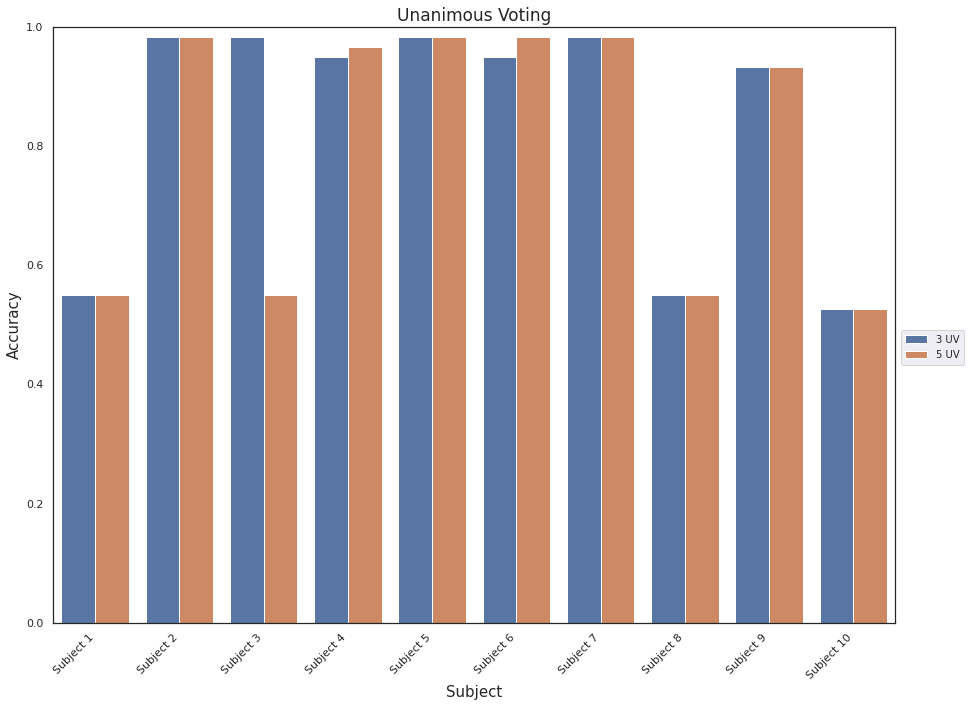

In [296]:
data = {
        'Accuracies': [s1_3uv_acc,s2_3uv_acc,s3_3uv_acc,s4_3uv_acc,s5_3uv_acc,s6_3uv_acc,s7_3uv_acc,s8_3uv_acc,s9_3uv_acc,s10_3uv_acc,s1_5uv_acc,s2_5uv_acc,s3_5uv_acc,s4_5uv_acc,s5_5uv_acc,s6_5uv_acc,s7_5uv_acc,s8_5uv_acc,s9_5uv_acc,s10_5uv_acc], 
        'Voting': ['3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','3 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV','5 UV'],
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, 'Unanimous Voting', 'Subject', 'Accuracies', 'Voting', 'Subject')

In [297]:
wv_str = ['Weighted Voting' for i in range(10)]
mv_str = ['Majority Voting' for i in range(10)]
uv_str = ['Unanimous Voting' for i in range(10)]

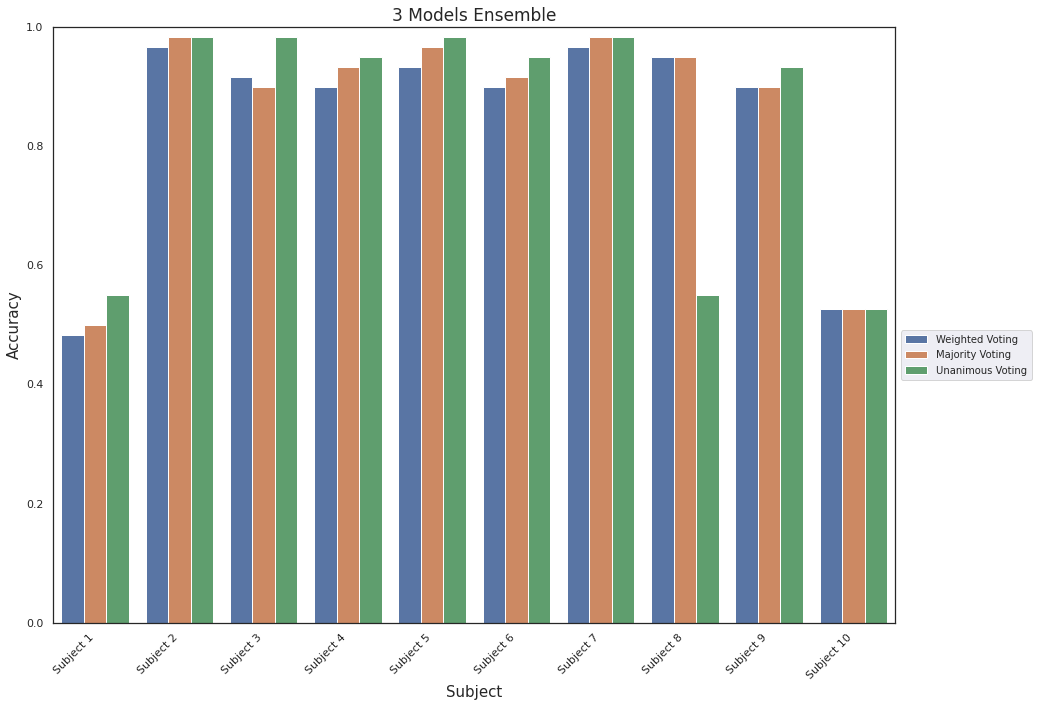

In [298]:
data = {
        'Accuracies': [s1_3wv_acc,s2_3wv_acc,s3_3wv_acc,s4_3wv_acc,s5_3wv_acc,s6_3wv_acc,s7_3wv_acc,s8_3wv_acc,s9_3wv_acc,s10_3wv_acc,s1_3mv_acc,s2_3mv_acc,s3_3mv_acc,s4_3mv_acc,s5_3mv_acc,s6_3mv_acc,s7_3mv_acc,s8_3mv_acc,s9_3mv_acc,s10_3mv_acc,s1_3uv_acc,s2_3uv_acc,s3_3uv_acc,s4_3uv_acc,s5_3uv_acc,s6_3uv_acc,s7_3uv_acc,s8_3uv_acc,s9_3uv_acc,s10_3uv_acc],
        'Voting': wv_str+mv_str+uv_str,
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, '3 Models Ensemble', 'Subject', 'Accuracies', 'Voting', 'Subject')

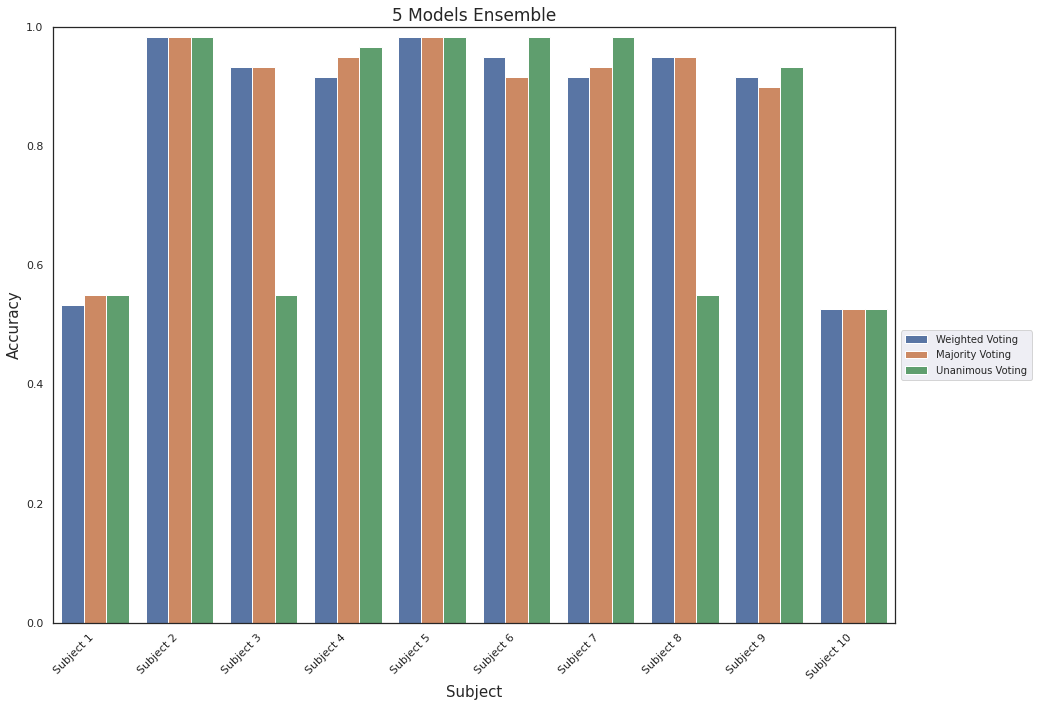

In [299]:
data = {
        'Accuracies': [s1_5wv_acc,s2_5wv_acc,s3_5wv_acc,s4_5wv_acc,s5_5wv_acc,s6_5wv_acc,s7_5wv_acc,s8_5wv_acc,s9_5wv_acc,s10_5wv_acc,s1_5mv_acc,s2_5mv_acc,s3_5mv_acc,s4_5mv_acc,s5_5mv_acc,s6_5mv_acc,s7_5mv_acc,s8_5mv_acc,s9_5mv_acc,s10_5mv_acc,s1_5uv_acc,s2_5uv_acc,s3_5uv_acc,s4_5uv_acc,s5_5uv_acc,s6_5uv_acc,s7_5uv_acc,s8_5uv_acc,s9_5uv_acc,s10_5uv_acc],
        'Voting': wv_str+mv_str+uv_str,
        'Subject': ['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10','Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6', 'Subject 7', 'Subject 8', 'Subject 9', 'Subject 10']
        }
df = pd.DataFrame(data)
masterBarPlot(df, '5 Models Ensemble', 'Subject', 'Accuracies', 'Voting', 'Subject')

# Accuracies

In [320]:
svmClfAcc1, lrAcc1, knnAcc1, dtAcc1, rfAcc1, xgbClfAcc1, s1_3wv_acc, s1_5wv_acc, s1_3mv_acc, s1_5mv_acc, s1_3uv_acc, s1_5uv_acc

(0.4166666666666667,
 0.75,
 0.43333333333333335,
 0.43333333333333335,
 0.55,
 0.55,
 0.48333333333333334,
 0.5333333333333333,
 0.5,
 0.55,
 0.55,
 0.55)

In [321]:
svmClfAcc2, lrAcc2, knnAcc2, dtAcc2, rfAcc2, xgbClfAcc2, s2_3wv_acc, s2_5wv_acc, s2_3mv_acc, s2_5mv_acc, s2_3uv_acc, s2_5uv_acc

(0.9666666666666667,
 0.38333333333333336,
 0.9333333333333333,
 0.8833333333333333,
 0.9833333333333333,
 0.9666666666666667,
 0.9666666666666667,
 0.9833333333333333,
 0.9833333333333333,
 0.9833333333333333,
 0.9833333333333333,
 0.9833333333333333)

In [322]:
svmClfAcc3, lrAcc3, knnAcc3, dtAcc3, rfAcc3, xgbClfAcc3, s3_3wv_acc, s3_5wv_acc, s3_3mv_acc, s3_5mv_acc, s3_3uv_acc, s3_5uv_acc

(0.9166666666666666,
 0.3,
 0.8166666666666667,
 0.9,
 0.9666666666666667,
 0.9666666666666667,
 0.9166666666666666,
 0.9333333333333333,
 0.9,
 0.9333333333333333,
 0.9833333333333333,
 0.55)

In [323]:
svmClfAcc4, lrAcc4, knnAcc4, dtAcc4, rfAcc4, xgbClfAcc4, s4_3wv_acc, s4_5wv_acc, s4_3mv_acc, s4_5mv_acc, s4_3uv_acc, s4_5uv_acc

(0.9,
 0.7666666666666667,
 0.8833333333333333,
 0.85,
 0.95,
 0.95,
 0.9,
 0.9166666666666666,
 0.9333333333333333,
 0.95,
 0.95,
 0.9666666666666667)

In [324]:
svmClfAcc5, lrAcc5, knnAcc5, dtAcc5, rfAcc5, xgbClfAcc5, s5_3wv_acc, s5_5wv_acc, s5_3mv_acc, s5_5mv_acc, s5_3uv_acc, s5_5uv_acc

(0.9833333333333333,
 0.35,
 0.95,
 0.9333333333333333,
 0.9666666666666667,
 0.9833333333333333,
 0.9333333333333333,
 0.9833333333333333,
 0.9666666666666667,
 0.9833333333333333,
 0.9833333333333333,
 0.9833333333333333)

In [325]:
svmClfAcc6, lrAcc6, knnAcc6, dtAcc6, rfAcc6, xgbClfAcc6, s6_3wv_acc, s6_5wv_acc, s6_3mv_acc, s6_5mv_acc, s6_3uv_acc, s6_5uv_acc

(0.95,
 0.7666666666666667,
 0.7833333333333333,
 0.9166666666666666,
 0.95,
 0.9166666666666666,
 0.9,
 0.95,
 0.9166666666666666,
 0.9166666666666666,
 0.95,
 0.9833333333333333)

In [326]:
svmClfAcc7, lrAcc7, knnAcc7, dtAcc7, rfAcc7, xgbClfAcc7, s7_3wv_acc, s7_5wv_acc, s7_3mv_acc, s7_5mv_acc, s7_3uv_acc, s7_5uv_acc

(0.9,
 0.6666666666666666,
 0.8333333333333334,
 0.85,
 0.9833333333333333,
 0.9833333333333333,
 0.9666666666666667,
 0.9166666666666666,
 0.9833333333333333,
 0.9333333333333333,
 0.9833333333333333,
 0.9833333333333333)

In [327]:
svmClfAcc8, lrAcc8, knnAcc8, dtAcc8, rfAcc8, xgbClfAcc8, s8_3wv_acc, s8_5wv_acc, s8_3mv_acc, s8_5mv_acc, s8_3uv_acc, s8_5uv_acc

(0.5166666666666667,
 0.35,
 0.7666666666666667,
 0.95,
 0.9833333333333333,
 0.9666666666666667,
 0.95,
 0.95,
 0.95,
 0.95,
 0.55,
 0.55)

In [328]:
svmClfAcc9, lrAcc9, knnAcc9, dtAcc9, rfAcc9, xgbClfAcc9, s9_3wv_acc, s9_5wv_acc, s9_3mv_acc, s9_5mv_acc, s9_3uv_acc, s9_5uv_acc

(0.9166666666666666,
 0.7666666666666667,
 0.9,
 0.9,
 0.9333333333333333,
 0.9,
 0.9,
 0.9166666666666666,
 0.9,
 0.9,
 0.9333333333333333,
 0.9333333333333333)

In [329]:
svmClfAcc10, lrAcc10, knnAcc10, dtAcc10, rfAcc10, xgbClfAcc10, s10_3wv_acc, s10_5wv_acc, s10_3mv_acc, s10_5mv_acc, s10_3uv_acc, s10_5uv_acc

(0.5272727272727272,
 0.5818181818181818,
 0.5818181818181818,
 0.5272727272727272,
 0.5272727272727272,
 0.509090909090909,
 0.5272727272727272,
 0.5272727272727272,
 0.5272727272727272,
 0.5272727272727272,
 0.5272727272727272,
 0.5272727272727272)

# F-Measure

In [330]:
svmClfF1, lrF1, knnF1, dtF1, rfF1, xgbClfF1, s1_3wv_f, s1_5wv_f, s1_3mv_f, s1_5mv_f, s1_3uv_f, s1_5uv_f

(0.14634146341463417,
 0.8,
 0.15,
 0.15,
 0.18181818181818182,
 0.18181818181818182,
 0.16216216216216217,
 0.17647058823529416,
 0.16666666666666669,
 0.18181818181818182,
 0.18181818181818182,
 0.18181818181818182)

In [331]:
svmClfF2, lrF2, knnF2, dtF2, rfF2, xgbClfF2, s2_3wv_f, s2_5wv_f, s2_3mv_f, s2_5mv_f, s2_3uv_f, s2_5uv_f

(0.967741935483871,
 0.13953488372093023,
 0.9375,
 0.8955223880597014,
 0.9836065573770492,
 0.967741935483871,
 0.967741935483871,
 0.9836065573770492,
 0.9836065573770492,
 0.9836065573770492,
 0.9836065573770492,
 0.9836065573770492)

In [332]:
svmClfF3, lrF3, knnF3, dtF3, rfF3, xgbClfF3, s3_3wv_f, s3_5wv_f, s3_3mv_f, s3_5mv_f, s3_3uv_f, s3_5uv_f

(0.923076923076923,
 0.125,
 0.8450704225352113,
 0.9090909090909091,
 0.967741935483871,
 0.967741935483871,
 0.923076923076923,
 0.9375,
 0.9090909090909091,
 0.9375,
 0.9836065573770492,
 0.18181818181818182)

In [333]:
svmClfF4, lrF4, knnF4, dtF4, rfF4, xgbClfF4, s4_3wv_f, s4_5wv_f, s4_3mv_f, s4_5mv_f, s4_3uv_f, s4_5uv_f

(0.9090909090909091,
 0.8108108108108109,
 0.8955223880597014,
 0.8695652173913044,
 0.9523809523809523,
 0.9523809523809523,
 0.9090909090909091,
 0.923076923076923,
 0.9375,
 0.9523809523809523,
 0.9523809523809523,
 0.967741935483871)

In [334]:
svmClfF5, lrF5, knnF5, dtF5, rfF5, xgbClfF5, s5_3wv_f, s5_5wv_f, s5_3mv_f, s5_5mv_f, s5_3uv_f, s5_5uv_f

(0.9836065573770492,
 0.13333333333333333,
 0.9523809523809523,
 0.9375,
 0.967741935483871,
 0.9836065573770492,
 0.9375,
 0.9836065573770492,
 0.967741935483871,
 0.9836065573770492,
 0.9836065573770492,
 0.9836065573770492)

In [335]:
svmClfF6, lrF6, knnF6, dtF6, rfF6, xgbClfF6, s6_3wv_f, s6_5wv_f, s6_3mv_f, s6_5mv_f, s6_3uv_f, s6_5uv_f

(0.9523809523809523,
 0.8108108108108109,
 0.8219178082191781,
 0.923076923076923,
 0.9523809523809523,
 0.923076923076923,
 0.9090909090909091,
 0.9523809523809523,
 0.923076923076923,
 0.923076923076923,
 0.9523809523809523,
 0.9836065573770492)

In [336]:
svmClfF7, lrF7, knnF7, dtF7, rfF7, xgbClfF7, s7_3wv_f, s7_5wv_f, s7_3mv_f, s7_5mv_f, s7_3uv_f, s7_5uv_f

(0.9090909090909091,
 0.7499999999999999,
 0.8571428571428571,
 0.8695652173913044,
 0.9836065573770492,
 0.9836065573770492,
 0.967741935483871,
 0.923076923076923,
 0.9836065573770492,
 0.9375,
 0.9836065573770492,
 0.9836065573770492)

In [337]:
svmClfF8, lrF8, knnF8, dtF8, rfF8, xgbClfF8, s8_3wv_f, s8_5wv_f, s8_3mv_f, s8_5mv_f, s8_3uv_f, s8_5uv_f

(0.17142857142857143,
 0.13333333333333333,
 0.8108108108108109,
 0.9523809523809523,
 0.9836065573770492,
 0.967741935483871,
 0.9523809523809523,
 0.9523809523809523,
 0.9523809523809523,
 0.9523809523809523,
 0.18181818181818182,
 0.18181818181818182)

In [338]:
svmClfF9, lrF9, knnF9, dtF9, rfF9, xgbClfF9, s9_3wv_f, s9_5wv_f, s9_3mv_f, s9_5mv_f, s9_3uv_f, s9_5uv_f

(0.9152542372881356,
 0.7941176470588235,
 0.9032258064516129,
 0.9032258064516129,
 0.9310344827586207,
 0.9,
 0.9,
 0.9180327868852459,
 0.9,
 0.9,
 0.9310344827586207,
 0.9310344827586207)

In [339]:
svmClfF10, lrF10, knnF10, dtF10, rfF10, xgbClfF10, s10_3wv_f, s10_5wv_f, s10_3mv_f, s10_5mv_f, s10_3uv_f, s10_5uv_f

(0.0,
 0.43902439024390244,
 0.30303030303030304,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

# Sensitivity

In [343]:
svmClfSens1, lrSens1, knnSens1, dtSens1, rfSens1, xgbClfSens1, s1_3wv_sens, s1_5wv_sens, s1_3mv_sens, s1_5mv_sens, s1_3uv_sens, s1_5uv_sens

(0.1, 1.0, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

In [344]:
svmClfSens2, lrSens2, knnSens2, dtSens2, rfSens2, xgbClfSens2, s2_3wv_sens, s2_5wv_sens, s2_3mv_sens, s2_5mv_sens, s2_3uv_sens, s2_5uv_sens

(1.0, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

In [345]:
svmClfSens3, lrSens3, knnSens3, dtSens3, rfSens3, xgbClfSens3, s3_3wv_sens, s3_5wv_sens, s3_3mv_sens, s3_5mv_sens, s3_3uv_sens, s3_5uv_sens

(1.0, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1)

In [346]:
svmClfSens4, lrSens4, knnSens4, dtSens4, rfSens4, xgbClfSens4, s4_3wv_sens, s4_5wv_sens, s4_3mv_sens, s4_5mv_sens, s4_3uv_sens, s4_5uv_sens

(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

In [347]:
svmClfSens5, lrSens5, knnSens5, dtSens5, rfSens5, xgbClfSens5, s5_3wv_sens, s5_5wv_sens, s5_3mv_sens, s5_5mv_sens, s5_3uv_sens, s5_5uv_sens

(1.0, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

In [348]:
svmClfSens6, lrSens6, knnSens6, dtSens6, rfSens6, xgbClfSens6, s6_3wv_sens, s6_5wv_sens, s6_3mv_sens, s6_5mv_sens, s6_3uv_sens, s6_5uv_sens

(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

In [349]:
svmClfSens7, lrSens7, knnSens7, dtSens7, rfSens7, xgbClfSens7, s7_3wv_sens, s7_5wv_sens, s7_3mv_sens, s7_5mv_sens, s7_3uv_sens, s7_5uv_sens

(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)

In [350]:
svmClfSens8, lrSens8, knnSens8, dtSens8, rfSens8, xgbClfSens8, s8_3wv_sens, s8_5wv_sens, s8_3mv_sens, s8_5mv_sens, s8_3uv_sens, s8_5uv_sens

(0.1, 0.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.1, 0.1)

In [351]:
svmClfSens9, lrSens9, knnSens9, dtSens9, rfSens9, xgbClfSens9, s9_3wv_sens, s9_5wv_sens, s9_3mv_sens, s9_5mv_sens, s9_3uv_sens, s9_5uv_sens

(0.9,
 0.9,
 0.9333333333333333,
 0.9333333333333333,
 0.9,
 0.9,
 0.9,
 0.9333333333333333,
 0.9,
 0.9,
 0.9,
 0.9)

In [352]:
svmClfSens10, lrSens10, knnSens10, dtSens10, rfSens10, xgbClfSens10, s10_3wv_sens, s10_5wv_sens, s10_3mv_sens, s10_5mv_sens, s10_3uv_sens, s10_5uv_sens

(0.0,
 0.34615384615384615,
 0.19230769230769232,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

# Specificity

In [353]:
svmClfSpec1, lrSpec1, knnSpec1, dtSpec1, rfSpec1, xgbClfSpec1, s1_3wv_spec, s1_5wv_spec, s1_3mv_spec, s1_5mv_spec, s1_3uv_spec, s1_5uv_spec

(0.7333333333333333,
 0.5,
 0.7666666666666667,
 0.7666666666666667,
 1.0,
 1.0,
 0.8666666666666667,
 0.9666666666666667,
 0.9,
 1.0,
 1.0,
 1.0)

In [354]:
svmClfSpec2, lrSpec2, knnSpec2, dtSpec2, rfSpec2, xgbClfSpec2, s2_3wv_spec, s2_5wv_spec, s2_3mv_spec, s2_5mv_spec, s2_3uv_spec, s2_5uv_spec

(0.9333333333333333,
 0.6666666666666666,
 0.8666666666666667,
 0.7666666666666667,
 0.9666666666666667,
 0.9333333333333333,
 0.9333333333333333,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667)

In [355]:
svmClfSpec3, lrSpec3, knnSpec3, dtSpec3, rfSpec3, xgbClfSpec3, s3_3wv_spec, s3_5wv_spec, s3_3mv_spec, s3_5mv_spec, s3_3uv_spec, s3_5uv_spec

(0.8333333333333334,
 0.5,
 0.6333333333333333,
 0.8,
 0.9333333333333333,
 0.9333333333333333,
 0.8333333333333334,
 0.8666666666666667,
 0.8,
 0.8666666666666667,
 0.9666666666666667,
 1.0)

In [357]:
svmClfSpec4, lrSpec4, knnSpec4, dtSpec4, rfSpec4, xgbClfSpec4, s4_3wv_spec, s4_5wv_spec, s4_3mv_spec, s4_5mv_spec, s4_3uv_spec, s4_5uv_spec

(0.8,
 0.5333333333333333,
 0.7666666666666667,
 0.7,
 0.9,
 0.9,
 0.8,
 0.8333333333333334,
 0.8666666666666667,
 0.9,
 0.9,
 0.9333333333333333)

In [358]:
svmClfSpec5, lrSpec5, knnSpec5, dtSpec5, rfSpec5, xgbClfSpec5, s5_3wv_spec, s5_5wv_spec, s5_3mv_spec, s5_5mv_spec, s5_3uv_spec, s5_5uv_spec

(0.9666666666666667,
 0.6,
 0.9,
 0.8666666666666667,
 0.9333333333333333,
 0.9666666666666667,
 0.8666666666666667,
 0.9666666666666667,
 0.9333333333333333,
 0.9666666666666667,
 0.9666666666666667,
 0.9666666666666667)

In [359]:
svmClfSpec6, lrSpec6, knnSpec6, dtSpec6, rfSpec6, xgbClfSpec6, s6_3wv_spec, s6_5wv_spec, s6_3mv_spec, s6_5mv_spec, s6_3uv_spec, s6_5uv_spec

(0.9,
 0.5333333333333333,
 0.5666666666666667,
 0.8333333333333334,
 0.9,
 0.8333333333333334,
 0.8,
 0.9,
 0.8333333333333334,
 0.8333333333333334,
 0.9,
 0.9666666666666667)

In [361]:
svmClfSpec7, lrSpec7, knnSpec7, dtSpec7, rfSpec7, xgbClfSpec7, s7_3wv_spec, s7_5wv_spec, s7_3mv_spec, s7_5mv_spec, s7_3uv_spec, s7_5uv_spec

(0.8,
 0.3333333333333333,
 0.6666666666666666,
 0.7,
 0.9666666666666667,
 0.9666666666666667,
 0.9333333333333333,
 0.8333333333333334,
 0.9666666666666667,
 0.8666666666666667,
 0.9666666666666667,
 0.9666666666666667)

In [360]:
svmClfSpec8, lrSpec8, knnSpec8, dtSpec8, rfSpec8, xgbClfSpec8, s8_3wv_spec, s8_5wv_spec, s8_3mv_spec, s8_5mv_spec, s8_3uv_spec, s8_5uv_spec

(0.9333333333333333,
 0.6,
 0.5333333333333333,
 0.9,
 0.9666666666666667,
 0.9333333333333333,
 0.9,
 0.9,
 0.9,
 0.9,
 1.0,
 1.0)

In [362]:
svmClfSpec9, lrSpec9, knnSpec9, dtSpec9, rfSpec9, xgbClfSpec9, s9_3wv_spec, s9_5wv_spec, s9_3mv_spec, s9_5mv_spec, s9_3uv_spec, s9_5uv_spec

(0.9333333333333333,
 0.6333333333333333,
 0.8666666666666667,
 0.8666666666666667,
 0.9666666666666667,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9,
 0.9666666666666667,
 0.9666666666666667)

In [363]:
svmClfSpec10, lrSpec10, knnSpec10, dtSpec10, rfSpec10, xgbClfSpec10, s10_3wv_spec, s10_5wv_spec, s10_3mv_spec, s10_5mv_spec, s10_3uv_spec, s10_5uv_spec

(1.0,
 0.7931034482758621,
 0.9310344827586207,
 1.0,
 1.0,
 0.9655172413793104,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0)